In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
import os
import numpy.ma as ma
from collections import Counter
from dateutil.relativedelta import relativedelta
from scipy.stats import chi2_contingency, kruskal, fisher_exact
from scipy.stats import spearmanr, kendalltau
from statannotations.Annotator import Annotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mtick
from statsmodels.stats.multitest import multipletests

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
hfont = {'fontname':'Arial'}

In [4]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

In [5]:
key_regions = ["hippocampus", "parahippocampal", "entorhinal", "amygdala", "cingulate", "frontal", "occipital", "ventricle"]
def get_selected_cols(cols, key_regions):
    region_dict = {}
    cols_include = []
    for region in key_regions:
        region_dict[region] = [_ for _, col in enumerate(cols) if region in col.lower()]
        cols_include += region_dict[region]
    return cols_include

## Change the path to the pickled file

In [6]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/pickle_files/sim_tadpole33_subtype3.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [7]:
pkl["ml_subtype"].shape

(850, 1)

In [8]:
pkl["samples_likelihood"].shape

(2000000, 1)

### Check that the MCI and CN/AD files have same column names

In [9]:
# MCI and CN/AD data
cn_ad_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_cnad_no_5ventricle_adj.csv"
df_cnad = pd.read_csv(cn_ad_path)
mci_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_mci_no_5ventricle_adj.csv"
df_mci = pd.read_csv(mci_path)
df_cnad["EXAMDATE"] = pd.to_datetime(df_cnad["EXAMDATE"])
df_mci["EXAMDATE"] = pd.to_datetime(df_mci["EXAMDATE"])
assert all(df_mci.columns == df_cnad.columns)

## Subtyping and Staging the subjects

### Get the probability matrices for CN/AD

In [10]:
# Get the mixture model for the CN/AD subjects
k=118
X = df_cnad.iloc[:,:k].values
bm_names = df_cnad.columns[:k].tolist()
y = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X, y)
L_yes = np.zeros(X.shape)
L_no = np.zeros(X.shape)
for i in range(k):
    L_no[:, i], L_yes[:, i] = mixture_models[i].pdfs_mixture_components(X[:, i], None)

L_no = process_L(L_no)
L_yes = process_L(L_yes)

### Create a SuStaIn object to call the associated methods

In [11]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [24,23,24,23,24]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 2
p_absorb = 0.3
N_em = 100
SuStaInLabels = df_cnad.columns[:k].tolist()
dataset_name            = 'sim_tadpole33'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes, L_no, n_stages, stage_sizes, min_clust_size, p_absorb, rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, N_iterations_MCMC, N_em, output_folder, dataset_name, use_parallel_startpoints)

### Get the prob mat for the mci subjects

In [12]:
# Get the prob mat for the mci subjects
X_mci = df_mci.iloc[:,:k].values
prob_mat_mci = mixture_model.get_prob_mat(X_mci, mixture_models)
L_no_mci = prob_mat_mci[:,:,0]
L_yes_mci = prob_mat_mci[:,:,1]
L_no_mci = process_L(L_no_mci)
L_yes_mci = process_L(L_yes_mci)

### Subtype and Stage the MCI subjects

In [13]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_newData = sEBMSustainData(L_yes_mci, L_no_mci, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci, ll = sustain.subtype_and_stage_individuals(sustainData_newData, shape_seq, samples_sequence, samples_f, N_samples)


In [14]:
np.mean(ll), np.std(ll)

(-771535.0390465037, 23.042331465770808)

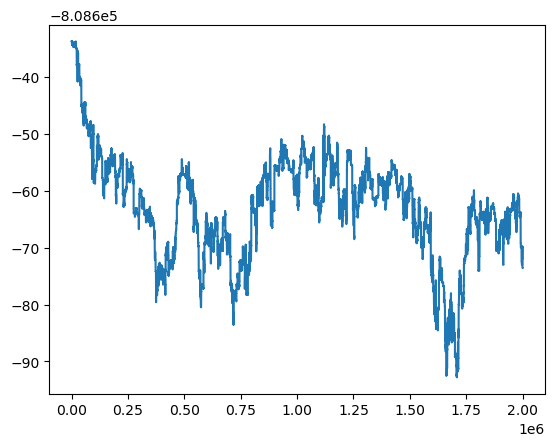

In [15]:
# plt.plot(ll)
plt.plot(pkl["samples_likelihood"])

### Subtype and Stage CN/AD data

In [16]:
# subtype and stage CN/AD data

sustainData_cnad = sEBMSustainData(L_yes, L_no, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]

ml_subtype_cnad, \
prob_ml_subtype_cnad, \
ml_stage_cnad, \
prob_ml_stage_cnad, \
prob_subtype_cnad, \
prob_stage_cnad, \
prob_subtype_stage_cnad, _ = sustain.subtype_and_stage_individuals(sustainData_cnad, shape_seq, samples_sequence,
                                                                   samples_f, N_samples)


In [17]:
n_cnad = ml_subtype_cnad.shape[0]
n_mci = ml_subtype_mci.shape[0]
unique_cnad, counts_cnad = np.unique(ml_subtype_cnad, return_counts=True)
unique_mci, counts_mci = np.unique(ml_subtype_mci, return_counts=True)

fraction_cnad = {}
dict_cnad = dict(zip(unique_cnad, counts_cnad))
for k, v in dict_cnad.items():
    fraction_cnad[k] = v/n_cnad
    
fraction_mci = {}
dict_mci = dict(zip(unique_mci, counts_mci))
for k, v in dict_mci.items():
    fraction_mci[k] = v/n_mci
    
print("CN/AD fractions across subtypes : \n", fraction_cnad)
print("MCI fractions across subtypes : \n", fraction_mci)

CN/AD fractions across subtypes : 
 {0.0: 0.49411764705882355, 1.0: 0.18, 2.0: 0.17647058823529413, 3.0: 0.14941176470588236}
MCI fractions across subtypes : 
 {0.0: 0.4665841584158416, 1.0: 0.1905940594059406, 2.0: 0.17202970297029702, 3.0: 0.1707920792079208}


### Get subjects for a givensubtype

### Prepare final dataframe which has subtype, stage, PTID, DX, and EXAMDATE for all subjects

In [18]:
# DataFrame for CN/AD subjects
array_subtype_stage_cnad = np.hstack([ml_subtype_cnad, ml_stage_cnad, y.values.reshape(-1,1)])
cnad_solved = pd.DataFrame(data=array_subtype_stage_cnad, columns=["subtype", "stage", "DX"])
cnad_solved[["PTID", "EXAMDATE", "VISCODE"]] = df_cnad[["PTID", "EXAMDATE", "VISCODE"]]

In [19]:
# DataFrame for MCI subjects
array_subtype_stage_mci = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_solved = pd.DataFrame(data=array_subtype_stage_mci, columns=["subtype", "stage"])
mci_solved["DX"] = 2.0
mci_solved[["PTID", "EXAMDATE", "VISCODE"]] = df_mci[["PTID", "EXAMDATE", "VISCODE"]]
final_df = pd.concat([cnad_solved, mci_solved], axis=0)

In [20]:
final_df["DX"] = final_df["DX"].map({0.0:"Controls", 1.0:"AD", 2.0:"MCI"})

# Prepare final_df (Add RID)

In [21]:
final_df["RID"] = final_df["PTID"].apply(lambda x: int(x.split("_")[-1]))

# Process data for filtering operations / StatsModel

In [22]:
def process_df(df, fld, keep="first"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_fld.drop_duplicates("sid", keep=keep, inplace=True)
    return df_fld

def regress_score(df, field, covariates, examdate="EXAMDATE", n_subtypes=4):
    subtypes = list(range(n_subtypes))
    df_fld = df.dropna(subset=[field])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    one_hot_cols = pd.get_dummies(df_fld["subtype"])
    one_hot_cols = one_hot_cols[subtypes]
    new_cols = ["st{}".format(_) for _ in subtypes]
    one_hot_cols.columns = new_cols
    df_one_hot = pd.concat([df_fld[covariates+[field]], one_hot_cols], axis=1)
    return df_one_hot

def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

def regress_OLS_logodds(df, fld, cov):
    model = sm.OLS(np.log(df[[fld]]/(1 - df[[fld]])), sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

In [23]:
final_df

subtype  stage        DX        PTID   EXAMDATE VISCODE   RID
0        1.0    1.0  Controls  002_S_0295 2006-05-09      bl   295
1        0.0    1.0  Controls  002_S_0413 2007-06-01     m12   413
2        0.0    0.0  Controls  002_S_0559 2006-06-20      bl   559
3        3.0    2.0        AD  002_S_0619 2006-12-13     m06   619
4        3.0    2.0  Controls  002_S_0685 2010-07-15     m48   685
..       ...    ...       ...         ...        ...     ...   ...
803      3.0    2.0       MCI  941_S_4100 2015-08-28     m48  4100
804      0.0    1.0       MCI  941_S_4187 2011-08-25      bl  4187
805      1.0    3.0       MCI  941_S_4377 2012-02-14      bl  4377
806      0.0    2.0       MCI  941_S_4420 2012-04-03      bl  4420
807      2.0    4.0       MCI  941_S_4764 2012-06-11      bl  4764

[1658 rows x 7 columns]

## Directory path

In [193]:
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/figures_4/neurobattery_run33_adj"

## PHS (Polygenic Hazard Scores)

In [25]:
# Read PRS scores from the Desikan Lab - (Ignore for now)

In [26]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
# "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/DESIKANLAB_31May2024.csv"
file_name_prs = "DESIKANLAB_31May2024.csv"
df_prs = pd.read_csv(os.path.join(mh_dir, file_name_prs))
df_prs.drop_duplicates("RID", inplace=True)
# df_prs = pd.merge(final_df, df_prs, on=["RID"], how="inner", suffixes=[None, "_y"])
df_prs2 = pd.merge(final_df, df_prs, on=["RID"], how="inner", suffixes=[None, "_y"])
df_prs2["subtype"] += 1

In [27]:
# df_prs2_mci = df_prs2[df_prs2["DX"].isin(["MCI"])]
df_prs2_st = df_prs2[df_prs2["subtype"].isin([1,2,3,4])]
model_phs = sm.OLS(df_prs2_st["stage"], sm.add_constant(df_prs2_st["PHS"]))
results_phs = model_phs.fit()
print(results_phs.summary())

                            OLS Regression Results                            
Dep. Variable:                  stage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4141
Date:                Tue, 30 Jul 2024   Prob (F-statistic):              0.520
Time:                        11:38:10   Log-Likelihood:                -2343.9
No. Observations:                1453   AIC:                             4692.
Df Residuals:                    1451   BIC:                             4702.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4974      0.036     69.763      0.0

In [28]:
results_phs.pvalues

const    0.000000
PHS      0.520021
dtype: float64

In [29]:
# df_phs_resid = df_prs2[["PHS", "APOE4"]]
# model_phs = sm.OLS(df_prs2["PHS"], sm.add_constant(df_prs2["AGE"]))
# results_phs = model_phs.fit()
# df_prs2["residual"] = results_phs.resid
# df_prs2["subtypes"] = pd.from_dummies(df_prs2[["st0", "st1", "st2", "st3"]])
# kruskal(*[group["PHS"].values for name, group in df_prs2.groupby("stage")])

In [30]:
kruskal(*[group["PHS"].values for name, group in df_prs2.groupby("subtype")])

KruskalResult(statistic=3.345097548269223, pvalue=0.3414150662414195)

<AxesSubplot: xlabel='subtype', ylabel='PHS'>

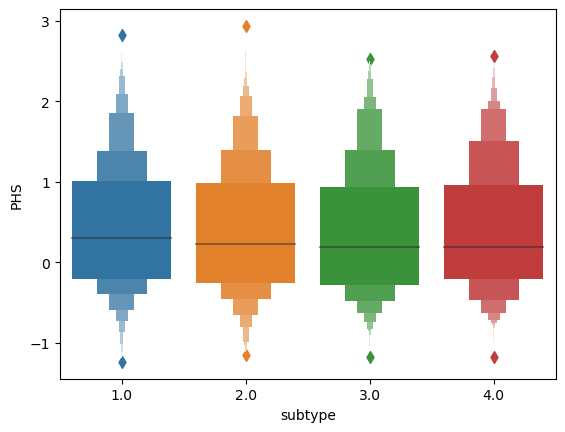

In [31]:
sns.boxenplot(data=df_prs2, x="subtype", y="PHS")

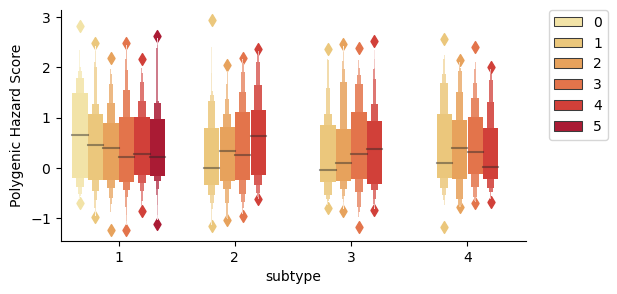

In [32]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(6,3))
test_name = "PHS"
df_prs2["stage"] = df_prs2["stage"].astype(int)
df_prs2["subtype"] = df_prs2["subtype"].astype(int)

sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="subtype", y="PHS", palette="YlOrRd", ax=ax, hue="stage")
ax.set_ylabel("Polygenic Hazard Score")
# ax.set_title(fld, fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax.legend(bbox_to_anchor=(1.05, 1.00), loc='upper left', borderaxespad=0, ncol=1)
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

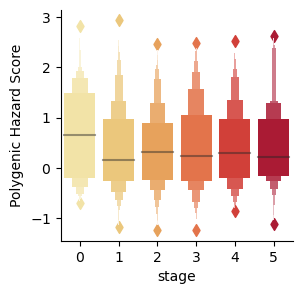

In [33]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(3,3))
test_name = "PHS"
df_prs2["stage"] = df_prs2["stage"].astype(int)
sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="stage", y="PHS", palette="YlOrRd", ax=ax)
ax.set_ylabel("Polygenic Hazard Score")
# ax.set_title(fld, fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [34]:
ravlt_trials = [-0.16,-0.30, -0.40, -0.51, -0.62, -0.82]

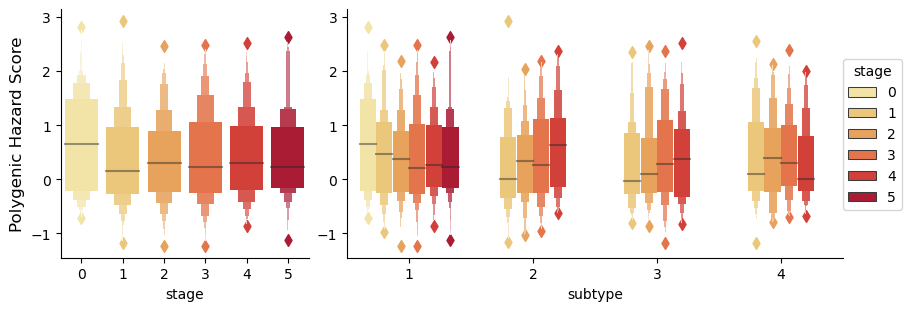

In [35]:
fig = plt.figure(figsize=(9, 3), layout="constrained")
spec = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(spec[0])
ax10 = fig.add_subplot(spec[1:])
sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="stage", y="PHS", palette="YlOrRd", ax=ax0)
sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="subtype", y="PHS", palette="YlOrRd", ax=ax10, hue="stage")
ax0.set_ylabel("Polygenic Hazard Score", fontsize=12)
ax10.set_ylabel("", fontsize=12)
ax0.spines[['right', 'top']].set_visible(False)
ax10.spines[['right', 'top']].set_visible(False)
# ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax10.legend(bbox_to_anchor=(1.0, 0.8), loc='upper left', borderaxespad=0, ncol=1, title="stage")
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [36]:
chi2_contingency(df_xx.groupby(["stage", "APOE4"]).size().unstack(level=1).fillna(0))

NameError: name 'df_xx' is not defined

In [37]:
print(results_phs.summary())

                            OLS Regression Results                            
Dep. Variable:                  stage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4141
Date:                Tue, 30 Jul 2024   Prob (F-statistic):              0.520
Time:                        11:39:06   Log-Likelihood:                -2343.9
No. Observations:                1453   AIC:                             4692.
Df Residuals:                    1451   BIC:                             4702.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4974      0.036     69.763      0.0

In [38]:
mci_solved

subtype  stage   DX        PTID   EXAMDATE VISCODE
0        0.0    3.0  2.0  002_S_0729 2007-02-22     m06
1        2.0    2.0  2.0  002_S_0782 2007-03-28     m06
2        1.0    4.0  2.0  002_S_0954 2007-05-03     m06
3        2.0    3.0  2.0  002_S_1070 2006-12-11      bl
4        3.0    4.0  2.0  002_S_1155 2011-12-23     m60
..       ...    ...  ...         ...        ...     ...
803      3.0    2.0  2.0  941_S_4100 2015-08-28     m48
804      0.0    1.0  2.0  941_S_4187 2011-08-25      bl
805      1.0    3.0  2.0  941_S_4377 2012-02-14      bl
806      0.0    2.0  2.0  941_S_4420 2012-04-03      bl
807      2.0    4.0  2.0  941_S_4764 2012-06-11      bl

[808 rows x 6 columns]

### Directory path

# Prepare Longitudinal Data  with subtypes and stages

In [48]:
# Functions for reading longitudinal data and subtyping/staging
def read_long(df_cnad, df_mci, k):
    long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle_adj.csv"
    df_long = pd.read_csv(long_path)
    df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])
    assert all(df_long.columns[:k] == df_cnad.columns[:k])
    cnad_ptid = df_cnad["PTID"].tolist()
    mci_ptid = df_mci["PTID"].tolist()
    df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
    df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]
    return df_long, df_long_cnad, df_long_mci

def subtype_stage(L_yes, L_no, pkl, n_stages, last_N=1000000, N_samples=1000):
    sustainData_mci_long = sEBMSustainData(L_yes, L_no, n_stages)
    samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
    samples_f = pkl["samples_f"][:,-last_N:]
    shape_seq = pkl["shape_seq"]
    temp_mean_f = np.mean(samples_f, axis=1)
    ix = np.argsort(temp_mean_f)[::-1]

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)
    return ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage

# Read the long df (MCI and CNAD)
k = 118
df_long, df_long_cnad, df_long_mci = read_long(df_cnad, df_mci, k)

# Get the prob_mat for MCI
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

# Subtype and Stage the MCI subjects and subset them for the relevant columns
ml_subtype_mci, prob_ml_subtype_mci, ml_stage_mci, \
prob_ml_stage_mci, prob_subtype_mci, prob_stage_mci, prob_subtype_stage_mci = subtype_stage(L_yes_mci_long, L_no_mci_long, pkl, n_stages)
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci
df_long_mci["RID"] = df_long_mci["sid"].apply(lambda x: int(x.split("_")[-1]))
df_long_mci["PTGENDER"] = df_long_mci["PTGENDER"].map({"Female":0, "Male":1})
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid", "RID", "AGE", "PTGENDER", "PTEDUCAT", "APOE4"]
df_long_mci_subset = df_long_mci[mci_subset]

In [49]:
prob_mat_cnad_long = mixture_model.get_prob_mat(df_long_cnad.iloc[:,:k].values, mixture_models)
L_no_cnad_long = prob_mat_cnad_long[:,:,0]
L_yes_cnad_long = prob_mat_cnad_long[:,:,1]
L_yes_cnad_long = process_L(L_yes_cnad_long)
L_no_cnad_long = process_L(L_no_cnad_long)
# Subtype and Stage the CN/AD subjects and subset them for the relevant columns
ml_subtype_cnad, prob_ml_subtype_cnad, ml_stage_cnad, \
prob_ml_stage_cnad, prob_subtype_cnad, prob_stage_cnad, prob_subtype_stage_cnad = subtype_stage(L_yes_cnad_long, L_no_cnad_long, pkl, n_stages)
df_long_cnad["subtype"] = ml_subtype_cnad
df_long_cnad["stage"] = ml_stage_cnad
df_long_cnad["RID"] = df_long_cnad["sid"].apply(lambda x: int(x.split("_")[-1]))
df_long_cnad["PTGENDER"] = df_long_cnad["PTGENDER"].map({"Female":0, "Male":1})
cnad_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid", "RID", "AGE", "PTGENDER", "PTEDUCAT", "APOE4"]
df_long_cnad_subset = df_long_cnad[cnad_subset]

In [50]:
df_long

3rd-Ventricle  4th-Ventricle   Brain-Stem  CC_Anterior  CC_Central  \
0       -466.244891    -757.156844   655.746528    29.748840    5.656936   
1       -559.244891    -780.156844   377.746528    26.748840   -0.343064   
2        636.116064    -158.929618   742.354873    35.662452   12.410384   
3        986.116064    -131.929618   343.354873     7.662452   10.410384   
4        703.116064    -279.929618   457.354873    11.662452   22.410384   
...             ...            ...          ...          ...         ...   
5544    1514.551114     997.362421  1133.820612  -206.495419  -50.354346   
5545    1505.551114    1407.362421   952.820612  -207.495419  -79.354346   
5546    1676.551114    1319.362421   640.820612  -253.495419  -84.354346   
5547    -250.695711    -530.111576   475.427535   187.465908   77.970915   
5548    -231.695711    -567.111576   966.427535   172.465908   99.970915   

      CC_Mid_Anterior  CC_Mid_Posterior  CC_Posterior         CSF  \
0           15.926647         44.492168   -104.026785  -44.067961   
1           11.926647         30.492168   -145.026785   -1.067961   
2           22.973607         -2.409478    -11.392500  114.047531   
3            2.973607        -15.409478    -12.392500  120.047531   
4            3.973607         -7.409478    -60.392500  116.047531   
...               ...               ...           ...         ...   
5544      -124.085538       -103.367136    -85.400551  407.603358   
5545      -118.085538        -94.367136    -95.400551  692.603358   
5546      -135.085538       -120.367136    -97.400551  594.603358   
5547        43.211247          8.563567     73.245354 -216.452212   
5548        58.211247          4.563567     53.245354  -60.452212   

         CortexVol  ...  DX_bl   EXAMDATE  PTEDUCAT  PTGENDER        PTID  \
0     37761.248283  ...     CN 2006-05-09        18      Male  002_S_0295   
1     40908.047083  ...     CN 2006-11-02        18      Male  002_S_0295   
2     75991.970407  ...     CN 2007-06-01        16    Female  002_S_0413   
3     53216.151707  ...     CN 2008-07-31        16    Female  002_S_0413   
4     67783.667407  ...     CN 2009-04-30        16    Female  002_S_0413   
...            ...  ...    ...        ...       ...       ...         ...   
5544  -8129.073221  ...   EMCI 2012-08-20        20    Female  941_S_4764   
5545   3015.774479  ...   EMCI 2013-06-10        20    Female  941_S_4764   
5546 -23016.564221  ...   EMCI 2014-06-16        20    Female  941_S_4764   
5547   5980.471884  ...    SMC 2013-06-11        16    Female  941_S_5193   
5548  -6284.409616  ...    SMC 2013-08-19        16    Female  941_S_5193   

      VISCODE  align_err_days     date         sid  Gender  
0          bl              21  4/18/06  002_S_0295       1  
1         m06               0  11/2/06  002_S_0295       1  
2         m12               0   6/1/07  002_S_0413       0  
3         m24               0  7/31/08  002_S_0413       0  
4         m36               4   5/4/09  002_S_0413       0  
...       ...             ...      ...         ...     ...  
5544      m03               0  8/20/12  941_S_4764       0  
5545      m12               0  6/10/13  941_S_4764       0  
5546      m24               0  6/16/14  941_S_4764       0  
5547       bl              13  5/29/13  941_S_5193       0  
5548      m03               0  8/19/13  941_S_5193       0  

[5549 rows x 131 columns]

In [51]:
df_long_all = pd.concat([df_long_cnad, df_long_mci], axis=0)

## Read the ADNIMERGE file 

In [52]:
# Read the ADNIMERGE file     
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)
df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])

In [53]:
df_adnimerge["ABETA"] = df_adnimerge["ABETA"].replace([">1700","<200"],[1700,200])
df_adnimerge["ABETA"] = df_adnimerge["ABETA"].astype(float)
df_adnimerge["TAU"] = df_adnimerge["TAU"].replace(["<80",">1300"],[80,1300])
df_adnimerge["TAU"] = df_adnimerge["TAU"].astype(float)
df_adnimerge["PTAU"] = df_adnimerge["PTAU"].replace(["<8", ">120"],[8,120])
df_adnimerge["PTAU"] = df_adnimerge["PTAU"].astype(float)

In [54]:
df_long_adnimerge = pd.merge(df_long_mci, df_adnimerge, on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_"])
df_long_adnimerge.sort_values(by=["PTID", "EXAMDATE"], inplace=True)
df_long_adnimerge["stage"] = df_long_adnimerge["stage"].astype(int)

In [55]:
df_long_all_adnimerge = pd.merge(df_long_all, df_adnimerge, on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_"])
df_long_all_adnimerge.sort_values(by=["PTID", "EXAMDATE"], inplace=True)
df_long_all_adnimerge["stage"] = df_long_all_adnimerge["stage"].astype(int)

In [56]:
palette_color1="YlOrRd"
palette_subtype="hls"

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.550e-01 U_stat=1.720e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.607e-01 U_stat=1.598e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.092e-01 U_stat=2.038e+04
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.344e-03 U_stat=1.478e+04
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.907e-02 U_stat=1.838e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-s

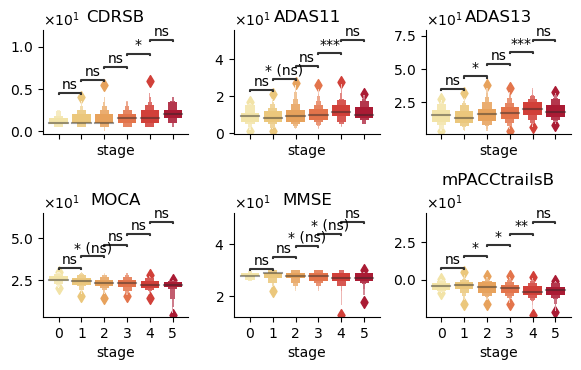

In [57]:
flds = ["CDRSB", "ADAS11", "ADAS13", "MOCA", "MMSE", "mPACCtrailsB"]

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5)]
fig, ax = plt.subplots(2,3, sharex=True, sharey=False, figsize=(6,4))
test_name = "composite_neuropsych_score_stat_annotator"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
    annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Benjamini-Hochberg")
    annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [58]:
box_props = dict(edgecolor="red")

# Individual fields (MOCA)

In [59]:
sns.__version__

'0.10.1'

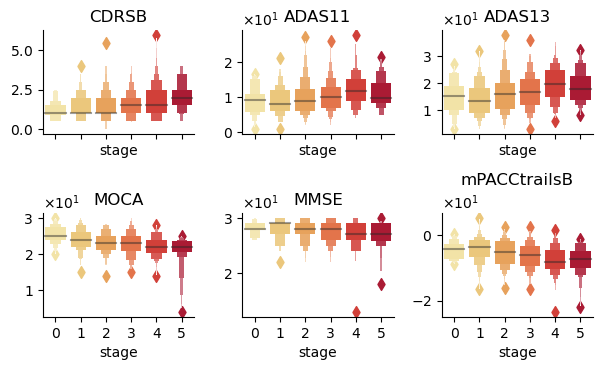

In [60]:
flds = ["CDRSB", "ADAS11", "ADAS13", "MOCA", "MMSE", "mPACCtrailsB"]
fig, ax = plt.subplots(2,3, sharex=True, sharey=False, figsize=(6,4))
test_name = "composite_neuropsych_score"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [61]:
test_name = "composite_neuropsych_score_stat"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage", "RID"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

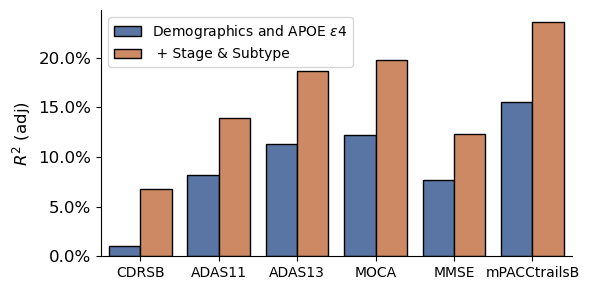

In [62]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=10,rotation=0)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=12)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = [r'Demographics and APOE $\varepsilon$4', ' + Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}_bar.png".format(test_name)), dpi=300)

In [63]:
df_xx

AGE  PTGENDER  PTEDUCAT  APOE4  stage   RID  mPACCtrailsB  st0  st1  \
0     65.1         0        16    1.0      3   729     -7.882890    1    0   
4     81.6         1        16    0.0      2   782     -0.981252    0    0   
8     69.3         0        14    1.0      4   954    -13.514500    0    1   
11    73.6         1        14    0.0      3  1070    -11.008000    0    0   
15    57.8         1        20    0.0      4  1155      0.817791    0    0   
...    ...       ...       ...    ...    ...   ...           ...  ...  ...   
2945  78.5         0        12    0.0      2  4100     -9.110660    0    0   
2946  62.0         1        16    0.0      1  4187     -3.860670    1    0   
2951  69.3         0        12    1.0      3  4377     -3.356650    0    1   
2955  81.4         1        18    0.0      2  4420     -6.392730    1    0   
2959  82.7         0        20    0.0      4  4764     -0.757850    0    0   

      st2  st3  
0       0    0  
4       1    0  
8       0    0  
11      1    0  
15      0    1  
...   ...  ...  
2945    0    1  
2946    0    0  
2951    0    0  
2955    0    0  
2959    1    0  

[808 rows x 11 columns]

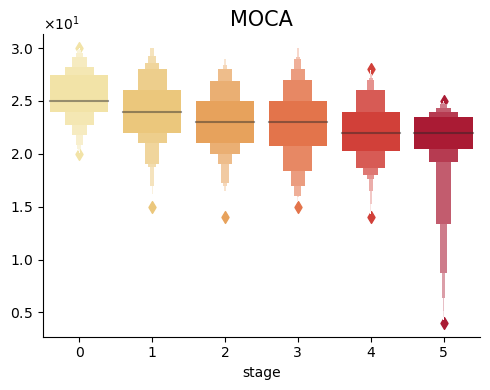

In [64]:
fld = "MOCA"
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(5,4))
test_name = "MOCA_test"
df_mh_fld = process_df(df_long_adnimerge, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax,palette=palette_color1)
ax.set_ylabel("")
ax.set_title(fld, fontsize=15)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [65]:
df_long_adnimerge["stage"]

0       3
1       3
2       3
3       4
4       2
       ..
2958    1
2959    4
2960    4
2961    5
2962    4
Name: stage, Length: 2963, dtype: int64

In [66]:
fld = "MOCA"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[cov1]))
results = model.fit()

In [67]:
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

## Median Regression (example)

In [68]:
model = smf.quantreg("MOCA ~ AGE + PTGENDER + APOE4 + PTEDUCAT + stage + st1 + st2 + st3", df_xx)
fld = "TAU"
df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
model = smf.quantreg("TAU ~ AGE + PTGENDER + APOE4 + PTEDUCAT + stage + st1 + st2 + st3", df_xx)
res = model.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    TAU   Pseudo R-squared:              0.09069
Model:                       QuantReg   Bandwidth:                       59.83
Method:                 Least Squares   Sparsity:                        257.7
Date:                Tue, 30 Jul 2024   No. Observations:                  551
Time:                        12:05:45   Df Residuals:                      542
                                        Df Model:                            8
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     32.1017     67.353      0.477      0.634    -100.203     164.406
AGE            3.7511      0.758      4.948      0.000       2.262       5.240
PTGENDER     -28.8886     11.582     -2.494      0.013     -51.639      -6.138
APOE4         59.3978      8.286      7.169      0.0

In [69]:
1 - np.square(df_xx[fld] - np.ceil(results.predict(sm.add_constant(df_xx[cov1])))).sum()/(np.var(df_xx[[fld]])*(df_xx.shape[0]-1))


TAU   -3.673617
dtype: float64

In [70]:
np.var(df_xx[[fld]])

TAU    18739.415455
dtype: float64

In [71]:
results.predict()

array([25.10416568, 26.26287534, 24.559045  , 26.91645387, 22.9187606 ,
       24.08864921, 23.23523769, 22.7761905 , 25.66551175, 24.12482633,
       23.47084023, 24.11096692, 25.08266115, 24.17781109, 23.99031836,
       24.63861867, 23.82835742, 22.74800555, 22.10616901, 22.70503526,
       22.50054189, 22.4907442 , 22.47782688, 21.79844269, 23.91305521,
       24.6395463 , 24.37417658, 20.26285557, 22.44053923, 24.38123142,
       22.2019511 , 21.96332186, 25.18165342, 23.02950865, 23.04834872,
       21.64746261, 22.09300913, 23.47974541, 25.65261067, 22.23184874,
       22.20706724, 25.40988063, 20.35141019, 23.66312568, 20.55026848,
       24.69497311, 25.62322449, 22.3808674 , 24.79553055, 22.33475339,
       22.81251227, 22.17921552, 23.10029066, 23.29376008, 22.00038281,
       21.26730818, 23.45245754, 21.81632225, 22.70550333, 21.4293822 ,
       21.95612481, 22.46223322, 19.73393533, 24.94482675, 22.07749305,
       21.50911571, 25.3453688 , 24.38124212, 21.91140132, 24.58

## EcogPT/SP scores

### Study Partner (SP) and Patient (Pt)

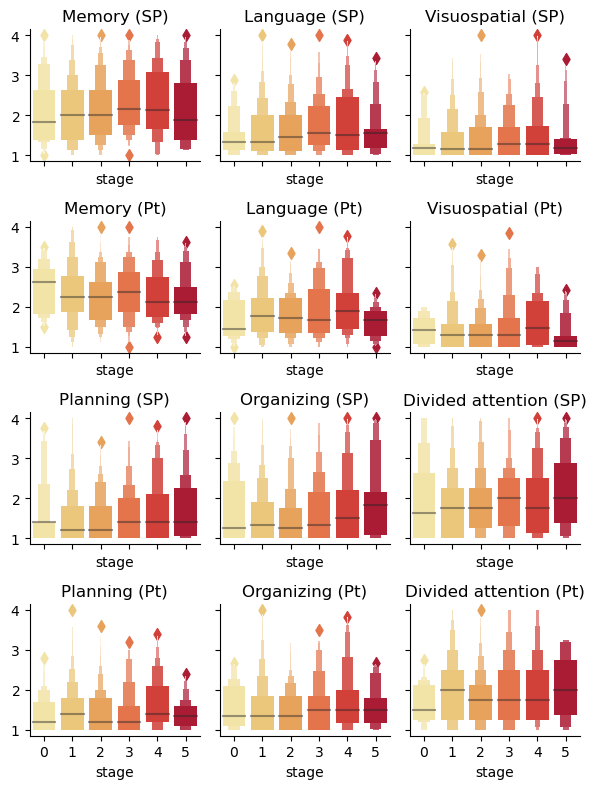

In [72]:
flds = ["EcogSPMem", "EcogSPLang", "EcogSPVisspat"] + ["EcogPtMem", "EcogPtLang", "EcogPtVisspat"] + \
["EcogSPPlan","EcogSPOrgan", "EcogSPDivatt"] + ["EcogPtPlan","EcogPtOrgan", "EcogPtDivatt"]

flds_title = {"EcogSPMem":"Memory (SP)", "EcogSPLang":"Language (SP)", "EcogSPVisspat":"Visuospatial (SP)", 
              "EcogPtMem":"Memory (Pt)", "EcogPtLang":"Language (Pt)", "EcogPtVisspat":"Visuospatial (Pt)",
             "EcogPtPlan":"Planning (Pt)","EcogPtOrgan": "Organizing (Pt)", "EcogPtDivatt":"Divided attention (Pt)", 
             "EcogSPPlan":"Planning (SP)","EcogSPOrgan": "Organizing (SP)", "EcogSPDivatt":"Divided attention (SP)"}
fig, ax = plt.subplots(4,3, sharex=True, sharey=True, figsize=(6,8))
test_name = "Everyday-Cognition-sub-items"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(flds_title[fld], fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [73]:
test_name = "EcogSP_summary_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

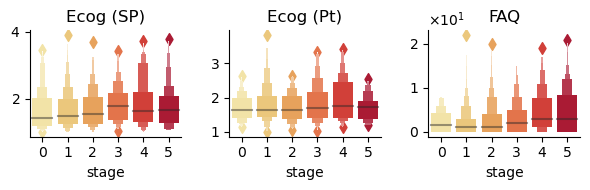

In [74]:
flds = ["EcogSPTotal", "EcogPtTotal", "FAQ"]


flds_title = {"EcogSPTotal":"Ecog (SP)", 
              "EcogPtTotal":"Ecog (Pt)",
              "FAQ":"FAQ"}
fig, ax = plt.subplots(1,3, sharex=True, sharey=False, figsize=(6,2))
test_name = "Ecog_FAQ"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
    ax[c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Study Participant (Pt)

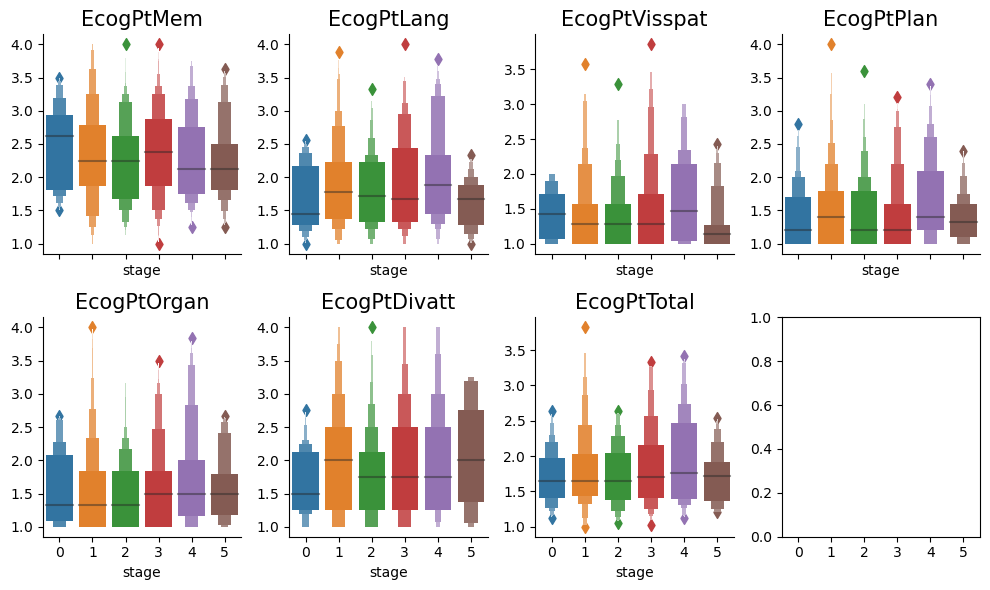

In [76]:
flds = ["EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan",
        "EcogPtOrgan", "EcogPtDivatt", "EcogPtTotal"]

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5)]
fig, ax = plt.subplots(2,4, sharex=True, sharey=False, figsize=(10,6))
test_name = "EcogPT"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//4
    c = _%4
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
#     annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
#     annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
#     annotator.configure(test='Mann-Whitney', text_format='star', 
#                         loc='inside',comparisons_correction="Benjamini-Hochberg")
#     annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [77]:
test_name = "EcogPT_summary_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

## CSF markers

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.475e-01 U_stat=1.301e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.344e-01 U_stat=9.323e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.150e-01 U_stat=1.002e+04
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.952e-02 (ns) U_stat=7.663e+03
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.989e-01 U_stat=1.093e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test 

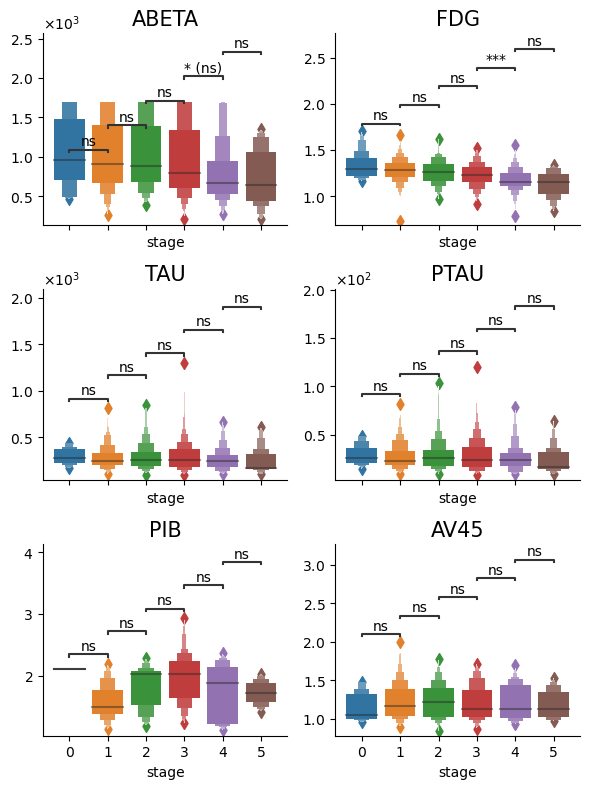

In [78]:
flds = ["ABETA","FDG","TAU","PTAU","PIB","AV45"]
fig, ax = plt.subplots(3,2, sharex=True, sharey=False, figsize=(6,8))
test_name = "CSF_markers_annotation"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//2
    c = _%2
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
    annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Benjamini-Hochberg")
    annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

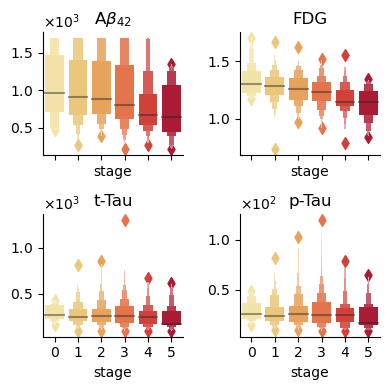

In [79]:
flds = ["ABETA","FDG","TAU","PTAU"]
fld_titles = {"ABETA":r'A$\beta_{42}$', "FDG":"FDG", "PTAU":"p-Tau", "TAU":"t-Tau"}
fig, ax = plt.subplots(2,2, sharex=True, sharey=False, figsize=(4,4))
test_name = "CSF_markers"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//2
    c = _%2
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld_titles[fld], fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

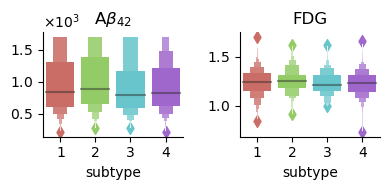

In [80]:
flds = ["ABETA", "FDG"]
fld_titles = {"ABETA":r'A$\beta_{42}$', "FDG":"FDG", "PTAU":"p-Tau", "TAU":"t-Tau"}
fig, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(4,2))
test_name = "csf-subtypes"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    df_mh_fld["subtype"] += 1
    df_mh_fld["subtype"] = df_mh_fld["subtype"].astype(int)
    c = _%2
    sns.boxenplot(data=df_mh_fld, y=fld, ax=ax[c], x="subtype",
                  palette=palette_subtype)
    ax[c].set_ylabel("")
    ax[c].set_title(fld_titles[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
    ax[c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [81]:
# Adjusting FDG levels for age, gender, educat, apoe4 and stage
fld = "ABETA"
df_xx = regress_score(df_long_adnimerge,
                      fld, ["RID","AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
df_xx.reset_index(drop=True, inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"]]))
results = model.fit()



In [82]:
df_xx["subtype"] = pd.from_dummies(df_xx[["st0","st1","st2","st3"]])
df_xx["subtype"] = df_xx["subtype"].map({"st0":0,"st1":1,"st2":2,"st3":3})
df_xx["subtype"] += 1

KruskalResult(statistic=7.3372183749952455, pvalue=0.06189187960696002)

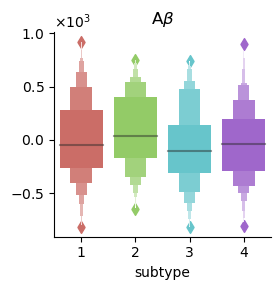

In [83]:
df_xx["resid"] = results.resid
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "abeta-adj-subtypes"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
ax.set_ylabel("")
ax.set_title(r'A$\beta$', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

1 vs. 2: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:2.192e-01 Stat=1.510e+00
2 vs. 3: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:1.156e-01 Stat=2.476e+00
3 vs. 4: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:6.447e-01 Stat=2.126e-01
2 vs. 4: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:2.037e-01 Stat=1.615e+00
1 vs. 3: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:4.945e-01 Stat=4.668e-01
1 vs. 4: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:8.433e-01 S

KruskalResult(statistic=7.3372183749952455, pvalue=0.06189187960696002)

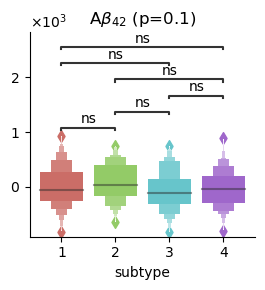

In [84]:
df_xx["resid"] = results.resid
pairs = [(1,2),(2,3),(3,4),(2,4),(1,3),(1,4)]
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "abeta-adj-subtypes-annotat"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
annotator = Annotator(ax, pairs, data=df_xx, x="subtype", y=fld)
annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
annotator.configure(test='Kruskal', text_format='star', 
                    loc='inside',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()

ax.set_ylabel("")
ax.set_title(r'A$\beta_{42}$ (p=0.1)', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# ax.set_ylim([-1,1])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

In [85]:
# Adjusting FDG levels for age, gender, educat, apoe4 and stage
fld = "FDG"
df_xx = regress_score(df_long_adnimerge,
                      fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
df_xx.reset_index(drop=True, inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"]]))
results = model.fit()


In [86]:
df_xx["subtype"] = pd.from_dummies(df_xx[["st0","st1","st2","st3"]])
df_xx["subtype"] = df_xx["subtype"].map({"st0":0,"st1":1,"st2":2,"st3":3})
df_xx["subtype"] += 1

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.030e-01 U_stat=1.603e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.396e-01 U_stat=6.695e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.411e-01 U_stat=5.985e+03
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.128e-01 U_stat=7.988e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.322e-01 U_stat=1.486e+04
1 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.616e-01 U_stat=1.778e+04


KruskalResult(statistic=6.831934173116451, pvalue=0.07745196492361987)

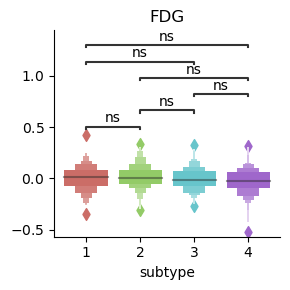

In [87]:
df_xx["resid"] = results.resid
pairs = [(1,2),(2,3),(3,4),(2,4),(1,3),(1,4)]
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "fgd-adj-subtypes-annotat"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
annotator = Annotator(ax, pairs, data=df_xx, x="subtype", y=fld)
annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
annotator.configure(test='Mann-Whitney', text_format='star', 
                    loc='inside',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()

ax.set_ylabel("")
ax.set_title(r'FDG', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# ax.set_ylim([-1,1])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

In [88]:
ucb_fdg_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/biospecimens/UPENNBIOMK_ROCHE_ELECSYS_17May2024.csv"
ucb_fdg_df = pd.read_csv(ucb_fdg_path)
ucb_fdg_df.replace("sc","bl",inplace=True)
ucb_fdg_df2 = pd.merge(df_long_mci, ucb_fdg_df, left_on=["RID", "VISCODE"], right_on=["RID", "VISCODE2"],
         how="inner", suffixes=[None,"_"])
ucb_fdg_df2.sort_values(by=["RID", "EXAMDATE"], inplace=True)
ucb_fdg_df2.drop_duplicates("RID", inplace=True)


In [89]:
ucb_fdg_df2[["ABETA42","RID"]]

ABETA42   RID
180   1176.0     4
327    673.0    33
450    874.1    38
54     414.6    41
451    383.3    45
..       ...   ...
145    635.6  5031
598   1001.0  5047
179   2185.0  5099
277    746.8  5135
469   1213.0  5160

[554 rows x 2 columns]

In [90]:
xyz = pd.merge(df_xx[["RID","ABETA"]],ucb_fdg_df2[["ABETA42","RID"]],on="RID")
xyz[xyz["ABETA"] != xyz["ABETA42"]]

KeyError: "None of [Index(['RID', 'ABETA'], dtype='object')] are in the [columns]"

In [91]:
fld = "ABETA42"
df_xx = regress_score(ucb_fdg_df2,
                      fld, ["RID","AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
df_xx.reset_index(drop=True, inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"]]))
results = model.fit()

In [92]:
df_xx["subtype"] = pd.from_dummies(df_xx[["st0","st1","st2","st3"]])
df_xx["subtype"] = df_xx["subtype"].map({"st0":0,"st1":1,"st2":2,"st3":3})
df_xx["subtype"] += 1

In [93]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ABETA42   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     44.48
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           1.59e-38
Time:                        12:09:58   Log-Likelihood:                -4194.7
No. Observations:                 554   AIC:                             8401.
Df Residuals:                     548   BIC:                             8427.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2739.6938    244.294     11.215      0.0

KruskalResult(statistic=8.310876688238977, pvalue=0.04000530514736107)

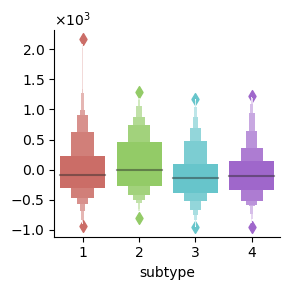

In [94]:
df_xx["resid"] = results.resid
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "abeta-upenn-adj-subtypes"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
ax.set_ylabel("")
# ax.set_title(r'F (p=0.01)', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# ax.set_ylim([-.3,.3])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

In [95]:
# UC Berkely  (FDG data)

In [96]:
ucb_fdg_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/biospecimens/UCBERKELEYFDG_03_25_22_17May2024.csv"
ucb_fdg_df = pd.read_csv(ucb_fdg_path)
ucb_fdg_df.replace("sc","bl",inplace=True)
ucb_fdg_df2 = pd.merge(df_long_mci, ucb_fdg_df, left_on=["RID", "VISCODE"], right_on=["RID", "VISCODE2"],
         how="inner", suffixes=[None,"_"])
ucb_fdg_df2.sort_values(by=["RID", "EXAMDATE"], inplace=True)
ucb_fdg_df2_meta = ucb_fdg_df2[ucb_fdg_df2["ROINAME"]=="metaroi"]
ucb_fdg_df2_pons = ucb_fdg_df2[ucb_fdg_df2["ROINAME"]=="pons-vermis"]

In [97]:
ucb_fdg_df2_meta.drop_duplicates("RID", inplace=True)
ucb_fdg_df2_pons.drop_duplicates("RID", inplace=True)


In [98]:
ucb_fdg_df2_pons.shape

(618, 145)

# ANOVA for studying effects from stages and subtypes

In [99]:
from statsmodels.formula.api import ols
# model_anova = ols('resid ~ C(stage) + C(subtype) + C(stage):C(subtype)', data=df_xx).fit()
model_anova = ols('resid ~ C(stage) + C(subtype)', data=df_xx).fit()

In [100]:
sm.stats.anova_lm(model_anova, typ=2)

sum_sq     df         F    PR(>F)
C(stage)    1.711036e+06    5.0  1.570303  0.166619
C(subtype)  1.743529e+06    3.0  2.666872  0.047062
Residual    1.187688e+08  545.0       NaN       NaN

In [101]:
test_name = "CSF_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_long_adnimerge, fld)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_obj = spearmanr(df_mh_fld["stage"], df_mh_fld[fld])
    spearman_corr = spearmanr_obj.correlation
    spearman_pval = spearmanr_obj.pvalue
    
    neurobat_dict[fld] = [chi2_pval, spearman_corr, spearman_pval, n_samples]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", 
                                     columns = ["chi-2-pval", "spearmanr", "spearmanp", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape ABETA (551, 245)
Shape FDG (618, 245)


In [102]:
test_name = "CSF_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# Brain region volumes

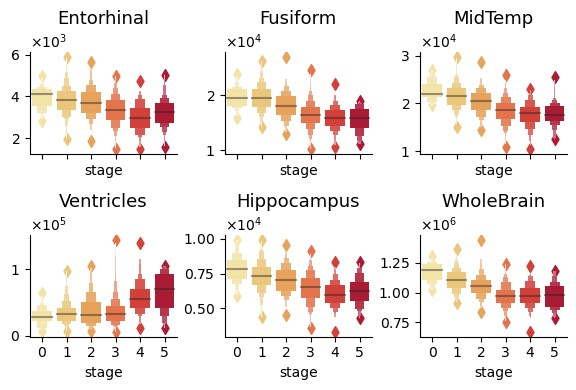

In [103]:
test_name = "Vol_test"
flds =  ["Entorhinal", "Fusiform", "MidTemp", "Ventricles", "Hippocampus", "WholeBrain"]
fig, ax = plt.subplots(2,3, sharex=True, sharey=False, figsize=(6,4))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], 
                  palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=13)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# fig.supylabel("Volume", fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [104]:
test_name = "vol_test_bar"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

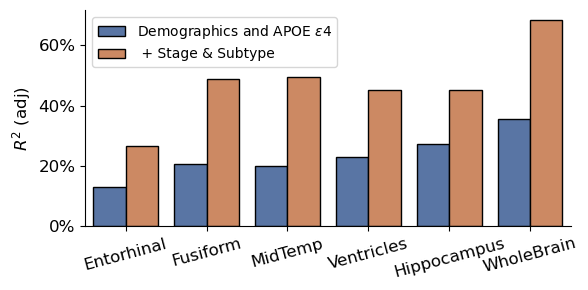

In [105]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k', 
            order=["Entorhinal", "Fusiform", "MidTemp", "Ventricles", "Hippocampus", "WholeBrain"])
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12,rotation=15)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=12)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = [r'Demographics and APOE $\varepsilon$4', ' + Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

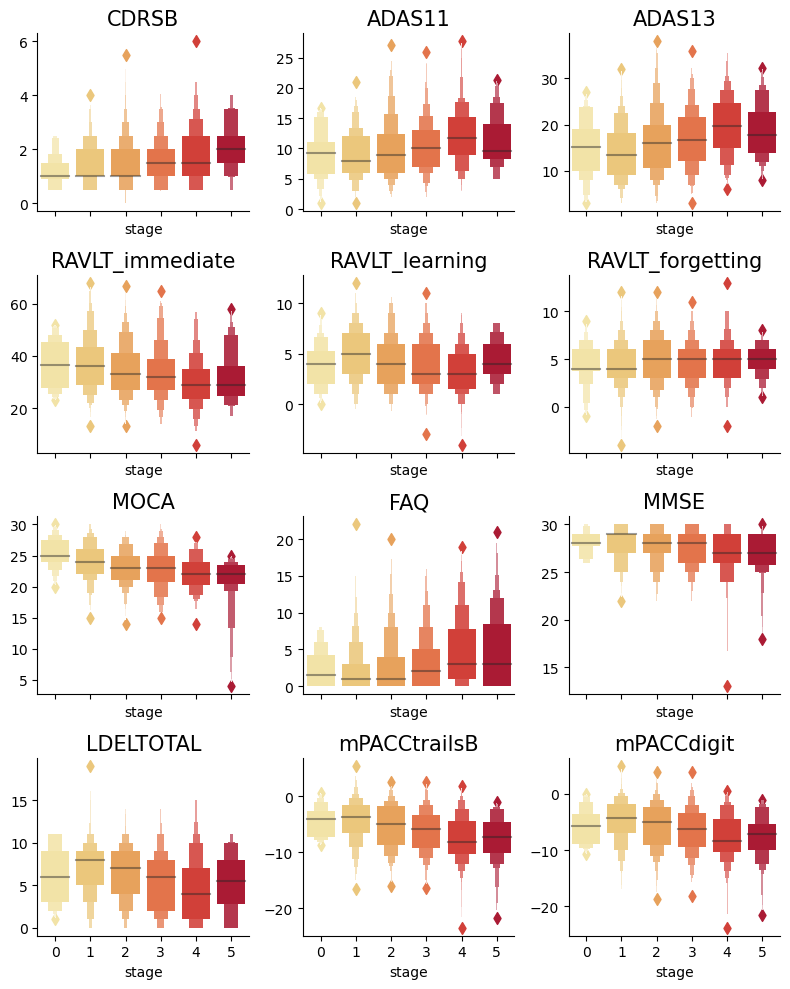

In [106]:
test_name = "adnimerge_cog"
flds = ["CDRSB", "ADAS11", "ADAS13"] + ["RAVLT_immediate","RAVLT_learning",
        "RAVLT_forgetting"] + ["MOCA", "FAQ","MMSE"] + ["LDELTOTAL", "mPACCtrailsB", "mPACCdigit"]
fig, ax = plt.subplots(4,3, sharex=True, sharey=False, figsize=(8,10))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
#     if fld in ["RAVLT_forgetting"]:
#         df_mh_fld = df_mh_fld[fld]
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c],
                 palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [107]:
test_name = "adnimerge_cog_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

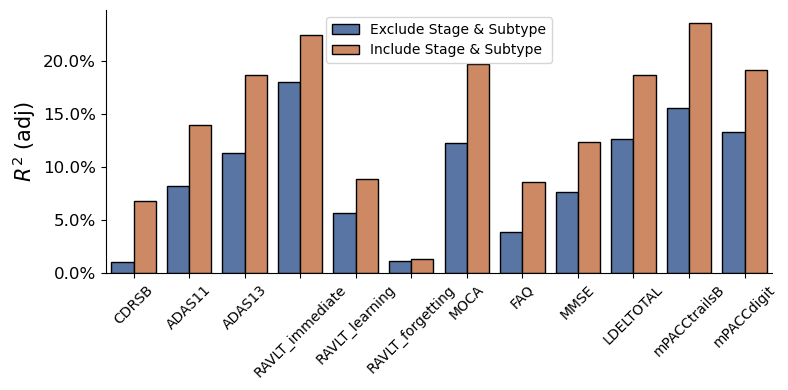

In [108]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=10,rotation=45)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=15)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = ['Exclude Stage & Subtype', 'Include Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}_bar.png".format(test_name)), dpi=300)

# Relations between subtypes and Ethnicity, Race, Marry etc

In [384]:
df_long_all_adnimerge

3rd-Ventricle  4th-Ventricle   Brain-Stem  CC_Anterior  CC_Central  \
0       -466.244891    -757.156844   655.746528    29.748840    5.656936   
1       -559.244891    -780.156844   377.746528    26.748840   -0.343064   
2        636.116064    -158.929618   742.354873    35.662452   12.410384   
3        986.116064    -131.929618   343.354873     7.662452   10.410384   
4        703.116064    -279.929618   457.354873    11.662452   22.410384   
...             ...            ...          ...          ...         ...   
5407    1514.551114     997.362421  1133.820612  -206.495419  -50.354346   
5408    1505.551114    1407.362421   952.820612  -207.495419  -79.354346   
5409    1676.551114    1319.362421   640.820612  -253.495419  -84.354346   
2445    -250.695711    -530.111576   475.427535   187.465908   77.970915   
2446    -231.695711    -567.111576   966.427535   172.465908   99.970915   

      CC_Mid_Anterior  CC_Mid_Posterior  CC_Posterior         CSF  \
0           15.926647         44.492168   -104.026785  -44.067961   
1           11.926647         30.492168   -145.026785   -1.067961   
2           22.973607         -2.409478    -11.392500  114.047531   
3            2.973607        -15.409478    -12.392500  120.047531   
4            3.973607         -7.409478    -60.392500  116.047531   
...               ...               ...           ...         ...   
5407      -124.085538       -103.367136    -85.400551  407.603358   
5408      -118.085538        -94.367136    -95.400551  692.603358   
5409      -135.085538       -120.367136    -97.400551  594.603358   
2445        43.211247          8.563567     73.245354 -216.452212   
2446        58.211247          4.563567     53.245354  -60.452212   

         CortexVol  ...  TAU_bl  PTAU_bl   FDG_bl  PIB_bl   AV45_bl  Years_bl  \
0     37761.248283  ...   355.2    34.73      NaN     NaN       NaN  0.000000   
1     40908.047083  ...   355.2    34.73      NaN     NaN       NaN  0.484600   
2     75991.970407  ...   107.3    10.57      NaN     NaN       NaN  1.065020   
3     53216.151707  ...   107.3    10.57      NaN     NaN       NaN  2.231350   
4     67783.667407  ...   107.3    10.57      NaN     NaN       NaN  2.978780   
...            ...  ...     ...      ...      ...     ...       ...       ...   
5407  -8129.073221  ...   295.5    27.57  1.36562     NaN  1.221260  0.191650   
5408   3015.774479  ...   295.5    27.57  1.36562     NaN  1.221260  0.996578   
5409 -23016.564221  ...   295.5    27.57  1.36562     NaN  1.221260  2.012320   
2445   5980.471884  ...   148.5    12.32  1.38033     NaN  0.992921  0.000000   
2446  -6284.409616  ...   148.5    12.32  1.38033     NaN  0.992921  0.188912   

      Month_bl  Month   M           update_stamp  
0      0.00000      0   0  2019-02-14 23:58:29.0  
1      5.80328      6   6  2019-02-14 23:58:29.0  
2     12.75410     12  12  2019-02-14 23:58:30.0  
3     26.72130     24  24  2019-02-14 23:58:30.0  
4     35.67210     36  36  2019-02-14 23:58:30.0  
...        ...    ...  ..                    ...  
5407   2.29508      3   3  2019-02-14 23:58:43.0  
5408  11.93440     12  12  2019-02-14 23:58:43.0  
5409  24.09840     24  24  2019-02-14 23:58:43.0  
2445   0.00000      0   0  2019-02-14 23:58:44.0  
2446   2.26230      3   3  2019-02-14 23:58:44.0  

[5410 rows x 245 columns]

In [383]:
# PTGENDER, #PTMARRY
fld = "PTMARRY"
df_mh_fld = process_df(df_long_all_adnimerge, fld,"first")
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_contingency(chi2_table)

KeyError: 'first'

In [385]:
chi2_table

PTGENDER  1.0  2.0
subtype           
0.0       379  312
1.0       148  121
2.0       123  111
3.0       148   91

In [111]:
chi2_table.sum().sum()

1658.0

In [113]:
df_mh_fld["APOE4"]

0       1.0
2       0.0
5       1.0
6       2.0
7       0.0
       ... 
2441    0.0
5398    1.0
5402    0.0
5406    0.0
2445    0.0
Name: APOE4, Length: 1658, dtype: float64

# Demographics (Age, gender, education APOE4)

In [114]:
df_mci_demo = pd.merge(mci_solved, df_mci[["PTID", "APOE4", "PTGENDER", "PTEDUCAT", "AGE"]], left_on="PTID", right_on="PTID", how="inner")
df_cnad_demo = pd.merge(cnad_solved, df_cnad[["PTID", "APOE4", "PTGENDER", "PTEDUCAT", "AGE"]], left_on="PTID", right_on="PTID", how="inner")
df_demo = pd.concat([df_cnad_demo, df_mci_demo], axis=0)         

In [115]:
df_demo

subtype  stage   DX        PTID   EXAMDATE VISCODE  APOE4 PTGENDER  \
0        1.0    1.0  0.0  002_S_0295 2006-05-09      bl    1.0     Male   
1        0.0    1.0  0.0  002_S_0413 2007-06-01     m12    0.0   Female   
2        0.0    0.0  0.0  002_S_0559 2006-06-20      bl    1.0     Male   
3        3.0    2.0  1.0  002_S_0619 2006-12-13     m06    2.0     Male   
4        3.0    2.0  0.0  002_S_0685 2010-07-15     m48    0.0   Female   
..       ...    ...  ...         ...        ...     ...    ...      ...   
803      3.0    2.0  2.0  941_S_4100 2015-08-28     m48    0.0   Female   
804      0.0    1.0  2.0  941_S_4187 2011-08-25      bl    0.0     Male   
805      1.0    3.0  2.0  941_S_4377 2012-02-14      bl    1.0   Female   
806      0.0    2.0  2.0  941_S_4420 2012-04-03      bl    0.0     Male   
807      2.0    4.0  2.0  941_S_4764 2012-06-11      bl    0.0   Female   

     PTEDUCAT   AGE  
0          18  84.8  
1          16  76.3  
2          16  79.3  
3          12  77.5  
4          16  89.6  
..        ...   ...  
803        12  78.5  
804        16  62.0  
805        12  69.3  
806        18  81.4  
807        20  82.7  

[1658 rows x 10 columns]

In [116]:
df_cnad

3rd-Ventricle  4th-Ventricle   Brain-Stem  CC_Anterior  CC_Central  \
0      -466.244891    -757.156844   655.746528    29.748840    5.656936   
1       636.116064    -158.929618   742.354873    35.662452   12.410384   
2       624.783089    1122.902794  3526.215533   159.866709   18.720675   
3      2982.509499    1119.966321  -517.395723   -78.729756 -109.657223   
4      1335.457276    -267.792766   984.600558   125.850357   15.948526   
..             ...            ...          ...          ...         ...   
845    -810.980397    -322.980235 -3209.678845   154.483510   21.764796   
846    -902.654477    -184.144284 -1461.844897   312.665145   86.510582   
847      98.359463     852.432539  1128.157875  -130.262414   27.900789   
848     144.790368     264.922064  1466.772102   -82.906151   48.959830   
849    -250.695711    -530.111576   475.427535   187.465908   77.970915   

     CC_Mid_Anterior  CC_Mid_Posterior  CC_Posterior          CSF  \
0          15.926647         44.492168   -104.026785   -44.067961   
1          22.973607         -2.409478    -11.392500   114.047531   
2          53.126370         28.296787    104.363310  -438.779930   
3        -115.247085        -78.586707   -121.168558  1832.309905   
4          30.141871         22.184867     19.875010  -176.703370   
..               ...               ...           ...          ...   
845        22.136820        -17.725843      1.021519    -3.082094   
846       109.856073        152.493327     67.524527  -149.827559   
847        56.602485         40.858817    109.029464   462.761868   
848       -13.302058        -42.829112     60.573929  -144.610378   
849        43.211247          8.563567     73.245354  -216.452212   

        CortexVol  ...  DX_bl   EXAMDATE  PTEDUCAT  PTGENDER        PTID  \
0    37761.248283  ...     CN 2006-05-09        18      Male  002_S_0295   
1    75991.970407  ...     CN 2007-06-01        16    Female  002_S_0413   
2    20373.904734  ...     CN 2006-06-20        16      Male  002_S_0559   
3    61289.534200  ...     AD 2006-12-13        12      Male  002_S_0619   
4     6515.580835  ...     CN 2010-07-15        16    Female  002_S_0685   
..            ...  ...    ...        ...       ...       ...         ...   
845  27729.955843  ...     CN 2011-11-14        16      Male  941_S_4255   
846 -13796.051910  ...     CN 2011-12-20        15      Male  941_S_4292   
847  23930.135063  ...     CN 2012-01-05        20      Male  941_S_4365   
848 -16176.675292  ...     CN 2012-01-19        16    Female  941_S_4376   
849   5980.471884  ...    SMC 2013-06-11        16    Female  941_S_5193   

     VISCODE  align_err_days      date         sid  Gender  
0         bl              21   4/18/06  002_S_0295       1  
1        m12               0    6/1/07  002_S_0413       0  
2         bl              28   5/23/06  002_S_0559       1  
3        m06               0  12/13/06  002_S_0619       1  
4        m48               0   7/15/10  002_S_0685       0  
..       ...             ...       ...         ...     ...  
845       bl              38   10/7/11  941_S_4255       1  
846       bl              15   12/5/11  941_S_4292       1  
847       bl              44  11/22/11  941_S_4365       1  
848       bl              13    1/6/12  941_S_4376       0  
849       bl              13   5/29/13  941_S_5193       0  

[850 rows x 131 columns]

In [117]:
df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1) 

APOE4    0.0  1.0  2.0
subtype               
0.0      412  304   81
1.0      158  121   28
2.0      164   97   28
3.0      143   92   30

# APOE4 allele frequency

In [118]:
np.dot(df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1), [0,1,2])/(2*df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1).sum(axis=1))

subtype
0.0    0.292346
1.0    0.288274
2.0    0.264706
3.0    0.286792
dtype: float64

In [119]:
chi2_table = df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1).fillna(0)
chi2_contingency(chi2_table)

(3.9968035483186903,
 0.6771090087845869,
 6,
 array([[421.57358263, 295.1495778 ,  80.27683957],
        [162.38781665, 113.68998794,  30.92219542],
        [152.86670688, 107.02412545,  29.10916767],
        [140.17189385,  98.13630881,  26.69179735]]))

## Education and Age

In [120]:
[(name, group["AGE"].std()) for name, group in df_demo.groupby("subtype")]

[(0.0, 7.209060122226704),
 (1.0, 6.890626876685394),
 (2.0, 7.073655152905199),
 (3.0, 7.226125157462284)]

In [121]:
kruskal(*[group["AGE"].values for name, group in df_demo.groupby("subtype")])

KruskalResult(statistic=5.62088853340709, pvalue=0.131584300206491)

<AxesSubplot: xlabel='subtype', ylabel='PTEDUCAT'>

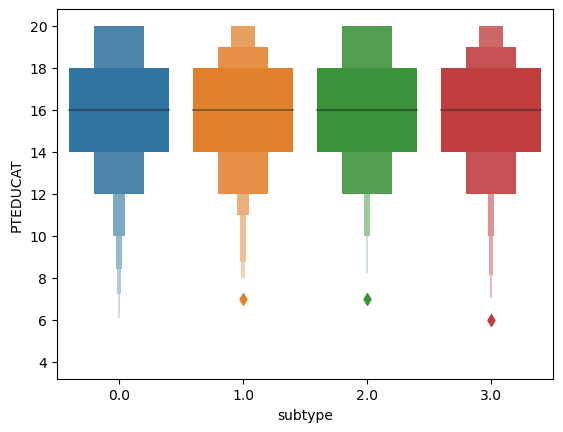

In [122]:
sns.boxenplot(data=df_demo, x="subtype",y="PTEDUCAT")

In [123]:
df_st0 = df_demo[df_demo["subtype"]==0]
df_st1 = df_demo[df_demo["subtype"]==1]
df_st2 = df_demo[df_demo["subtype"]==2]
df_st3 = df_demo[df_demo["subtype"]==3]

In [124]:
demo_x = "PTEDUCAT"
kruskal(df_st0[demo_x], df_st1[demo_x], df_st2[demo_x],df_st3[demo_x])

KruskalResult(statistic=3.505010483133152, pvalue=0.32011285914669263)

# Prepare data for StatsModel

In [125]:
def regress_score(df, field, covariates, examdate="EXAMDATE", n_subtypes=4):
    subtypes = list(range(n_subtypes))
    df_fld = df.dropna(subset=[field])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    one_hot_cols = pd.get_dummies(df_fld["subtype"])
    one_hot_cols = one_hot_cols[subtypes]
    new_cols = ["st{}".format(_) for _ in subtypes]
    one_hot_cols.columns = new_cols
    df_one_hot = pd.concat([df_fld[covariates+[field]], one_hot_cols], axis=1)
    return df_one_hot

def process_df(df, fld, examdate="EXAMDATE"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    return df_fld

def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

# Process data for filtering operations

## OLS regression function

In [126]:
def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

## Logistic regression function

In [127]:
def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

# NeuroBAT

In [128]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NEUROBAT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

# Trail Tests

### Regression Models

In [129]:
flds = ["TRAASCOR","TRAAERRCOM","TRAAERROM","TRABSCOR","TRABERRCOM","TRABERROM"]
test_name = "trail_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [131]:
flds = ["TRAASCOR","TRAAERRCOM","TRAAERROM","TRABSCOR","TRABERRCOM","TRABERROM"]
test_name = "trail_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", 
                                     columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape TRAASCOR (808, 96)
Shape TRAAERRCOM (808, 96)
Shape TRAAERROM (808, 96)
Shape TRABSCOR (806, 96)
Shape TRABERRCOM (804, 96)
Shape TRABERROM (804, 96)


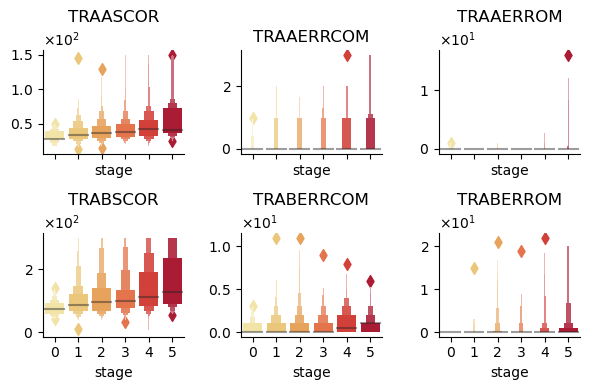

In [132]:
nrows=2
ncols=3
fig, ax = plt.subplots(nrows,ncols, sharex=True, sharey=False, figsize=(6,4))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//ncols
    c = _%ncols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], 
                  palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

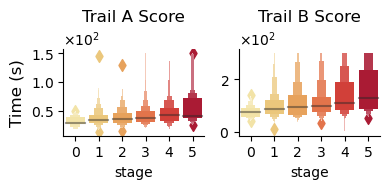

In [133]:
flds = ["TRAASCOR","TRABSCOR"]
fld_title = {"TRAASCOR":"Trail A Score", "TRABSCOR":"Trail B Score"}
test_name = "trail_A_B_test"
nrows=1
ncols=2
fig, ax = plt.subplots(nrows,ncols, sharex=True, sharey=False, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    c = _%ncols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], 
                  palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(fld_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
    ax[c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Time (s)", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### RAVLT

In [134]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape AVTOT1 (808, 96)
Shape AVTOT2 (808, 96)
Shape AVTOT3 (808, 96)
Shape AVTOT4 (808, 96)
Shape AVTOT5 (808, 96)
Shape AVTOT6 (808, 96)
Shape AVTOTB (808, 96)
Shape AVERR1 (808, 96)
Shape AVERR2 (808, 96)
Shape AVERR3 (808, 96)
Shape AVERR4 (808, 96)
Shape AVERR5 (808, 96)
Shape AVERR6 (808, 96)
Shape AVERRB (808, 96)


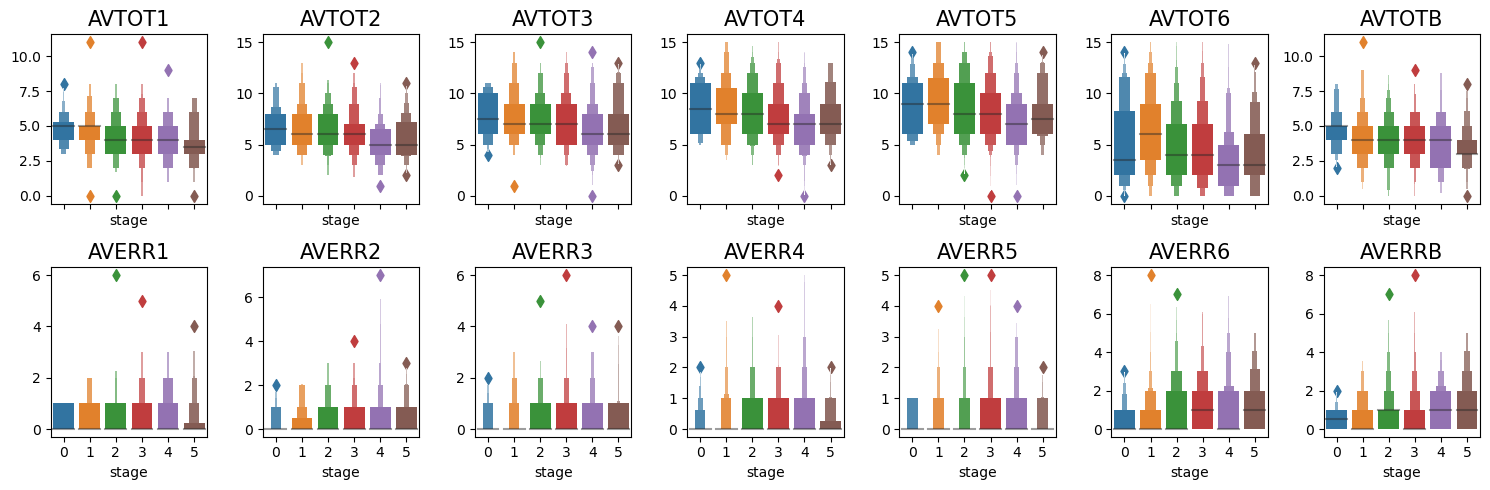

In [135]:
rows = 2; cols=7;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(15,5))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Regression

In [136]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [137]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

### RAVLT delayed

In [138]:
flds = ["AVDEL30MIN", "AVDELERR1", "AVDELTOT", "AVDELERR2"]
test_name = "RAVLT_delayed"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape AVDEL30MIN (808, 96)
Shape AVDELERR1 (808, 96)
Shape AVDELTOT (808, 96)
Shape AVDELERR2 (808, 96)


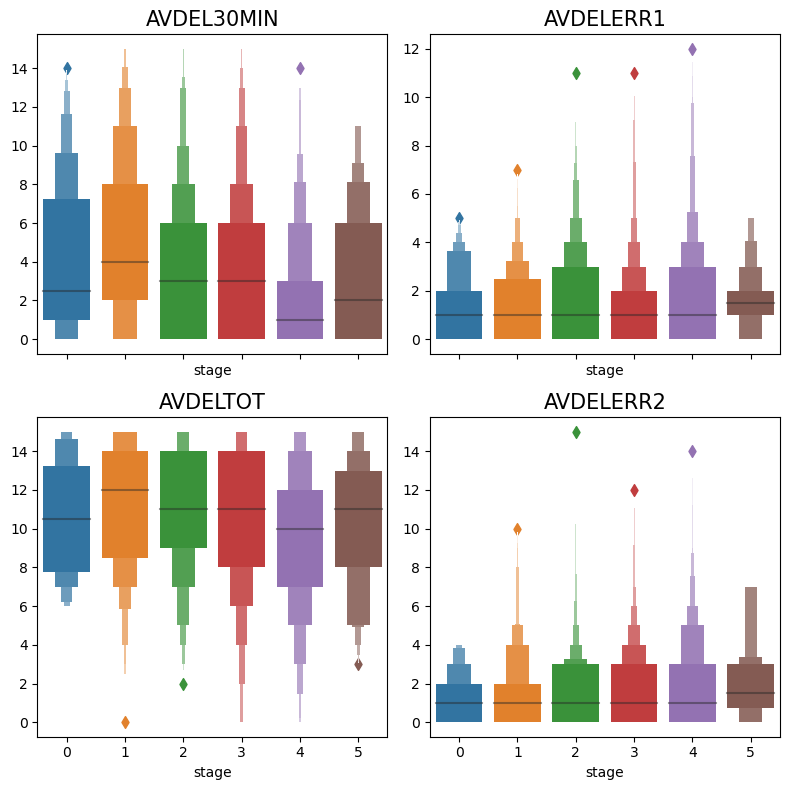

In [139]:
rows = 2; cols=2;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,8))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

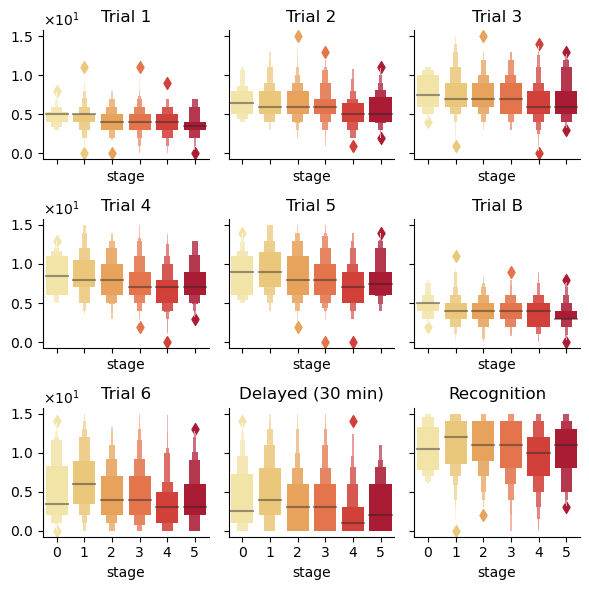

In [140]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOTB", "AVTOT6", "AVDEL30MIN", "AVDELTOT"]
flds_title = {"AVTOT1":"Trial 1", "AVTOT2":"Trial 2", "AVTOT3":"Trial 3",
             "AVTOT4":"Trial 4", "AVTOT5":"Trial 5", "AVTOTB":"Trial B",
             "AVTOT6":"Trial 6", "AVDEL30MIN":"Delayed (30 min)", "AVDELTOT":"Recognition"}
rows = 3; cols=3;
test_name = "RAVLT_delayed_final"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(6,6))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(flds_title[fld], fontsize=12)
    ax[r, c].spines[['right', 'top']].set_visible(False)
    ax[r, c].ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

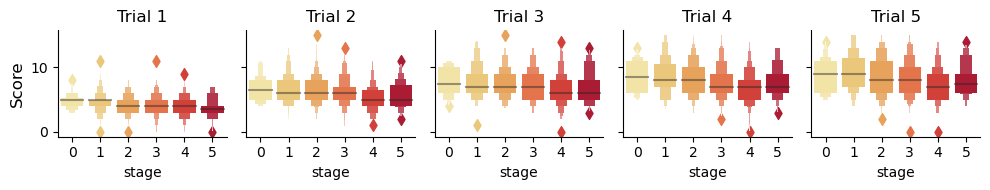

In [141]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5"]
flds_title = {"AVTOT1":"Trial 1", "AVTOT2":"Trial 2", "AVTOT3":"Trial 3",
             "AVTOT4":"Trial 4", "AVTOT5":"Trial 5", "AVTOTB":"Trial B",
             "AVTOT6":"Trial 6", "AVDEL30MIN":"Delayed (30 min)", "AVDELTOT":"Recognition"}
rows = 1; cols=5;
test_name = "RAVLT_trials_1_5"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(10,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

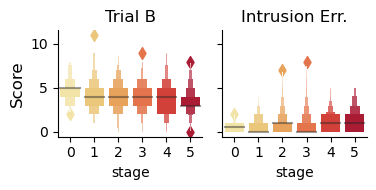

In [142]:
flds = ["AVTOTB","AVERRB"]
flds_title = {"AVTOTB":"Trial B","AVERRB":"Intrusion Err."}
rows = 1; cols=2;
test_name = "RAVLT_trials_B"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

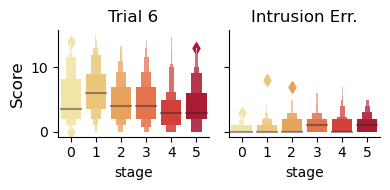

In [143]:
flds = ["AVTOT6","AVERR6"]
flds_title = {"AVTOT6":"Trial 6","AVERR6":"Intrusion Err."}
rows = 1; cols=2;
test_name = "RAVLT_trials_6"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

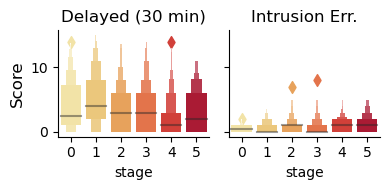

In [144]:
flds = ["AVDEL30MIN","AVERRB"]
flds_title = {"AVDEL30MIN":"Delayed (30 min)","AVERRB":"Intrusion Err."}
rows = 1; cols=2;
test_name = "RAVLT_trials_B"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Regression

In [145]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"] + ["AVDEL30MIN", "AVDELERR1", "AVDELTOT", "AVDELERR2"]
test_name = "RAVLT_delayed"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# CLOCK tests

In [146]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NEUROBAT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [147]:
flds = ["CLOCKCIRC","CLOCKSYM","CLOCKNUM","CLOCKHAND","CLOCKTIME",
        "COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME","LDELCUE"]
test_name = "clock_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.085326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.506886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.127785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587591
  

LinAlgError: Singular matrix

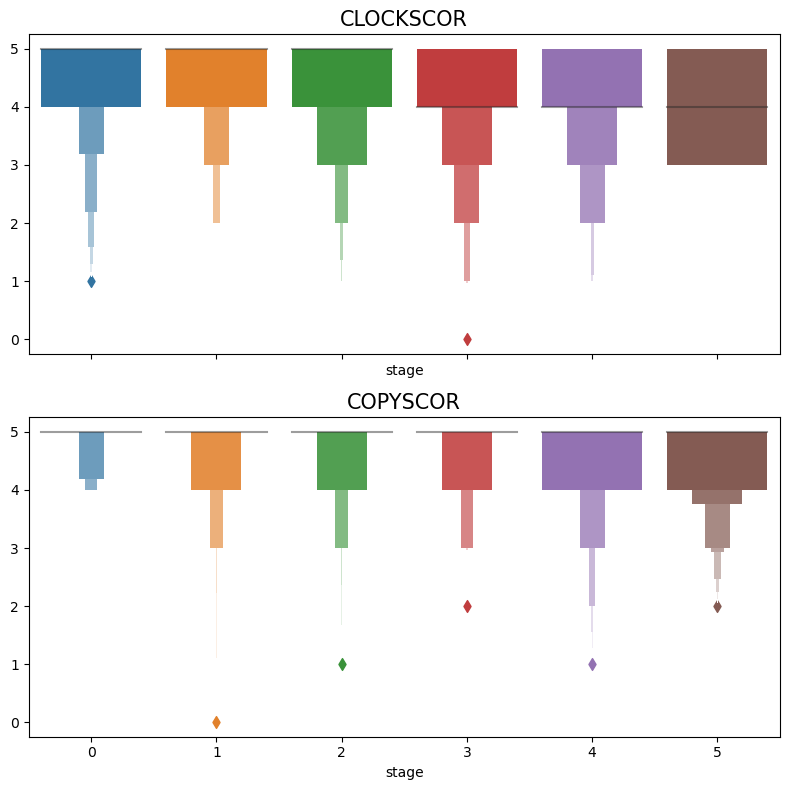

In [148]:
flds = ["CLOCKSCOR", "COPYSCOR"]
test_name = "clock_test"
rows = 2; cols=1;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,8))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_])
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# Line plots to show odds of failing a clock test as a fn of stage

In [149]:
dir_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/figures_4/neurobattery_run33_adj'

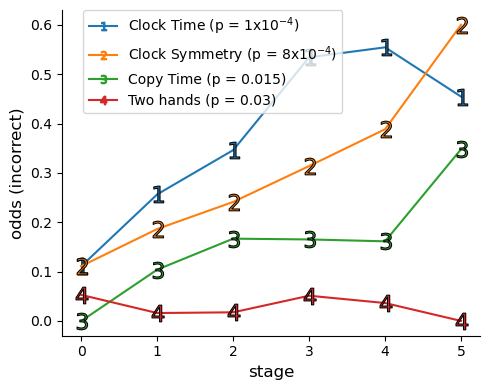

In [150]:
# flds = ["CLOCKCIRC","CLOCKSYM","CLOCKNUM","CLOCKHAND","CLOCKTIME"]
# flds = ["COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME"]
flds = ["CLOCKTIME", "CLOCKSYM", "COPYTIME","CLOCKHAND"]
binary = flds
test_name = "clock_ratio_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(1,1,figsize=(5,4))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=12, mec="k")

plt.legend(bbox_to_anchor=(0.05, 1.00), loc='upper left', borderaxespad=0, ncol=1)
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('odds (incorrect)', fontsize=12)
ax.set_xlabel('stage', fontsize=12)
leg = ax.get_legend()

flds_text = {"CLOCKTIME":r'Clock Time (p = 1x$10^{-4}$)',
             "CLOCKSYM":r'Clock Symmetry (p = 8x$10^{-4}$)',
            "COPYTIME":r'Copy Time (p = 0.015)',
             "CLOCKHAND":r'Two hands (p = 0.03)'}
for t, l in zip(leg.texts, flds):
    t.set_text(flds_text[l])

fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


# Neurobat others

### Logical Memory

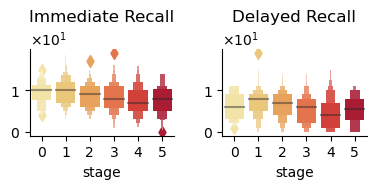

In [151]:
flds = ["LIMMTOTAL", "LDELTOTAL"]
fld_title = {"LIMMTOTAL":"Immediate Recall","LDELTOTAL":"Delayed Recall"}
rows = 1; cols=2;
test_name = "logical_memory"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_],
                palette=palette_color1)
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=12)
    ax[_].spines[['right', 'top']].set_visible(False)
    ax[_].ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
    ax[_].set_title(fld_title[fld],fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

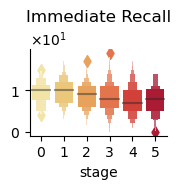

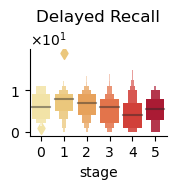

In [152]:
flds = ["LIMMTOTAL", "LDELTOTAL"]
fld_title = {"LIMMTOTAL":"Immediate Recall","LDELTOTAL":"Delayed Recall"}
rows = 1; cols=1;
test_name = "logical_memory"
for _,fld in enumerate(flds):
    fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(2,2))
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax,
                palette=palette_color1)
    ax.set_ylabel("")
    ax.set_title(fld, fontsize=12)
    ax.spines[['right', 'top']].set_visible(False)
    ax.ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
    ax.set_title(fld_title[fld],fontsize=12)
    fig.tight_layout()
    fig.savefig(os.path.join(dir_path, "{}.png".format(fld)), dpi=300)

# LDELCUE

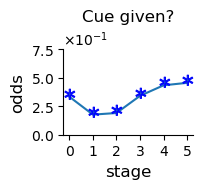

In [153]:
flds = ["LDELCUE"]
# flds = ["COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME"]
binary = flds
test_name = "LDELCUE_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[1]/chi2_table[0]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(1,1,figsize=(2,2))
markers = ['${}$'.format("*") for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=12,mec="b")

# plt.legend(bbox_to_anchor=(0.05, 1.00), loc='upper left', borderaxespad=0, ncol=1, fontsize=12)
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('odds', fontsize=12)
ax.set_xlabel('stage', fontsize=12)
leg = ax.get_legend()
flds_text = {"LDELCUE":'Cue given?\n(p = 1x$10^{-7}$)'}
# for t, l in zip(leg.texts, flds):
#     t.set_text(flds_text[l])
ax.set_title("Cue given?",fontsize=12)
ax.get_legend().remove()
ax.set_ylim([0,0.75])
ax.set_xticks([0,1,2,3,4,5])
ax.ticklabel_format(style='scientific', axis='y', 
                          scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


In [154]:
flds = ["LDELCUE"]
test_name = "ldelcue_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.481682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495908
         Iterations 6


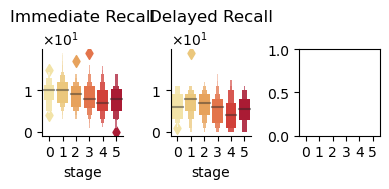

In [155]:
flds = ["LIMMTOTAL", "LDELTOTAL", ]
fld_title = {"LIMMTOTAL":"Immediate Recall","LDELTOTAL":"Delayed Recall","LDELCUE":"Cue given?"}
rows = 1; cols=3;
test_name = "logical_memory"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_],
                palette=palette_color1)
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=12)
    ax[_].spines[['right', 'top']].set_visible(False)
    ax[_].ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
    ax[_].set_title(fld_title[fld],fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# DigitSpan test

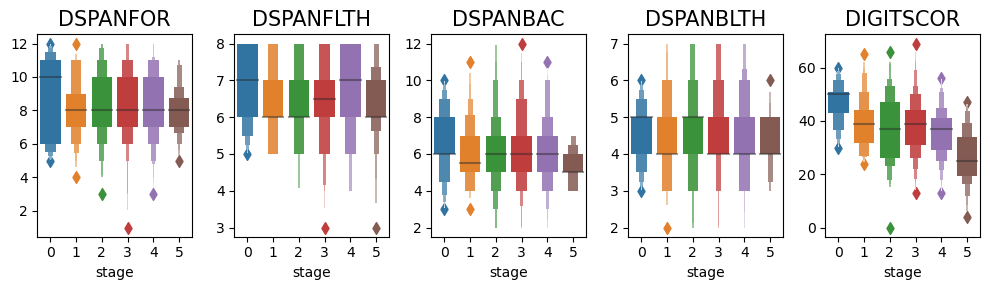

In [156]:
flds = ["DSPANFOR", "DSPANFLTH", "DSPANBAC", "DSPANBLTH", "DIGITSCOR"]
rows = 1; cols=5;
test_name = "digit_span"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(10,3))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_])
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [157]:
# Category Fluency Test

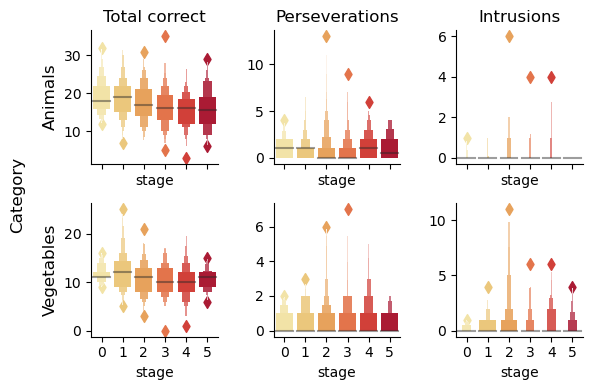

In [158]:
flds = ["CATANIMSC", "CATANPERS", "CATANINTR", "CATVEGESC", "CATVGPERS", "CATVGINTR"]
flds_title = {"CATANIMSC":"Total correct", "CATANPERS":"Perseverations", "CATANINTR":"Intrusions",
             "CATVEGESC":"", "CATVGPERS":"", "CATVGINTR":""}
rows = 2; cols=3;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(6,4))
test_name = "cat_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c],palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(flds_title[fld], fontsize=12)
    ax[r, c].spines[['right', 'top']].set_visible(False)
ax[0,0].set_ylabel("Animals", fontsize=12)
ax[1,0].set_ylabel("Vegetables", fontsize=12)
fig.supylabel("Category", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

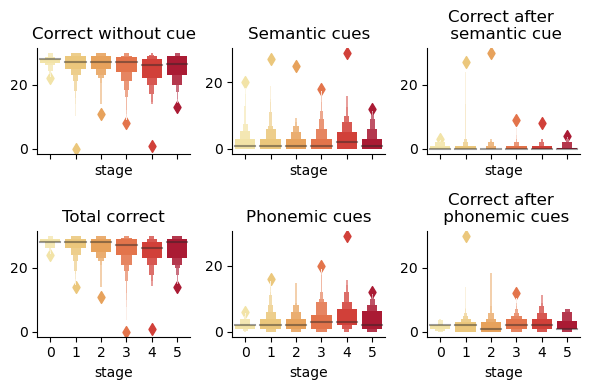

In [159]:
flds = ["BNTSPONT", "BNTSTIM", "BNTCSTIM", "BNTTOTAL", "BNTPHON", "BNTCPHON"]
flds_title = {"BNTSPONT":"Correct without cue", "BNTSTIM": "Semantic cues",
             "BNTCSTIM":"Correct after \n semantic cue", "BNTPHON":"Phonemic cues",
             "BNTCPHON":"Correct after \n phonemic cues", "BNTTOTAL":"Total correct"}
rows = 2; cols=3;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(6,4))
test_name = "bnt_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(flds_title[fld], fontsize=12)
    ax[r, c].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# American National Adult Reading Test

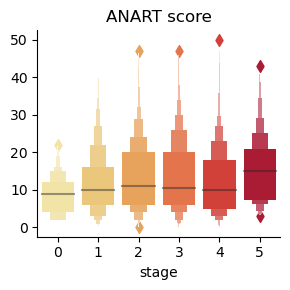

In [160]:
flds = ["ANARTERR"]
rows = 1; cols=1;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(3,3))
test_name = "anart_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax, palette=palette_color1)
    ax.set_ylabel("")
    ax.set_title("ANART score", fontsize=12)
fig.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [163]:
neuro_sc = "ANARTERR"
df_xx = regress_score(df_mh_fld, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE", "stage"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ANARTERR   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     35.53
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           3.70e-32
Time:                        12:31:15   Log-Likelihood:                -2296.4
No. Observations:                 653   AIC:                             4605.
Df Residuals:                     647   BIC:                             4632.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.0804      3.836      8.362      0.0

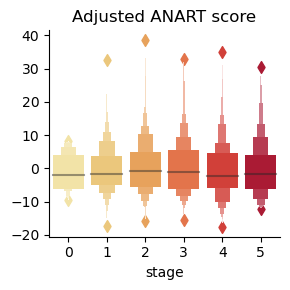

In [164]:
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(3,3))
test_name = "anart_test_resid"
sns.boxenplot(data=pd.concat([results.resid, df_xx["stage"]], axis=1),  x="stage", y=0, palette=palette_color1)
ax.set_ylabel("")
ax.set_title(r'Adjusted ANART score', fontsize=12)
fig.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)


In [165]:
df_mh_fld["ANARTERR"]

12      26.0
21       4.0
28       2.0
35       2.0
38       6.0
        ... 
3228     6.0
3234     6.0
3239     5.0
3243     2.0
3247     2.0
Name: ANARTERR, Length: 653, dtype: float64

# Regression stats for all neurobattery tests (clock, BNT, CATegory etc)

In [166]:
flds = ["CLOCKSCOR", "COPYSCOR"] + ["LIMMTOTAL", "DSPANFOR", "DSPANFLTH", 
        "DSPANBAC", "DSPANBLTH", "DIGITSCOR", "CATANIMSC", "CATANPERS", "CATANINTR",
        "CATVEGESC", "CATVGPERS", "CATVGINTR"] + ["LDELTOTAL", "BNTSPONT", "BNTSTIM",
        "BNTCSTIM", "BNTPHON", "BNTCPHON", "BNTTOTAL", "ANARTERR"]
test_name = "neurobat_ols_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [167]:
df_xx = regress_score(df_mh, "ANARTERR", ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
stats_df1 = regress_OLS(df_xx, "ANARTERR", cov1)

In [168]:
stats_df1

p-vals       coef   std-err  conf-int-lower95  \
const     1.066792e-16  32.711521  3.836086         25.178773   
PTGENDER  1.123653e-04   2.595773  0.667945          1.284159   
APOE4     2.932152e-01   0.502303  0.477495         -0.435333   
PTEDUCAT  6.812419e-33  -1.499474  0.118585         -1.732333   
AGE       6.074357e-01   0.022190  0.043172         -0.062585   
stage     1.643414e-02   0.653261  0.271577          0.119978   
st1       4.920189e-02  -1.682638  0.853887         -3.359377   
st2       1.586519e-01  -1.333372  0.944812         -3.188655   
st3       6.927478e-02  -1.639114  0.900780         -3.407935   

          conf-int-upper95       fld  r-sq-adj      f-pvalue  
const            40.244269  ANARTERR  0.213048  3.798710e-31  
PTGENDER          3.907386  ANARTERR  0.213048  3.798710e-31  
APOE4             1.439939  ANARTERR  0.213048  3.798710e-31  
PTEDUCAT         -1.266614  ANARTERR  0.213048  3.798710e-31  
AGE               0.106966  ANARTERR  0.213048  3.798710e-31  
stage             1.186543  ANARTERR  0.213048  3.798710e-31  
st1              -0.005898  ANARTERR  0.213048  3.798710e-31  
st2               0.521912  ANARTERR  0.213048  3.798710e-31  
st3               0.129706  ANARTERR  0.213048  3.798710e-31

# MMSE

In [169]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MMSE_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["PTID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

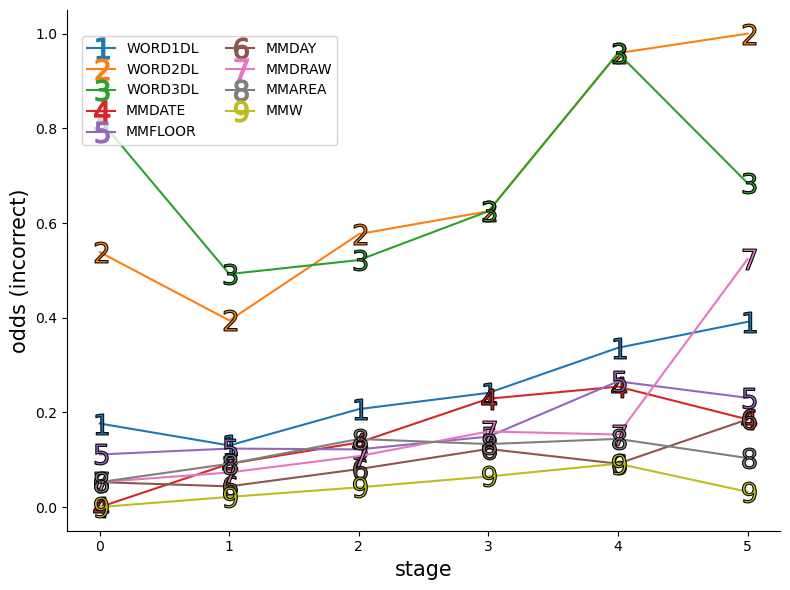

In [170]:
flds = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
       "WORD1","WORD2","WORD3","MMTRIALS","MMD","MML","MMR","MMO","MMW",
        "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
        "MMONFLR","MMREAD","MMWRITE","MMDRAW","MMSCORE"]
# binary = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
#        "WORD1","WORD2","WORD3","MMD","MML","MMR","MMO","MMW",
#         "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
#         "MMONFLR","MMREAD","MMWRITE","MMDRAW"]
binary = ["WORD1DL", "WORD2DL", "WORD3DL", "MMDATE", "MMFLOOR", "MMDAY", "MMDRAW", "MMAREA", "MMW"]
test_name = "mmse_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(8,6))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=15, mec="k")

lgnd = plt.legend(bbox_to_anchor=(0.02, 0.95), loc='upper left', borderaxespad=0, ncol=2)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(15)
    
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds (incorrect)", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


In [171]:
mmdraw = ratio_df["MMDRAW"]

In [172]:
neuro_sc = "MMSCORE"
df_xx = regress_score(df_mh, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                MMSCORE   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     15.19
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           7.03e-21
Time:                        12:32:30   Log-Likelihood:                -1670.3
No. Observations:                 808   AIC:                             3359.
Df Residuals:                     799   BIC:                             3401.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.1250      0.811     37.146      0.0

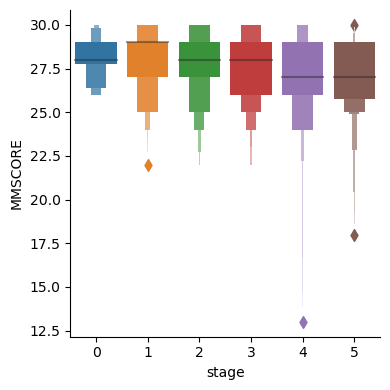

In [173]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(4, 4))
sns.boxenplot(data=df_mh_fld, x="stage", y="MMSCORE")
ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "MMSCORE_boxen.png"), dpi=300)


In [174]:
fld = "WORLDSCORE"
df_mh_fld = process_df(df_mh, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld)

ValueError: min() arg is an empty sequence

In [175]:
df_mh["WORLDSCORE"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2585   NaN
2586   NaN
2587   NaN
2588   NaN
2589   NaN
Name: WORLDSCORE, Length: 2590, dtype: float64

## Logistic regression - MMSE

In [177]:
flds = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
       "WORD1","WORD2","MMD","MML","MMR","MMO","MMW",
        "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
        "MMONFLR","MMREAD","MMWRITE","MMDRAW"]
test_name = "mmse_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.393456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404376
         Iterations 6
         Current function value: 0.068897
         Iterations: 35


LinAlgError: Singular matrix

# EMBIC

In [178]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "EMBICqCP_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [179]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print("Shape", df_mh_fld.shape)
    kruskal_stats = kruskal(*[group[fld].values for name, group in df_mh_fld.groupby("stage")])
    kruskal_pval = kruskal_stats.pvalue
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [kruskal_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["kruskal-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)


### Regression

In [180]:
df_xx

AGE  PTGENDER  PTEDUCAT  APOE4  stage  MMYEAR  st0  st1  st2  st3
0     65.1         0        16    1.0      3     1.0    1    0    0    0
4     81.6         1        16    0.0      2     1.0    0    0    1    0
8     69.3         0        14    1.0      4     1.0    0    1    0    0
11    73.6         1        14    0.0      3     1.0    0    0    1    0
15    57.8         1        20    0.0      4     1.0    0    0    0    1
...    ...       ...       ...    ...    ...     ...  ...  ...  ...  ...
2576  78.5         0        12    0.0      2     1.0    0    0    0    1
2577  62.0         1        16    0.0      1     1.0    1    0    0    0
2581  69.3         0        12    1.0      3     1.0    0    1    0    0
2584  81.4         1        18    0.0      2     1.0    1    0    0    0
2587  82.7         0        20    0.0      4     1.0    0    0    1    0

[808 rows x 10 columns]

In [181]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test_logodds"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS_logodds(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS_logodds(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [182]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

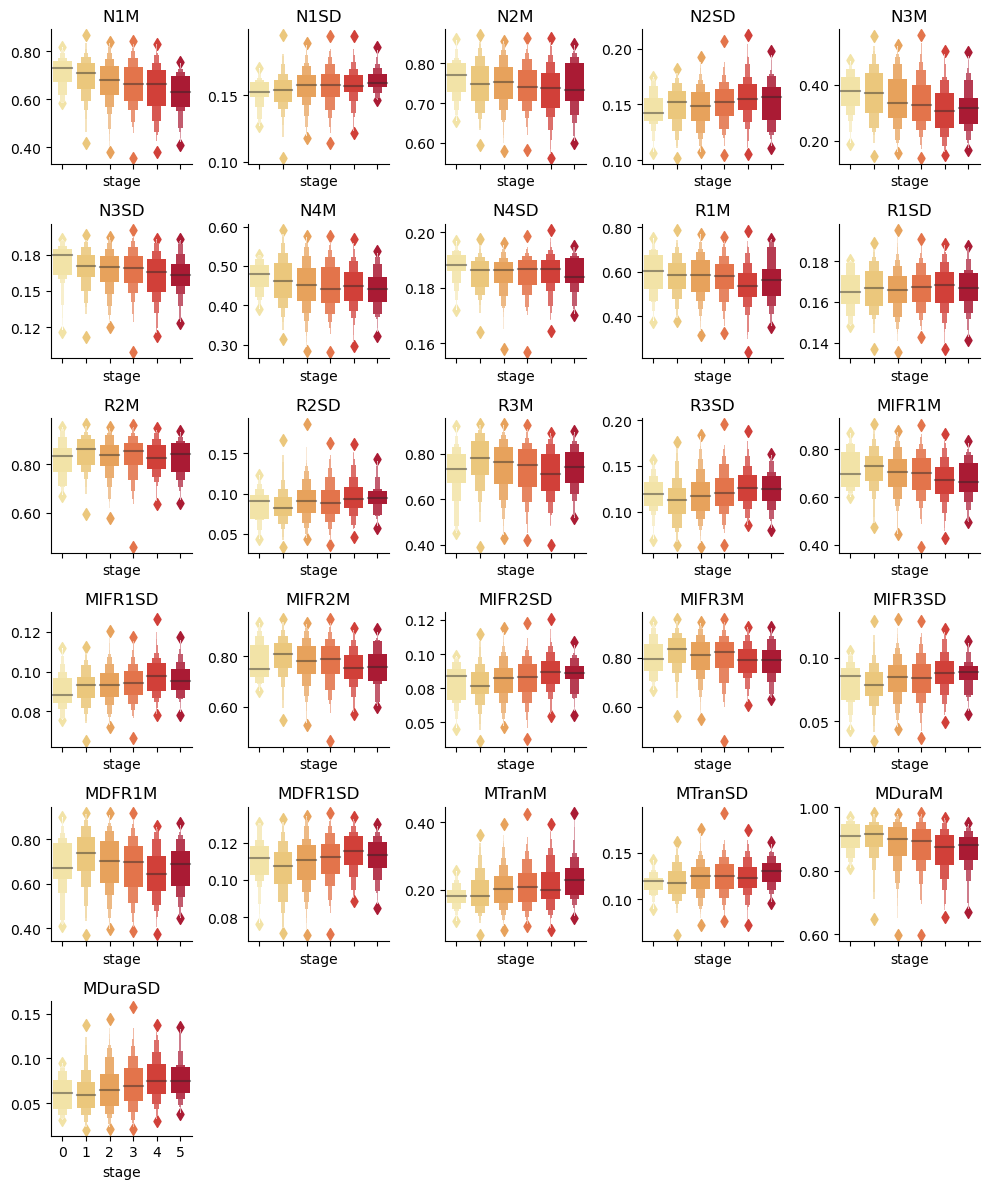

In [183]:
fmt = '%.2f'
yticks = mtick.FormatStrFormatter(fmt)
fig, ax = plt.subplots(6,5, figsize=(10,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 5
    c = i % 5
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c],
                 palette=palette_color1)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
    ax[r,c].yaxis.set_major_formatter(yticks)
    ax[r,c].set_title(fld, fontsize=12)

for _ in range(1,5):
    ax[5,_].set_axis_off()
    
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# ADAS - ADNI GO, 2, 3

In [184]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNIGO23_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [185]:
flds = ["Q3TASK1", "Q3TASK2", "Q3TASK3", "Q3TASK4", "TOTSCORE", "TOTAL13"]
binary = []
test_name = "adas_go23_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


Shape (457, 134)
Shape (457, 134)
Shape (457, 134)
Shape (457, 134)
Shape (457, 134)
Shape (457, 134)


# Logistic regression for the cube test

In [186]:
fld = "Q3TASK4"
test_name = "adas_go23_test"
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
df_xx[fld] = df_xx[fld].map({1:1,2:0,3:0})
stats_df1 = regress_Logit(df_xx, fld, cov1)
stats_df1

Optimization terminated successfully.
         Current function value: 0.656160
         Iterations 5


p-vals      coef   std-err  conf-int-lower95  conf-int-upper95  \
const     0.349162  1.139959  1.217624         -1.246541          3.526458   
PTGENDER  0.986985  0.003301  0.202376         -0.393349          0.399952   
APOE4     0.023649 -0.336546  0.148730         -0.628052         -0.045039   
PTEDUCAT  0.000677  0.127028  0.037374          0.053776          0.200280   
AGE       0.010434 -0.035237  0.013758         -0.062203         -0.008271   
stage     0.032890 -0.178845  0.083830         -0.343148         -0.014541   
st1       0.377068  0.229577  0.259905         -0.279828          0.738982   
st2       0.202484 -0.363839  0.285474         -0.923359          0.195680   
st3       0.548344  0.158952  0.264813         -0.360072          0.677977   

              fld  psuedo-r-sq  llr_pvalue  
const     Q3TASK4     0.051628    0.000071  
PTGENDER  Q3TASK4     0.051628    0.000071  
APOE4     Q3TASK4     0.051628    0.000071  
PTEDUCAT  Q3TASK4     0.051628    0.000071  
AGE       Q3TASK4     0.051628    0.000071  
stage     Q3TASK4     0.051628    0.000071  
st1       Q3TASK4     0.051628    0.000071  
st2       Q3TASK4     0.051628    0.000071  
st3       Q3TASK4     0.051628    0.000071

In [187]:
df_xx

AGE  PTGENDER  PTEDUCAT  APOE4  stage  Q3TASK4  st0  st1  st2  st3
0     57.8         1        20    0.0      4        1    0    0    0    1
4     62.9         0        20    1.0      1        1    0    1    0    0
10    72.2         0        20    1.0      2        1    0    1    0    0
12    63.4         0        20    0.0      1        1    0    1    0    0
18    69.4         1        16    0.0      3        1    1    0    0    0
...    ...       ...       ...    ...    ...      ...  ...  ...  ...  ...
1459  78.5         0        12    0.0      2        0    0    0    0    1
1460  62.0         1        16    0.0      1        1    1    0    0    0
1464  69.3         0        12    1.0      3        1    0    1    0    0
1467  81.4         1        18    0.0      2        0    1    0    0    0
1470  82.7         0        20    0.0      4        1    0    0    1    0

[457 rows x 10 columns]

Shape (457, 134)


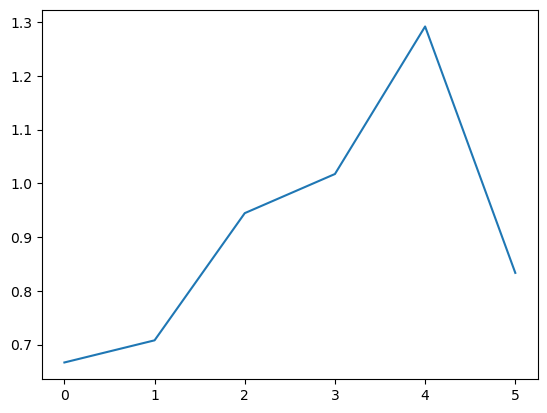

In [188]:
fld = "Q3TASK4"
test_name = "adas_go23_test"

ratio_df = pd.DataFrame()
df_mh_fld = process_df(df_mh, fld)
print("Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]
ratio = chi2_table[2]/chi2_table[1]
# ratio_df[fld] = ratio
spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
plt.plot(ratio)


In [189]:
chi2_table, spearmanr_corr

(Q3TASK4   1.0   2.0  3.0
 stage                   
 0         9.0   6.0  0.0
 1        89.0  63.0  0.0
 2        54.0  51.0  2.0
 3        58.0  59.0  0.0
 4        24.0  31.0  0.0
 5         6.0   5.0  0.0,
 0.09303180215745838)

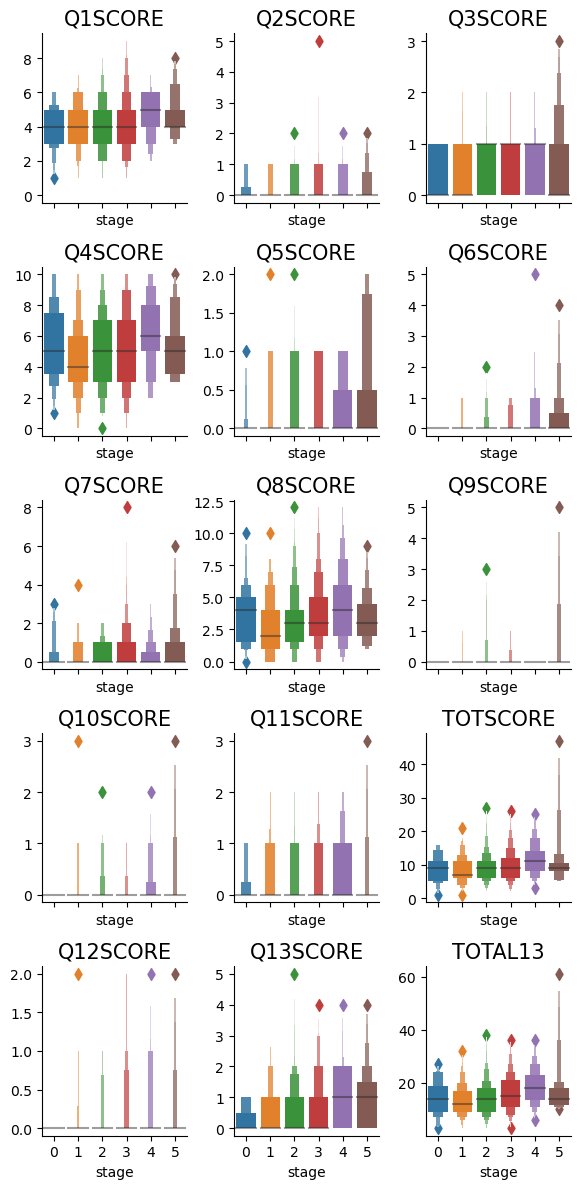

In [190]:
flds = ["Q1SCORE", "Q2SCORE", "Q3SCORE", "Q4SCORE", "Q5SCORE",
        "Q6SCORE", "Q7SCORE", "Q8SCORE", "Q9SCORE", "Q10SCORE",
       "Q11SCORE", "TOTSCORE", "Q12SCORE", "Q13SCORE", "TOTAL13"]
fig, ax = plt.subplots(5,3, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 3
    c = i % 3
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [194]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT", "AGE", 
                                          "stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [195]:
dir_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/figures_4/neurobattery_run33_adj'

In [196]:
stats_df_all

p-vals      coef      fld  r-sq-adj
const     2.253828e-01  1.003252  Q1SCORE  0.145940
PTGENDER  1.207089e-03  0.443254  Q1SCORE  0.145940
APOE4     2.889308e-07  0.517623  Q1SCORE  0.145940
PTEDUCAT  6.708104e-03 -0.067534  Q1SCORE  0.145940
AGE       2.518471e-06  0.044004  Q1SCORE  0.145940
...                ...       ...      ...       ...
AGE       5.990587e-11  0.279804  TOTAL13  0.208543
stage     1.050546e-09  1.579728  TOTAL13  0.208543
st1       2.222086e-01 -0.959567  TOTAL13  0.208543
st2       7.034131e-01  0.331713  TOTAL13  0.208543
st3       6.677274e-01  0.346654  TOTAL13  0.208543

[135 rows x 4 columns]

# ADAS - ADNI 1

In [197]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNI1_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [198]:
df_mh_fld = process_df(df_mh, "COCONSTR")

In [199]:
def harmonize_coconstr(x):
    l = x.split(":")
    int_l =[int(_) for _ in l]
    int_l.sort()
    res_list = []
    res_list = [1*(_ in int_l) for _ in range(1,6)]
    return res_list

In [200]:
s = df_mh_fld["COCONSTR"].apply(lambda x: harmonize_coconstr(x))
df_coconstr = pd.DataFrame(np.vstack(s))
df_coconstr.columns = ["no-shape", "circ", "rectangles", "rhombus", "cube"]
df_coconstr2 = pd.concat([df_mh_fld, df_coconstr], axis=1)

Shape (609, 99)


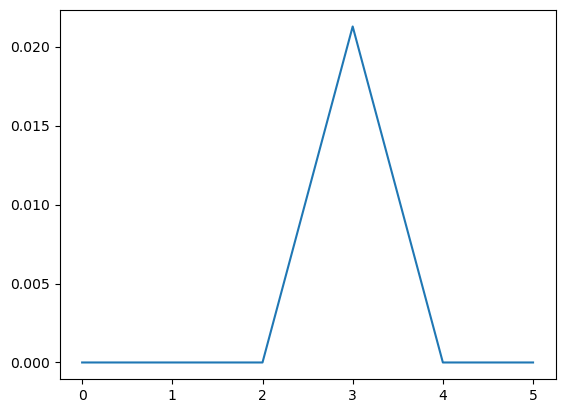

In [201]:
fld = "rectangles"
test_name = "adas_1_test"
ratio_df = pd.DataFrame()
print("Shape", df_coconstr2.shape)
chi2_table = df_coconstr2.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]
ratio = chi2_table[0]/chi2_table[1]
# ratio_df[fld] = ratio
# spearmanr_corr = spearmanr(df_coconstr["stage"], df_coconstr[fld]).correlation
plt.plot(ratio)


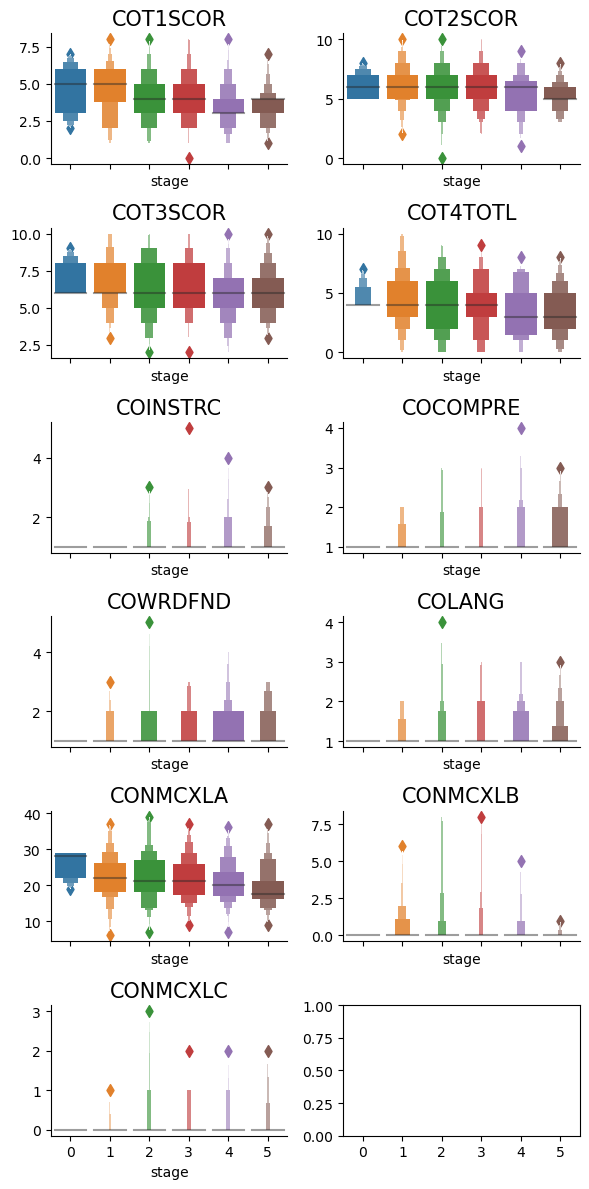

In [202]:
flds = ["COT1SCOR", "COT2SCOR", "COT3SCOR", "COT4TOTL",
        "COINSTRC", "COCOMPRE", "COWRDFND", "COLANG", "CONMCXLA",
        "CONMCXLB", "CONMCXLC"]
test_name = "ADAS1_test"
fig, ax = plt.subplots(6,2, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 2
    c = i % 2
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [203]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT", "AGE", 
                                          "stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [204]:
stats_df_all

p-vals      coef       fld  r-sq-adj
const     3.037503e-07  4.862233  COT1SCOR  0.072293
PTGENDER  5.957088e-01 -0.089136  COT1SCOR  0.072293
APOE4     2.470533e-03 -0.358662  COT1SCOR  0.072293
PTEDUCAT  4.379785e-03  0.076512  COT1SCOR  0.072293
AGE       2.513839e-01 -0.012532  COT1SCOR  0.072293
...                ...       ...       ...       ...
AGE       4.990130e-01  0.001469  CONMCXLC  0.006122
stage     6.170337e-01  0.007194  CONMCXLC  0.006122
st1       1.162490e-01 -0.072462  CONMCXLC  0.006122
st2       8.740654e-02 -0.073290  CONMCXLC  0.006122
st3       1.001922e-01  0.080181  CONMCXLC  0.006122

[99 rows x 4 columns]

# CDR

In [205]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "CDR_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [206]:
flds = ["CDMEMORY","CDORIENT","CDJUDGE","CDCOMMUN","CDHOME","CDCARE","CDGLOBAL","CDRSB"]
binary = []
test_name = "cdrsb_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
# fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)


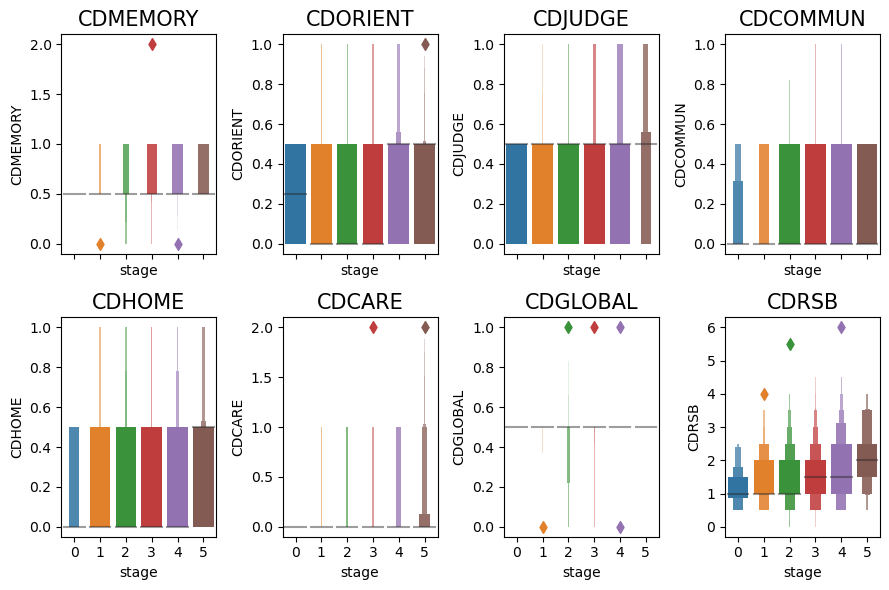

In [207]:
fig, ax = plt.subplots(2,4, figsize=(9,6), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 4
    c = i % 4
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "CDR.png"), dpi=300)

In [208]:
neurobat_df

chi-2-pval  spearmanr
CDMEMORY    0.000045   0.197056
CDORIENT    0.128951   0.076566
CDJUDGE     0.004820   0.132497
CDCOMMUN    0.005694   0.155975
CDHOME      0.035412   0.137491
CDCARE      0.004289   0.096758
CDGLOBAL    0.561953   0.020015
CDRSB       0.002007   0.192847

In [209]:
flds = ["CDMEMORY","CDORIENT","CDJUDGE","CDCOMMUN","CDHOME","CDCARE","CDGLOBAL","CDRSB"]
test_name = "cdr_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE", "stage", "st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [210]:
stats_df_all

p-vals      coef       fld  r-sq-adj
const     7.806687e-11  0.497080  CDMEMORY  0.041618
PTGENDER  2.908801e-01 -0.013882  CDMEMORY  0.041618
APOE4     6.601313e-03  0.025576  CDMEMORY  0.041618
PTEDUCAT  7.876592e-01  0.000607  CDMEMORY  0.041618
AGE       7.321097e-01 -0.000294  CDMEMORY  0.041618
...                ...       ...       ...       ...
AGE       8.526388e-01  0.000793     CDRSB  0.067482
stage     2.002096e-10  0.169950     CDRSB  0.067482
st1       1.741782e-03 -0.267989     CDRSB  0.067482
st2       6.756918e-01 -0.037059     CDRSB  0.067482
st3       6.595802e-01 -0.039398     CDRSB  0.067482

[72 rows x 4 columns]

# GDSCALE

In [211]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "GDSCALE_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)
df_mh["GDDROP"] = df_mh["GDDROP"].map({0:1, 1:0})

Shape (2, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)


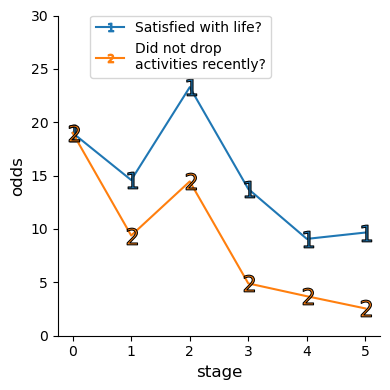

In [212]:
flds = ["GDUNABL", "GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
        "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE", "GDBETTER", "GDTOTAL"]
# binary = ["GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
#         "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE"]
binary = ["GDSATIS", "GDDROP"]
test_name = "gdscale_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[1]/chi2_table[0]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

fig, ax = plt.subplots(figsize=(4,4))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=12, mec="k")

lgnd = plt.legend(borderaxespad=0, ncol=1)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(12)

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds", fontsize=12)
ax.set_xlabel("stage", fontsize=12)
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim([0,30])
lgnd = plt.legend(bbox_to_anchor=(0.1, 1.), loc='upper left', borderaxespad=0, ncol=1)
# for m_ in range(len(markers)):
#     lgnd.legendHandles[m_].set_markersize(12)
flds_text = {"GDSATIS":"Satisfied with life?","GDDROP":"Did not drop\nactivities recently?"}
for t, l in zip(lgnd.texts, binary):
    t.set_text(flds_text[l])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


In [213]:
flds = ["GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
        "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE"]
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.240732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242917
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.120173
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.121515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.292376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155115
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.155906
  

In [214]:
neuro_sc = "GDTOTAL"
df_xx = regress_score(df_mh, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                GDTOTAL   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.651
Date:                Tue, 30 Jul 2024   Prob (F-statistic):            0.00714
Time:                        12:36:38   Log-Likelihood:                -1431.1
No. Observations:                 786   AIC:                             2880.
Df Residuals:                     777   BIC:                             2922.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9692      0.641      4.635      0.0

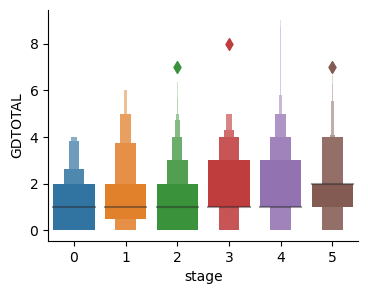

In [215]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(4, 3))
df_mh_fld = process_df(df_mh, "GDTOTAL")
sns.boxenplot(data=df_mh_fld, x="stage", y="GDTOTAL")
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join(dir_path, "GDTOTAL_boxen.png"), dpi=300)


# FAQ Test

In [216]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "FAQ_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [217]:
flds = ["FAQFINAN", "FAQFORM", "FAQSHOP", "FAQGAME", "FAQBEVG", "FAQMEAL", "FAQEVENT",
        "FAQTV", "FAQREM", "FAQTRAVL", "FAQTOTAL"]
binary = []
test_name = "FAQ_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



FAQFINAN Shape (807, 36)
FAQFORM Shape (807, 36)
FAQSHOP Shape (808, 36)
FAQGAME Shape (808, 36)
FAQBEVG Shape (808, 36)
FAQMEAL Shape (808, 36)
FAQEVENT Shape (808, 36)
FAQTV Shape (808, 36)
FAQREM Shape (808, 36)
FAQTRAVL Shape (808, 36)
FAQTOTAL Shape (807, 36)


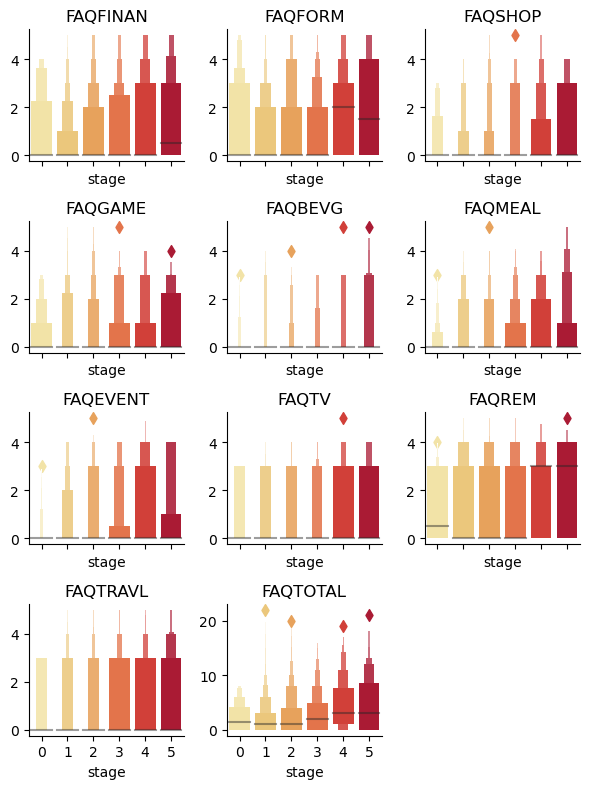

In [218]:
fig, ax = plt.subplots(4,3, figsize=(6,8), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 3
    c = i % 3
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_title(fld, fontsize=12)
    ax[r,c].set_ylabel("")
    ax[r,c].spines[['right', 'top']].set_visible(False)
ax[3,2].set_axis_off()
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "FAQ_test.png"), dpi=300)

In [219]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

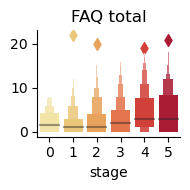

In [220]:
fld = "FAQTOTAL"
fig, ax = plt.subplots(1,1, figsize=(2,2), sharex=True)
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax, palette=palette_color1)
ax.set_title("FAQ total", fontsize=12)
ax.set_ylabel("")
ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "FAQ_total_test.png"), dpi=300)

# UWNPSYCHSUM

In [221]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "UWNPSYCHSUM_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

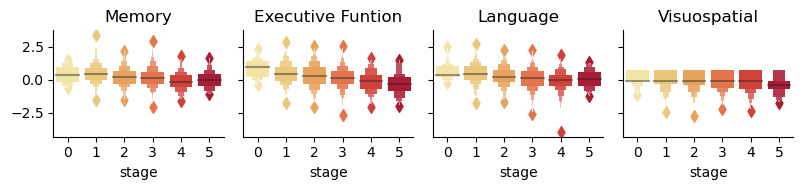

In [222]:
test_name="uwnpsych_test"
flds = ["ADNI_MEM", "ADNI_EF", "ADNI_LAN", "ADNI_VS"]
flds_dict = {"ADNI_MEM":"Memory", "ADNI_EF":"Executive Funtion", "ADNI_EF2":r'$Executive Function^{2}$', 
             "ADNI_LAN":"Language", "ADNI_VS":"Visuospatial"}
fig, ax = plt.subplots(1,4, figsize=(8,2), sharex=True, sharey=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[i], palette=palette_color1)
    ax[i].set_title(flds_dict[fld], fontsize=12)
    ax[i].set_ylabel("")
    ax[i].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [223]:
test_name = "uwnpsych_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ADAS scores

In [224]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADASSCORES_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)

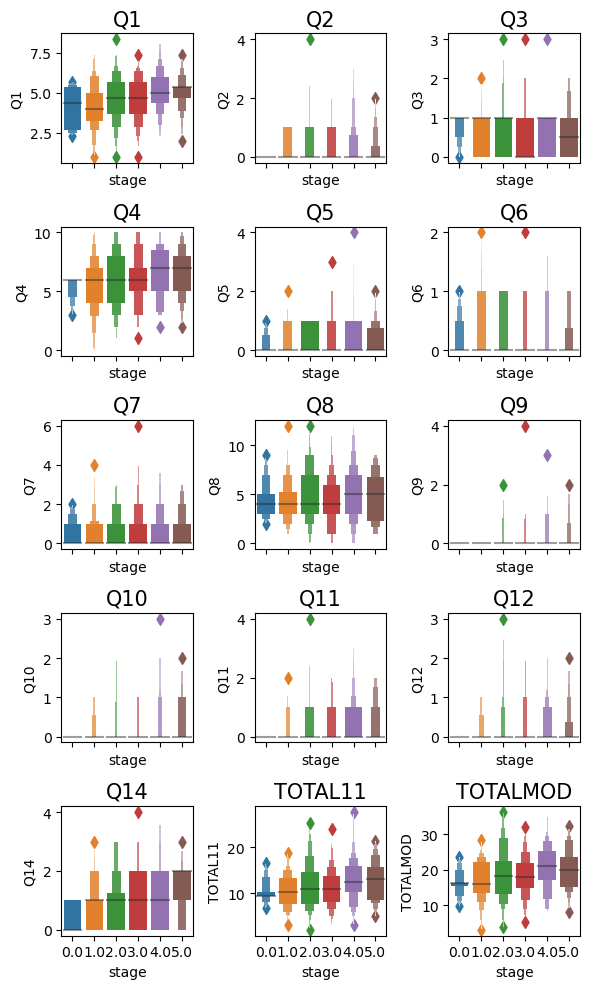

In [225]:
test_name="adas_scores_test"
flds = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9",
        "Q10", "Q11", "Q12", "Q14", "TOTAL11", "TOTALMOD"]
fig, ax = plt.subplots(5,3, figsize=(6,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [226]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# FCI

### The data is only after 2017 so there are no matches

# ADNI-CBBRESULTS

### The data does not have viscode making it harder to align.
### Also, it was only started to be measured around 2015, so there is not much data.

# ECOGSP

In [227]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGSP_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

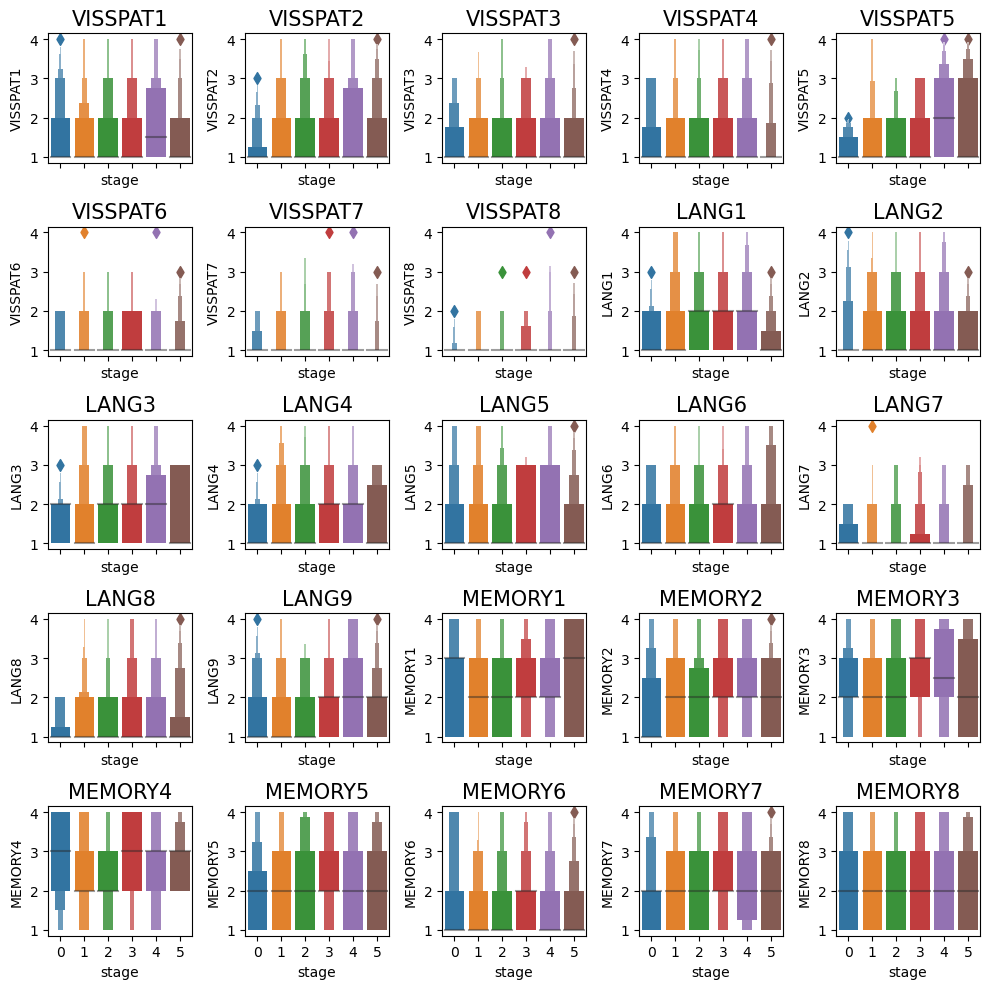

In [228]:
test_name="ecogsp_test"
flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8",
        "LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8","LANG9",
        "MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 5
    c = i % 5
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [229]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGSP2 - PLANNING, ORGANIZING, DIVATT 

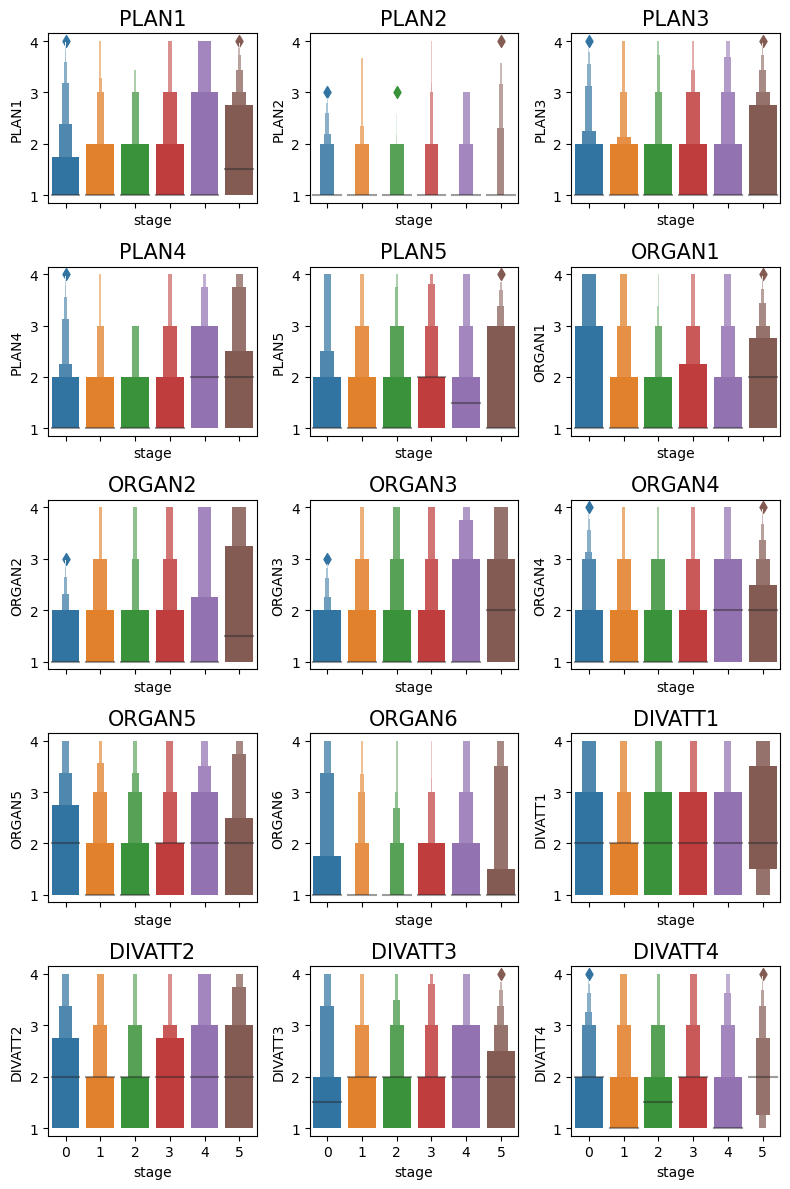

In [230]:
test_name = "ecogsp2_test"
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", 
        "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1", "DIVATT2", "DIVATT3", "DIVATT4"]
fig, ax = plt.subplots(5,3, figsize=(8,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [231]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGPT

In [232]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGPT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

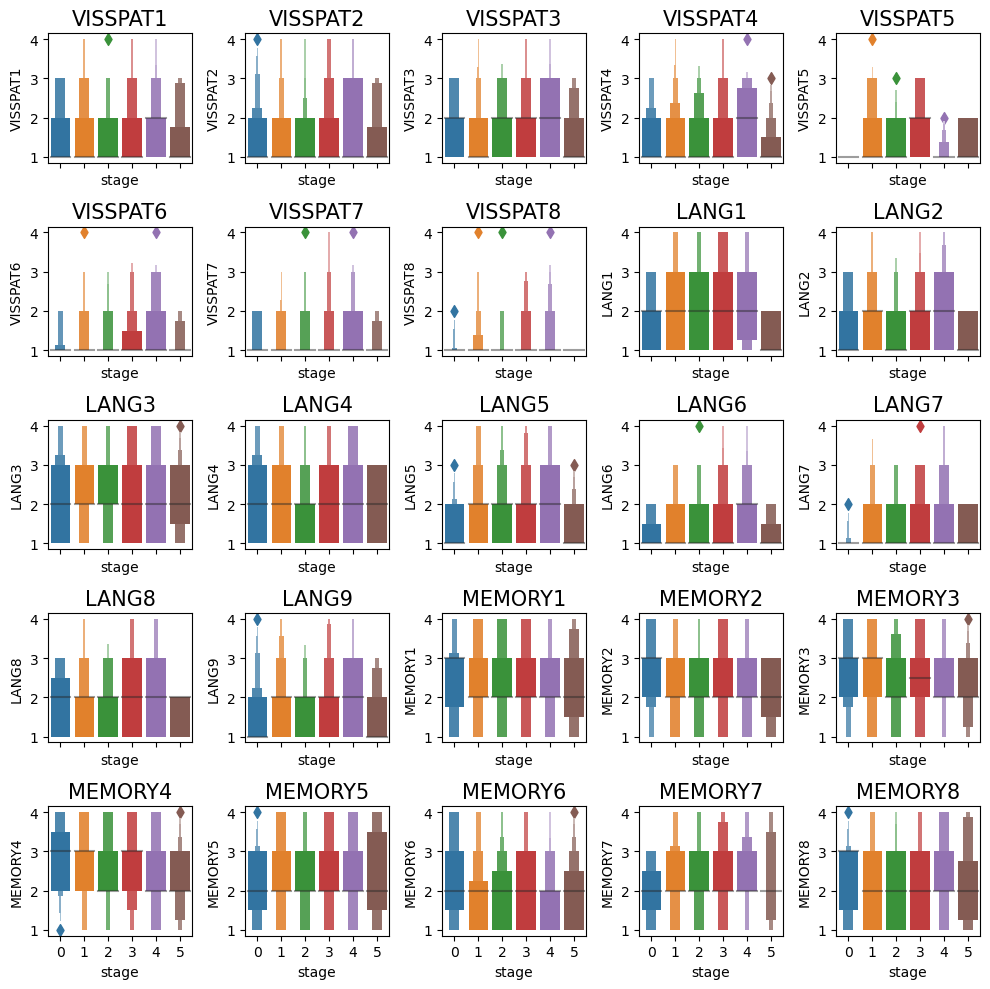

In [233]:
test_name="ecogpt_test"
flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8",
        "LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8", "LANG9",
        "MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 5
    c = i % 5
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [234]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGPT2 - PLANNING, ORGANIZING, DIVATT

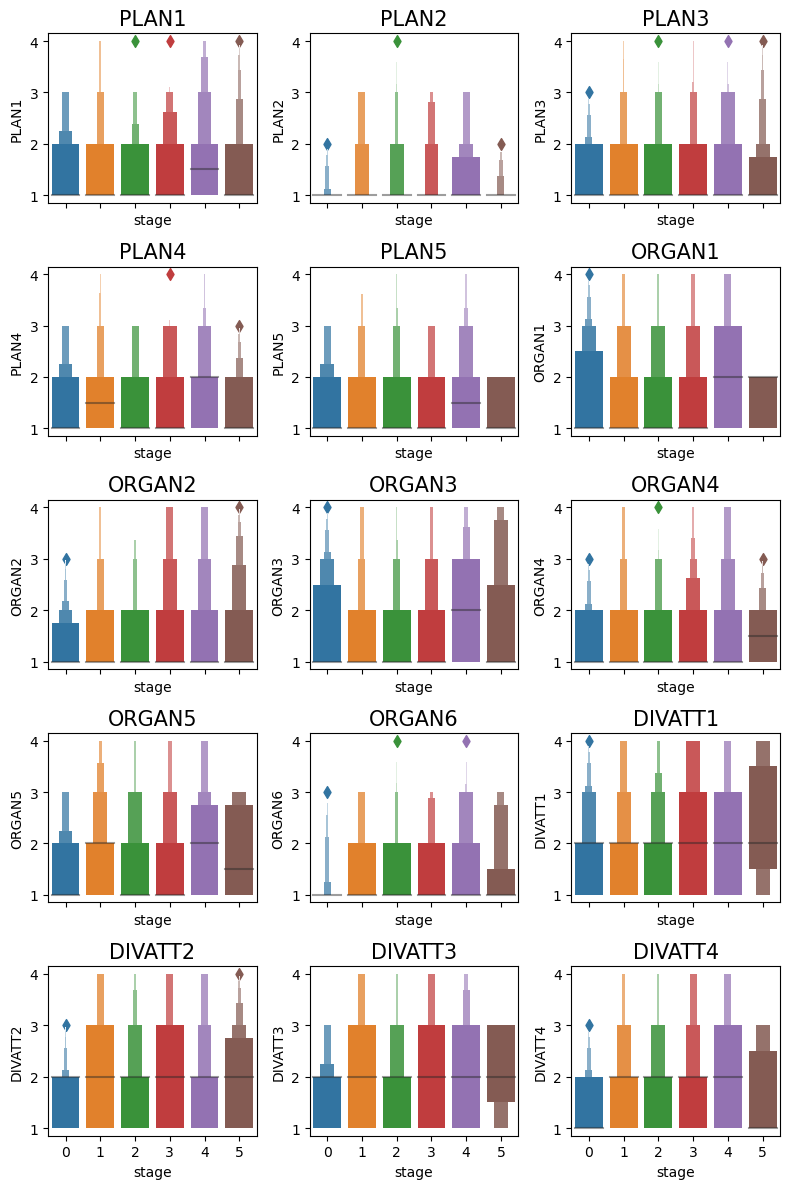

In [235]:
test_name = "ecogpt2_test"
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", 
        "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1", "DIVATT2", "DIVATT3", "DIVATT4"]
fig, ax = plt.subplots(5,3, figsize=(8,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [236]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# NPI testing

In [237]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NPI_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

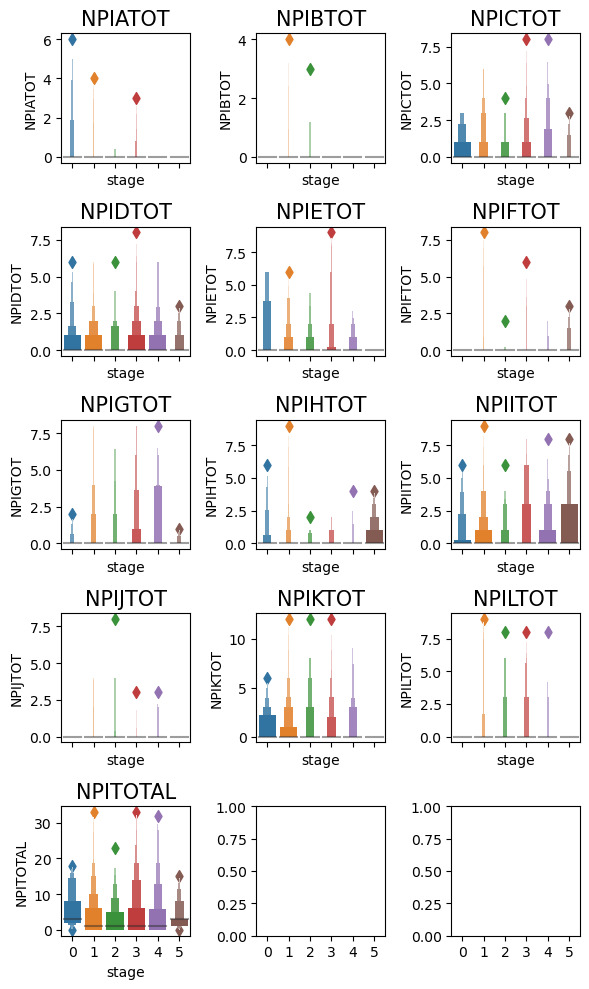

In [238]:
test_name="NPI_test"
flds = ["NPIATOT","NPIBTOT","NPICTOT","NPIDTOT","NPIETOT","NPIFTOT","NPIGTOT","NPIHTOT",
        "NPIITOT","NPIJTOT","NPIKTOT","NPILTOT","NPITOTAL"]
fig, ax = plt.subplots(5,3, figsize=(6,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [239]:
dir_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/figures_4/neurobattery_run33_adj'

In [240]:
binary = []
test_name = "NPI_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



NPIATOT Shape (427, 176)
NPIBTOT Shape (427, 176)
NPICTOT Shape (427, 176)
NPIDTOT Shape (427, 176)
NPIETOT Shape (427, 176)
NPIFTOT Shape (427, 176)
NPIGTOT Shape (427, 176)
NPIHTOT Shape (427, 176)
NPIITOT Shape (427, 176)
NPIJTOT Shape (427, 176)
NPIKTOT Shape (427, 176)
NPILTOT Shape (427, 176)
NPITOTAL Shape (427, 176)


In [241]:
neurobat_df

chi-2-pval  spearmanr
NPIATOT     0.930464  -0.028377
NPIBTOT     0.294983  -0.052304
NPICTOT     0.734639  -0.011622
NPIDTOT     0.285335   0.005210
NPIETOT     0.349142  -0.010290
NPIFTOT     0.274674   0.057530
NPIGTOT     0.974705   0.074426
NPIHTOT     0.780452  -0.015248
NPIITOT     0.564390   0.041582
NPIJTOT     0.113904   0.009323
NPIKTOT     0.499962  -0.083670
NPILTOT     0.480257   0.056477
NPITOTAL    0.798470  -0.021742

In [242]:
fld = "NPIITOT"
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table.div(chi2_table.sum(axis=1), axis=0)

NPIITOT       0.0       1.0       2.0       3.0       4.0       6.0       8.0  \
subtype                                                                         
0.0      0.750000  0.063953  0.029070  0.046512  0.058140  0.046512  0.005814   
1.0      0.787879  0.090909  0.030303  0.030303  0.030303  0.020202  0.010101   
2.0      0.760563  0.154930  0.000000  0.028169  0.042254  0.014085  0.000000   
3.0      0.741176  0.105882  0.023529  0.047059  0.035294  0.011765  0.023529   

NPIITOT       9.0  
subtype            
0.0      0.000000  
1.0      0.000000  
2.0      0.000000  
3.0      0.011765

In [243]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE", "stage", "st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# NPIQ

In [244]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NPIQ_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

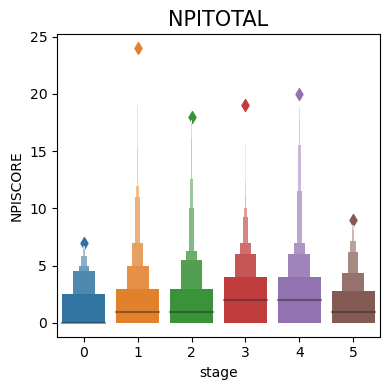

In [245]:
test_name="NPIQ_test"
flds = "NPISCORE"
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True)
df_mh_fld = df_mh.dropna(subset=[flds])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
sns.boxenplot(data=df_mh_fld,x="stage", y=flds, ax=ax)
ax.set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [246]:
flds = ["NPIA","NPIB","NPIC","NPID","NPIE","NPIF","NPIG","NPIH",
        "NPII","NPIJ","NPIK","NPIL"]
binary = []
test_name = "NPIQ_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



NPIA Shape (728, 52)
NPIB Shape (728, 52)
NPIC Shape (728, 52)
NPID Shape (728, 52)
NPIE Shape (728, 52)
NPIF Shape (728, 52)
NPIG Shape (728, 52)
NPIH Shape (728, 52)
NPII Shape (728, 52)
NPIJ Shape (728, 52)
NPIK Shape (728, 52)
NPIL Shape (728, 52)


In [247]:
neurobat_df

chi-2-pval  spearmanr
NPIA    0.099192   0.001321
NPIB    0.833310   0.036883
NPIC    0.475545   0.015318
NPID    0.059854   0.015235
NPIE    0.618540   0.018338
NPIF    0.749566   0.037679
NPIG    0.019831   0.112501
NPIH    0.777190   0.051922
NPII    0.244281  -0.000211
NPIJ    0.607270   0.033598
NPIK    0.351809  -0.068107
NPIL    0.327620   0.110120

In [248]:
fld = "NPIH"
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table.div(chi2_table.sum(axis=1), axis=0)

NPIH          0.0       1.0
subtype                    
0.0      0.902857  0.097143
1.0      0.908397  0.091603
2.0      0.891473  0.108527
3.0      0.872881  0.127119

## Only NPIH differs across subtypes,
## NPIH : Aggressive behaviour. More in subtype 2 which has more men.

# CCI

## Very little data (not useful)

In [249]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "CCI_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

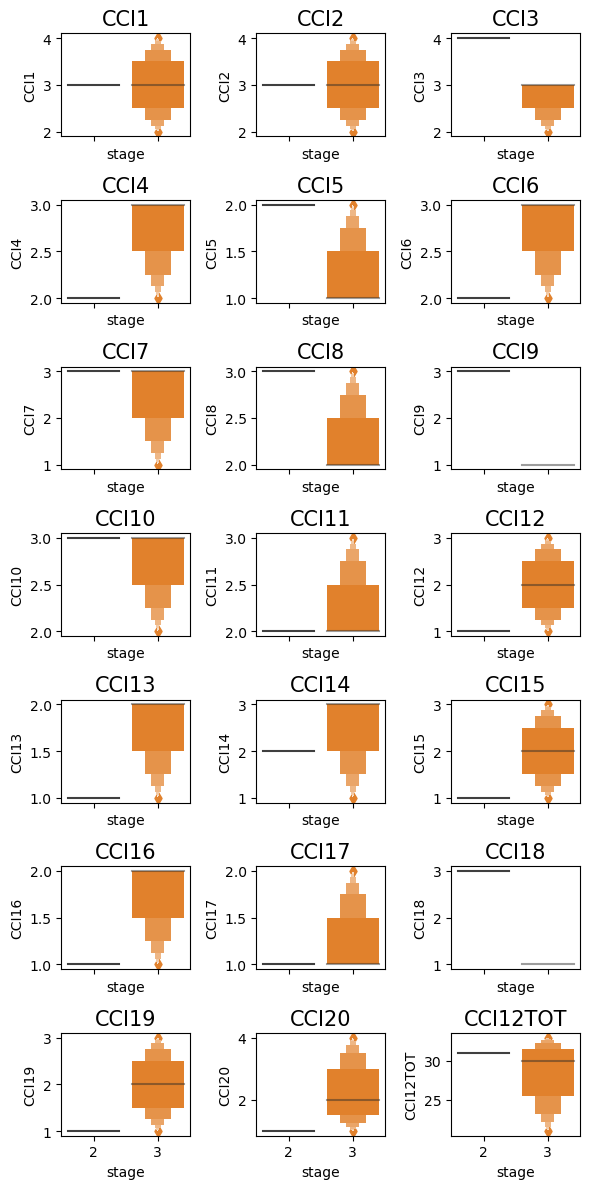

In [250]:
test_name="CCI_test"
flds = ["CCI1","CCI2","CCI3","CCI4","CCI5","CCI6","CCI7","CCI8","CCI9","CCI10",
        "CCI11","CCI12","CCI13","CCI14","CCI15","CCI16","CCI17","CCI18","CCI19","CCI20",
        "CCI12TOT"]
fig, ax = plt.subplots(7,3, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# MOCA

In [251]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MOCA_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
# del_cols = ["DELW1","DELW2","DELW3","DELW4","DELW5"]
# for dc in del_cols:
#     df_mh[dc] = df_mh[dc].replace([1,2,3],1)

TRAILS Shape (456, 66)
CUBE Shape (456, 66)
CLOCKCON Shape (456, 66)
CLOCKNO Shape (456, 66)
CLOCKHAN Shape (456, 66)
LION Shape (456, 66)
RHINO Shape (456, 66)
CAMEL Shape (456, 66)
IMMT1W1 Shape (456, 66)
IMMT1W2 Shape (456, 66)
IMMT1W3 Shape (456, 66)
IMMT1W4 Shape (456, 66)
IMMT1W5 Shape (456, 66)
IMMT2W1 Shape (456, 66)
IMMT2W2 Shape (456, 66)
IMMT2W3 Shape (456, 66)
IMMT2W4 Shape (456, 66)
IMMT2W5 Shape (456, 66)
DIGFOR Shape (456, 66)
DIGBACK Shape (456, 66)
LETTERS Shape (456, 66)
SERIAL1 Shape (456, 66)
SERIAL2 Shape (456, 66)
SERIAL3 Shape (456, 66)
SERIAL4 Shape (456, 66)
SERIAL5 Shape (456, 66)
REPEAT1 Shape (456, 66)
REPEAT2 Shape (456, 66)
FFLUENCY Shape (456, 66)
ABSTRAN Shape (456, 66)
ABSMEAS Shape (456, 66)
DELW1 Shape (454, 66)
DELW2 Shape (454, 66)
DELW3 Shape (454, 66)
DELW4 Shape (454, 66)
DELW5 Shape (454, 66)
DATE Shape (456, 66)
MONTH Shape (456, 66)
YEAR Shape (456, 66)
DAY Shape (456, 66)
PLACE Shape (456, 66)
CITY Shape (456, 66)


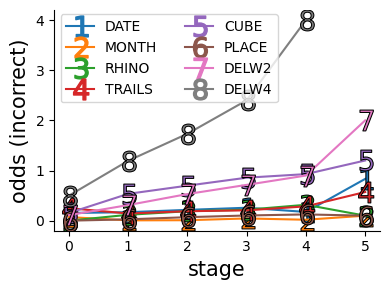

In [252]:
flds = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
        "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
        "IMMT2W5","DIGFOR","DIGBACK","LETTERS","SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
        "REPEAT1","REPEAT2","FFLUENCY","ABSTRAN","ABSMEAS","DELW1","DELW2","DELW3","DELW4","DELW5",
        "DATE","MONTH","YEAR","DAY","PLACE","CITY"]

# binary = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
#         "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
#         "IMMT2W5","DIGFOR","DIGBACK", "SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
#           "DELW1","DELW2","DELW3","DELW4","DELW5",
#         "REPEAT1","REPEAT2","ABSTRAN","ABSMEAS", "DATE","MONTH","YEAR","DAY","PLACE","CITY"]
binary = ["DATE", "MONTH", "RHINO", "TRAILS", "CUBE", "PLACE", "DELW2", "DELW4"]
test_name = "MOCA_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(4,3))

markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
lgnd = plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', borderaxespad=0, ncol=2)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(15)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds (incorrect)", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
fig.tight_layout()

# fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [253]:
moca_cube = ratio_df["CUBE"]

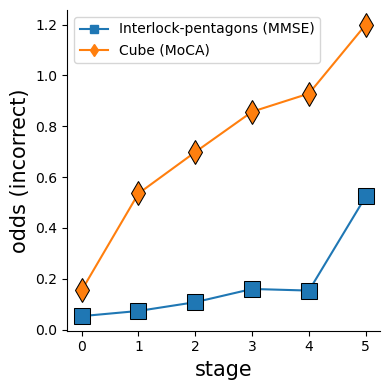

In [254]:
test_name = "cube_pent"
cube_pent_data = pd.concat([mmdraw,moca_cube],axis=1)
cube_pent_data.columns = ["Interlock-pentagons (MMSE)", "Cube (MoCA)"]
fig, ax = plt.subplots(1,1,figsize=(4,4))
sns.lineplot(data=cube_pent_data,dashes=False, markers=["s","d"], markersize=12, mec="k",ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds (incorrect)", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
ax.set_xticks([0,1,2,3,4,5])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)

In [255]:
dir_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole33_mixture_GMM/figures_4/neurobattery_run33_adj'

In [256]:
mmdraw

stage
0    0.052632
1    0.073034
2    0.107595
3    0.159624
4    0.153226
5    0.523810
Name: MMDRAW, dtype: float64

p-vals      coef   std-err  conf-int-lower95  conf-int-upper95  \
const     0.227978  1.059192  0.877366         -0.665083          2.783468   
PTGENDER  0.521503  0.092509  0.144199         -0.190883          0.375900   
APOE4     0.428837 -0.083401  0.105317         -0.290378          0.123577   
PTEDUCAT  0.002727 -0.079081  0.026240         -0.130649         -0.027512   
AGE       0.479387  0.006937  0.009799         -0.012322          0.026196   
stage     0.032947  0.127154  0.059435          0.010347          0.243961   
st1       0.627595  0.089220  0.183788         -0.271975          0.450415   
st2       0.399537 -0.172574  0.204652         -0.574773          0.229626   
st3       0.747334 -0.060899  0.188918         -0.432177          0.310380   

              fld  r-sq-adj  f-pvalue  
const     LETTERS  0.019407  0.032249  
PTGENDER  LETTERS  0.019407  0.032249  
APOE4     LETTERS  0.019407  0.032249  
PTEDUCAT  LETTERS  0.019407  0.032249  
AGE       LETTERS  0.019407  0.032249  
stage     LETTERS  0.019407  0.032249  
st1       LETTERS  0.019407  0.032249  
st2       LETTERS  0.019407  0.032249  
st3       LETTERS  0.019407  0.032249

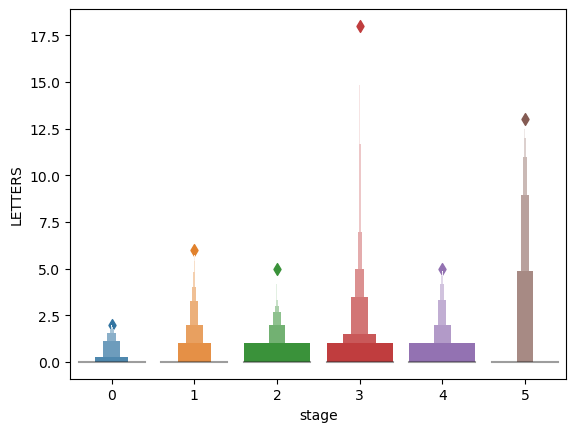

In [257]:
fld = "LETTERS"
df_mh_fld = process_df(df_mh, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld)
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
stats_df1 = regress_OLS(df_xx, fld, cov1)
stats_df1

In [258]:
flds = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
        "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
        "IMMT2W5","DIGFOR","DIGBACK", "SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
        "DELW1","DELW2","DELW3","DELW4","DELW5",
        "REPEAT1","REPEAT2","ABSTRAN","ABSMEAS", "DATE","MONTH","YEAR","DAY","PLACE","CITY"]
test_name = "moca_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.407344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.062339
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075903
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.409280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558935
 

LinAlgError: Singular matrix

In [259]:
fld = "LETTERS"
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
# df_xx = df_xx[df_xx[fld].isin([0,1])]
df_xx.dropna(inplace=True)
regress_OLS(df_xx, fld, cov1), regress_OLS(df_xx, fld, cov2) 

(            p-vals      coef   std-err  conf-int-lower95  conf-int-upper95  \
 const     0.227978  1.059192  0.877366         -0.665083          2.783468   
 PTGENDER  0.521503  0.092509  0.144199         -0.190883          0.375900   
 APOE4     0.428837 -0.083401  0.105317         -0.290378          0.123577   
 PTEDUCAT  0.002727 -0.079081  0.026240         -0.130649         -0.027512   
 AGE       0.479387  0.006937  0.009799         -0.012322          0.026196   
 stage     0.032947  0.127154  0.059435          0.010347          0.243961   
 st1       0.627595  0.089220  0.183788         -0.271975          0.450415   
 st2       0.399537 -0.172574  0.204652         -0.574773          0.229626   
 st3       0.747334 -0.060899  0.188918         -0.432177          0.310380   
 
               fld  r-sq-adj  f-pvalue  
 const     LETTERS  0.019407  0.032249  
 PTGENDER  LETTERS  0.019407  0.032249  
 APOE4     LETTERS  0.019407  0.032249  
 PTEDUCAT  LETTERS  0.019407  0.032249  
 AG

In [260]:
Counter(df_xx["DELW1"])

KeyError: 'DELW1'

# PDXCONV

In [261]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "DXSUM_PDXCONV_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

DXMPTR1 Shape (806, 51)
DXMPTR2 Shape (806, 51)
DXMPTR3 Shape (806, 51)
DXMPTR4 Shape (806, 51)
DXMPTR5 Shape (806, 51)
DXMPTR6 Shape (806, 51)
DXMDUE Shape (807, 51)
DXMOTHET Shape (808, 51)
DXDSEV Shape (153, 51)
DXDDUE Shape (66, 51)
DXAPP Shape (150, 51)
DXAPOSS Shape (808, 51)
DXODES Shape (5, 51)
DXDEP Shape (430, 51)
DXPARK Shape (460, 51)
DXPATYP Shape (1, 51)


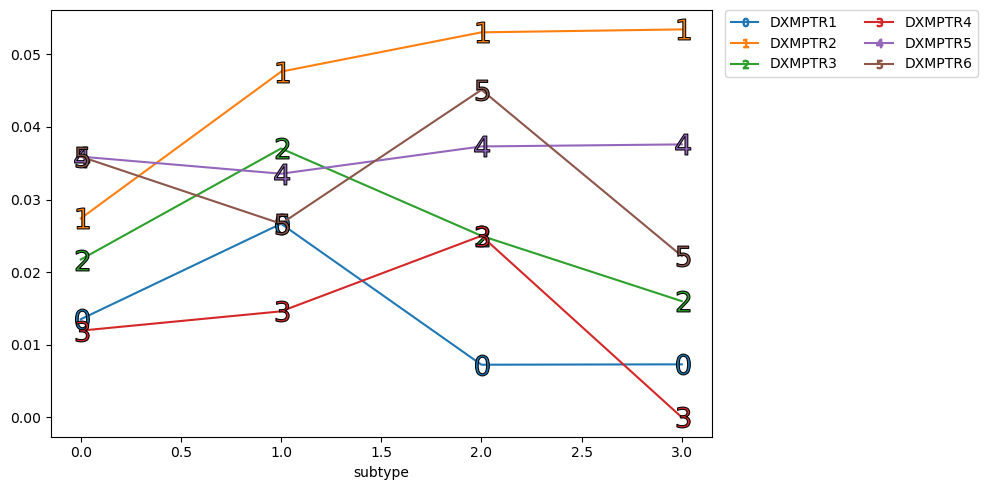

In [262]:
flds = ["DXMPTR1","DXMPTR2","DXMPTR3","DXMPTR4","DXMPTR5","DXMPTR6", "DXMDUE", "DXMOTHET", "DXDSEV", "DXDDUE",
        "DXAPP", "DXAPOSS", "DXODES", "DXDEP", "DXPARK", "DXPATYP"]

binary = ["DXMPTR1","DXMPTR2","DXMPTR3","DXMPTR4","DXMPTR5","DXMPTR6"]
test_name = "pdxconv"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

# dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(10,5))

markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncols=2)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [ ]:
neurobat_df

In [ ]:
multipletests(neurobat_df["chi-2-pval"],0.05,"fdr_bh")

In [ ]:
fld = "DXMPTR1"
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
print(fld, "Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table

# ECOGPT Results

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGPT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
# flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8"]
# flds = ["LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8"]
# flds = ["MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1",
 "DIVATT2", "DIVATT3", "DIVATT4"]
binary = []
test_name = "ecogpt"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


In [ ]:
neurobat_df

In [ ]:
fld = "ORGAN4"
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
print(fld, "Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]

In [ ]:
chi2_table

In [ ]:
neurobat_df

# ADAS

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNI1_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)

In [ ]:
flds = ["COT1SCOR", "COT2SCOR", "COT3SCOR", "COP7COMP","CO8NURSE","CO8MAGAZ","CO8WIZRD","CO8WIZRR","CO8VAN","CO8VANR","CO8LEPRD","CO8LEPRR"]
binary = []
test_name = "adas"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(10,5))

markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncols=2)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [ ]:
neurobat_df

# Comorbidity Analysis

## APOE4 genotype across subtypes

In [263]:
df_apoe4 = df_adnimerge[["PTID", "APOE4"]].dropna().sort_values("PTID").drop_duplicates("PTID", keep="first")
df_mh = pd.merge(final_df, df_apoe4, on=["PTID"], how="inner", suffixes=[None, "_y"])

In [264]:
chi2_table = df_mh.groupby(["subtype", "APOE4"]).size().unstack(level=1)
chi2_contingency(chi2_table.values)


(3.895638114273777,
 0.6907970149875056,
 6,
 array([[421.25710829, 292.52631579,  80.21657592],
        [162.34845735, 112.73684211,  30.91470054],
        [152.79854809, 106.10526316,  29.09618875],
        [140.59588627,  97.63157895,  26.77253479]]))

# Medical History

In [265]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "MEDHIST_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [266]:
# fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH8MUSCL", "MH9ENDO", "MH10GAST", "MH11HEMA", "MH12RENA", "MH13ALLE", 
#                "MH14ALCH", "MH15DRUG", "MH16SMOK", "MH17MALI", "MH18SURG"]
fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH9ENDO", "MH11HEMA", "MH12RENA", 
               "MH14ALCH", "MH16SMOK", "MH17MALI"]

ft = "MH19OTHR"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
print(chi2_table, "\n\n")
print(chi2_contingency(chi2_table.values))


MH19OTHR    0    1
subtype           
0.0       634  163
1.0       238   69
2.0       249   40
3.0       201   64 


(10.8033602942302, 0.01283811833412968, 3, array([[635.48492159, 161.51507841],
       [244.78528347,  62.21471653],
       [230.43305187,  58.56694813],
       [211.29674306,  53.70325694]]))


In [267]:
# fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH8MUSCL", "MH9ENDO", "MH10GAST", "MH11HEMA", "MH12RENA", "MH13ALLE", 
#                "MH14ALCH", "MH15DRUG", "MH16SMOK", "MH17MALI", "MH18SURG"]
fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH9ENDO", "MH11HEMA", "MH12RENA", 
               "MH14ALCH", "MH16SMOK", "MH17MALI"]
mh_dict = {}
for ft in fields_test:
    
    chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
    p_val = chi2_contingency(chi2_table.values)[1]
    st_max = (chi2_table[1]/chi2_table[0]).argmax()
    st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val, st_max, st_min)
    
    

In [268]:
# fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals", "st_max", "st_min"]
mh_df.sort_values("p-vals", inplace=True)

# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [269]:
mh_df

p-vals  st_max  st_min
MH2NEURL  0.075605       2       1
MH3HEAD   0.188227       2       0
MH6HEPAT  0.267395       3       0
MH17MALI  0.470226       1       0
MH7DERM   0.487255       3       0
MHPSYCH   0.569060       3       2
MH11HEMA  0.655941       1       3
MH9ENDO   0.682037       2       3
MH14ALCH  0.934414       2       3
MH16SMOK  0.934604       1       3
MH12RENA  0.941042       3       1
MH4CARD   0.969928       3       1

In [270]:
p_vec1 = mh_df["p-vals"].sort_values()
p_vec2 = np.arange(1, p_vec1.shape[0]+1)

In [271]:
from statsmodels.stats.multitest import fdrcorrection

In [272]:
multipletests(mh_df["p-vals"], method="fdr_bh", alpha=0.1)[1]

array([0.90726447, 0.96992837, 0.96992837, 0.96992837, 0.96992837,
       0.96992837, 0.96992837, 0.96992837, 0.96992837, 0.96992837,
       0.96992837, 0.96992837])

In [273]:
mh_df["adj-p"] = multipletests(mh_df["p-vals"], method="fdr_bh", alpha=0.1)[1]

In [274]:
mh_df

p-vals  st_max  st_min     adj-p
MH2NEURL  0.075605       2       1  0.907264
MH3HEAD   0.188227       2       0  0.969928
MH6HEPAT  0.267395       3       0  0.969928
MH17MALI  0.470226       1       0  0.969928
MH7DERM   0.487255       3       0  0.969928
MHPSYCH   0.569060       3       2  0.969928
MH11HEMA  0.655941       1       3  0.969928
MH9ENDO   0.682037       2       3  0.969928
MH14ALCH  0.934414       2       3  0.969928
MH16SMOK  0.934604       1       3  0.969928
MH12RENA  0.941042       3       1  0.969928
MH4CARD   0.969928       3       1  0.969928

In [275]:
ft = "MH17MALI"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
chi2_table["odds"] = chi2_table[1]/chi2_table[0]
chi2_table

MH17MALI    0    1      odds
subtype                     
0.0       624  173  0.277244
1.0       229   78  0.340611
2.0       216   73  0.337963
3.0       204   61  0.299020

In [276]:
chi2_contingency(chi2_table)

(2.867667830777515,
 0.8252632858738861,
 6,
 array([[6.11680562e+02, 1.84993728e+02, 6.02953429e-01],
        [2.35795364e+02, 7.13128163e+01, 2.32431161e-01],
        [2.21983518e+02, 6.71356281e+01, 2.18816376e-01],
        [2.03540556e+02, 6.15578272e+01, 2.00636548e-01]]))

In [277]:
df_mh

subtype  stage        DX        PTID   EXAMDATE VISCODE   RID  Phase  \
0         1.0    1.0  Controls  002_S_0295 2006-05-09      bl   295  ADNI1   
1         0.0    1.0  Controls  002_S_0413 2007-06-01     m12   413  ADNI1   
2         0.0    0.0  Controls  002_S_0559 2006-06-20      bl   559  ADNI1   
3         3.0    2.0        AD  002_S_0619 2006-12-13     m06   619  ADNI1   
4         3.0    2.0  Controls  002_S_0685 2010-07-15     m48   685  ADNI1   
...       ...    ...       ...         ...        ...     ...   ...    ...   
1653      3.0    2.0       MCI  941_S_4100 2015-08-28     m48  4100  ADNI2   
1654      0.0    1.0       MCI  941_S_4187 2011-08-25      bl  4187  ADNI2   
1655      1.0    3.0       MCI  941_S_4377 2012-02-14      bl  4377  ADNI2   
1656      0.0    2.0       MCI  941_S_4420 2012-04-03      bl  4420  ADNI2   
1657      2.0    4.0       MCI  941_S_4764 2012-06-11      bl  4764  ADNI2   

        ID      PTID_y  ...  MH15ADRUG MH15BDRUG MH16SMOK MH16ASMOK MH16BSMOK  \
0      636  002_S_0295  ...        NaN       NaN        0       NaN       NaN   
1      644  002_S_0413  ...        NaN       NaN        0       NaN       NaN   
2      870  002_S_0559  ...        NaN       NaN        1       NaN       NaN   
3      982  002_S_0619  ...        NaN       NaN        1       NaN       NaN   
4     1130  002_S_0685  ...        NaN       NaN        0       NaN       NaN   
...    ...         ...  ...        ...       ...      ...       ...       ...   
1653   254  941_S_4100  ...       -4.0      -4.0        1       1.0      45.0   
1654   408  941_S_4187  ...       -4.0      -4.0        0      -4.0      -4.0   
1655   896  941_S_4377  ...       -4.0      -4.0        1       1.0      15.0   
1656  1542  941_S_4420  ...       -4.0      -4.0        1       0.5       5.0   
1657  1898  941_S_4764  ...       -4.0      -4.0        0      -4.0      -4.0   

     MH16CSMOK MH17MALI  MH18SURG  MH19OTHR           update_stamp  
0          NaN        0         0         1  2006-04-04 00:00:00.0  
1          NaN        0         1         1  2006-04-06 00:00:00.0  
2          NaN        0         1         0  2006-05-11 00:00:00.0  
3          NaN        0         1         1  2006-05-25 00:00:00.0  
4          NaN        0         0         1  2006-06-23 00:00:00.0  
...        ...      ...       ...       ...                    ...  
1653      14.0        0         0         1  2012-11-16 12:24:57.0  
1654      -4.0        0         1         0  2012-11-16 12:24:57.0  
1655      20.0        0         1         0  2012-11-16 12:24:57.0  
1656      51.0        0         1         0  2012-11-16 12:24:57.0  
1657      -4.0        1         1         0  2012-11-16 12:24:57.0  

[1658 rows x 46 columns]

In [278]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [279]:
multipletests(mh_df["p-vals"], 0.05, "fdr_bh")

(array([False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([0.90726447, 0.96992837, 0.96992837, 0.96992837, 0.96992837,
        0.96992837, 0.96992837, 0.96992837, 0.96992837, 0.96992837,
        0.96992837, 0.96992837]),
 0.004265318777560645,
 0.004166666666666667)

# Subject Characteristics

## Parents history - not very useful (FAMHXPAR)

## Sibling History and parent history shows no effects

## Patient demographics

In [280]:
final_df

subtype  stage        DX        PTID   EXAMDATE VISCODE   RID
0        1.0    1.0  Controls  002_S_0295 2006-05-09      bl   295
1        0.0    1.0  Controls  002_S_0413 2007-06-01     m12   413
2        0.0    0.0  Controls  002_S_0559 2006-06-20      bl   559
3        3.0    2.0        AD  002_S_0619 2006-12-13     m06   619
4        3.0    2.0  Controls  002_S_0685 2010-07-15     m48   685
..       ...    ...       ...         ...        ...     ...   ...
803      3.0    2.0       MCI  941_S_4100 2015-08-28     m48  4100
804      0.0    1.0       MCI  941_S_4187 2011-08-25      bl  4187
805      1.0    3.0       MCI  941_S_4377 2012-02-14      bl  4377
806      0.0    2.0       MCI  941_S_4420 2012-04-03      bl  4420
807      2.0    4.0       MCI  941_S_4764 2012-06-11      bl  4764

[1658 rows x 7 columns]

## marriage and gender

In [386]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "PTDEMOG_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999],np.nan, inplace=True)

# df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
# df_mh.replace([-4,-1,9999], np.nan, inplace=True)

In [387]:
# PTMARRY, PTNOTRT
fields_test = ["PTGENDER", "PTHAND", "PTEDUCAT", "PTWORKHS",
               "PTNOTRT", "PTTLANG", "PTETHCAT", "PTRACCAT", "PTMARRY", "PTHOME"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[2]/chi2_table[1]).argmax()
#     st_min = (chi2_table[2]/chi2_table[1]).argmin()
    mh_dict[ft] = p_val
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
mh_df.sort_values("p-vals", inplace=True)
# _ = "PTNOTRT"
# df_mh_fld = df_mh.dropna(subset=[_])
# df_mh_fld.drop_duplicates("RID", keep="first",inplace=True)
# chi2_table = df_mh_fld.groupby(["subtype", _]).size().unstack(level=1).fillna(0)
# p_val = chi2_contingency(chi2_table.values)[1]
# chi2_table, p_val

In [388]:
mh_df["adj-pval"] = multipletests(mh_df["p-vals"], 0.1, "fdr_bh")[1]
mh_df

p-vals  adj-pval
PTMARRY   0.000376  0.003763
PTNOTRT   0.032255  0.161276
PTEDUCAT  0.063803  0.212676
PTTLANG   0.163995  0.352634
PTGENDER  0.176317  0.352634
PTRACCAT  0.273704  0.456174
PTHOME    0.345790  0.493985
PTETHCAT  0.429294  0.536617
PTHAND    0.564900  0.627666
PTWORKHS  1.000000  1.000000

In [377]:
ft = "PTNOTRT"
df_mh_fld = df_mh.dropna(subset=ft)
chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
print(chi2_table, "\n\n")
chi2_contingency(chi2_table[[0,1]])
# print(chi2_table,"\n\n")
# print(chi2_table.T.div(chi2_table.sum(axis=0), axis=0))

PTNOTRT  0.0  1.0  2.0
subtype               
0.0      132  562    6
1.0       63  204    3
2.0       32  198    6
3.0       36  201    3 




(9.68129087399956,
 0.021478921990502806,
 3,
 array([[127.81652661, 566.18347339],
        [ 49.17436975, 217.82563025],
        [ 42.35994398, 187.64005602],
        [ 43.64915966, 193.35084034]]))

In [378]:
df_mh_fld

subtype  stage        DX        PTID   EXAMDATE VISCODE   RID  PHASE  \
0         1.0    1.0  Controls  002_S_0295 2006-05-09      bl   295  ADNI1   
2         0.0    0.0  Controls  002_S_0559 2006-06-20      bl   559  ADNI1   
3         0.0    4.0        AD  002_S_0955 2006-10-25      bl   955  ADNI1   
4         2.0    2.0        AD  002_S_1018 2006-12-14      bl  1018  ADNI1   
5         0.0    3.0  Controls  002_S_1261 2007-02-27      bl  1261  ADNI1   
...       ...    ...       ...         ...        ...     ...   ...    ...   
1444      1.0    2.0       MCI  941_S_4036 2011-07-06      bl  4036  ADNI2   
1445      0.0    1.0       MCI  941_S_4187 2011-08-25      bl  4187  ADNI2   
1446      1.0    3.0       MCI  941_S_4377 2012-02-14      bl  4377  ADNI2   
1447      0.0    2.0       MCI  941_S_4420 2012-04-03      bl  4420  ADNI2   
1448      2.0    4.0       MCI  941_S_4764 2012-06-11      bl  4764  ADNI2   

          PTID_y VISCODE_y  ... PTBIRPR PTBIRGR    ID  SITEID    USERDATE  \
0     002_S_0295        sc  ...     NaN     NaN   706     101  2006-04-04   
2     002_S_0559        sc  ...     NaN     NaN  1028     101  2006-05-11   
3     002_S_0955        sc  ...     NaN     NaN  1850     101  2006-10-02   
4     002_S_1018        sc  ...     NaN     NaN  2194     101  2006-11-21   
5     002_S_1261        sc  ...     NaN     NaN  2520     101  2007-01-30   
...          ...       ...  ...     ...     ...   ...     ...         ...   
1444  941_S_4036       v01  ...     NaN     NaN   110      58  2011-05-05   
1445  941_S_4187       v01  ...     NaN     NaN   458      58  2011-08-15   
1446  941_S_4377       v01  ...     NaN     NaN   974      58  2011-11-16   
1447  941_S_4420       v01  ...     NaN     NaN  1664      58  2012-03-13   
1448  941_S_4764       v01  ...     NaN     NaN  2054      58  2012-05-24   

       USERDATE2  DD_CRF_VERSION_LABEL  LANGUAGE_CODE  HAS_QC_ERROR  \
0            NaN                   NaN            NaN           NaN   
2            NaN                   NaN            NaN           NaN   
3            NaN                   NaN            NaN           NaN   
4            NaN                   NaN            NaN           NaN   
5            NaN                   NaN            NaN           NaN   
...          ...                   ...            ...           ...   
1444         NaN                   NaN            NaN           NaN   
1445         NaN                   NaN            NaN           NaN   
1446  2011-11-16                   NaN            NaN           NaN   
1447  2012-04-13                   NaN            NaN           NaN   
1448         NaN                   NaN            NaN           NaN   

               update_stamp  
0     2006-04-04 00:00:00.0  
2     2006-05-11 00:00:00.0  
3     2006-10-02 00:00:00.0  
4     2006-11-21 00:00:00.0  
5     2007-01-30 00:00:00.0  
...                     ...  
1444  2013-05-30 10:05:05.0  
1445  2013-05-30 10:05:05.0  
1446  2013-05-30 10:05:05.0  
1447  2013-05-30 10:05:05.0  
1448  2013-05-30 10:05:05.0  

[1446 rows x 86 columns]

In [381]:
ft = "PTGENDER"
df_mh_fld = df_mh.dropna(subset=ft)
chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
print(chi2_table,"\n\n")
chi2_contingency(chi2_table[[1,2]])

PTGENDER  1.0  2.0
subtype           
0.0       379  312
1.0       148  121
2.0       123  111
3.0       148   91 




(4.939026084014105,
 0.17631679002698392,
 3,
 array([[384.79972087, 306.20027913],
        [149.79902303, 119.20097697],
        [130.30844382, 103.69155618],
        [133.09281228, 105.90718772]]))

In [379]:
ft = "PTMARRY"
df_mh_fld = df_mh.dropna(subset=ft)
chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
# print(chi2_table,"\n\n")
chi2_table["no"] = chi2_table[[2,3,4,5]].sum(axis=1)
chi2_marry = chi2_table[[1.0, "no"]]
chi2_marry.div(chi2_marry.sum(axis=1), axis=0)

KeyError: '[3, 4, 5] not in index'

# PTCOGBEG, PTADBEG - beginning of cog decline and AD

In [389]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "PTDEMOG_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999],np.nan, inplace=True)

In [390]:
df_mh["PTADDX"].fillna(df_mh["PTADBEG"], inplace=True)
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

In [391]:
fld = "PTCOGBEG"
ptid_list = cnad_ptid + mci_ptid
df_mh_subset = df_mh[df_mh["PTID"].isin(ptid_list)]
df_mh_subset.dropna(subset=fld, inplace=True)
df_mh_subset.sort_values(["PTID", "VISDATE"], inplace=True)
df_mh_subset.drop_duplicates("PTID",keep="first",inplace=True)
cogbeg_dict = dict(zip(df_mh_subset["PTID"], df_mh_subset[fld]))

fld = "PTADDX"
df_mh_subset = df_mh[df_mh["PTID"].isin(ptid_list)]
df_mh_subset.dropna(subset=fld, inplace=True)
df_mh_subset.sort_values(["PTID", "VISDATE"], inplace=True)
df_mh_subset.drop_duplicates("PTID",keep="first",inplace=True)
adbeg_dict = dict(zip(df_mh_subset["PTID"], df_mh_subset[fld]))

In [392]:

df_temp = final_df.merge(df_long, left_on=["PTID", "EXAMDATE"], right_on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_y"])
df_temp = df_temp[["PTID", "subtype", "stage", "APOE4", "PTGENDER", "PTEDUCAT"]]
df_temp["PTGENDER"] = df_temp["PTGENDER"].map({"Male":1, "Female":0})
# df_long.sort_valuesdrop_duplicates( ["APOE4"]

In [393]:
cogbeg_df = pd.DataFrame.from_dict(cogbeg_dict, orient="index", columns=["cogbeg"])
adbeg_df = pd.DataFrame.from_dict(adbeg_dict, orient="index", columns=["adbeg"])
df_beg = cogbeg_df.merge(adbeg_df, left_index=True, right_index=True, how="outer")
df_beg = df_beg.merge(df_mh[["PTID", "PTDOBYY"]].dropna(subset="PTDOBYY").drop_duplicates("PTID"), 
             left_index=True, right_on="PTID", how="inner")

# df_beg = df_beg.merge(final_df, left_on="PTID", right_on="PTID", how="inner")
df_beg = df_beg.merge(df_temp, left_on="PTID", right_on="PTID", how="inner")
df_beg["subtype"] = df_beg["subtype"].astype(int)
df_beg["subtype"] += 1
df_beg["AGEADBEG"] = df_beg["adbeg"] - df_beg["PTDOBYY"]
df_beg["AGECOGBEG"] = df_beg["cogbeg"] - df_beg["PTDOBYY"]
df_beg_ad = df_beg.dropna(subset="AGEADBEG")
df_beg_cog = df_beg.dropna(subset="AGECOGBEG")
df_beg_ad.rename(columns={"AGEADBEG":"age"}, inplace=True)
df_beg_ad["onset"] = "AD onset"
df_beg_cog.rename(columns={"AGECOGBEG":"age"}, inplace=True)
df_beg_cog["onset"] = "cognitive symptoms"




In [394]:
df_beg_cog

cogbeg   adbeg        PTID  PTDOBYY  subtype  stage  APOE4  PTGENDER  \
1    2005.0  2009.0  002_S_0729   1941.0        1    3.0    1.0         0   
6    2001.0     NaN  002_S_1155   1949.0        4    4.0    0.0         1   
7    2007.0     NaN  002_S_1268   1924.0        3    2.0    1.0         1   
8    2008.0     NaN  002_S_2010   1947.0        2    1.0    1.0         0   
9    2005.0     NaN  002_S_2043   1938.0        2    2.0    1.0         0   
..      ...     ...         ...      ...      ...    ...    ...       ...   
959  1997.0     NaN  941_S_4036   1937.0        2    2.0    0.0         1   
960  2006.0     NaN  941_S_4187   1949.0        1    1.0    0.0         1   
961  2008.0     NaN  941_S_4377   1942.0        2    3.0    1.0         0   
962  2010.0     NaN  941_S_4420   1930.0        1    2.0    0.0         1   
963  2000.0     NaN  941_S_4764   1929.0        3    4.0    0.0         0   

     PTEDUCAT  AGEADBEG   age               onset  
1          16      68.0  64.0  cognitive symptoms  
6          20       NaN  52.0  cognitive symptoms  
7          20       NaN  83.0  cognitive symptoms  
8          20       NaN  61.0  cognitive symptoms  
9          20       NaN  67.0  cognitive symptoms  
..        ...       ...   ...                 ...  
959        20       NaN  60.0  cognitive symptoms  
960        16       NaN  57.0  cognitive symptoms  
961        12       NaN  66.0  cognitive symptoms  
962        18       NaN  80.0  cognitive symptoms  
963        20       NaN  71.0  cognitive symptoms  

[775 rows x 12 columns]

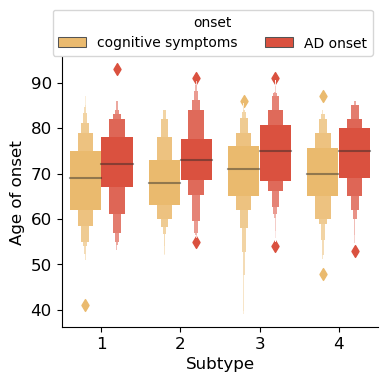

In [395]:
fig, ax = plt.subplots(figsize=(4,4))
sns.boxenplot(data=pd.concat([df_beg_cog, df_beg_ad], axis=0), 
              x="subtype", y="age", hue="onset", orient="v",
             palette=palette_color1, linewidth=1.5, color="g")
ax.set_xlabel("Subtype", fontsize=12)
ax.set_ylabel("Age of onset", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(ncols=2, title="onset",loc='upper left', bbox_to_anchor=(-.05, 1.2))
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "age-onset.png"), dpi=300)


## Age of cognitive symptom onset adjusted for gender, education, and APOE4 

KruskalResult(statistic=5.94738945739238, pvalue=0.11419808647327809)

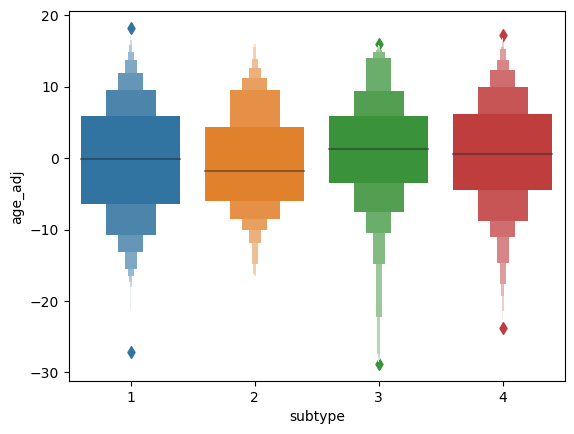

In [396]:
df_regress = df_beg_cog.dropna(subset=["age", "APOE4", "PTGENDER", "PTEDUCAT"])
model = sm.OLS(df_regress[["age"]], sm.add_constant(df_regress[["APOE4", "PTGENDER", "PTEDUCAT"]]))
result = model.fit()
df_regress["age_adj"] = result.resid
sns.boxenplot(data=df_regress, x="subtype", y="age_adj")
kruskal(*[group["age_adj"].values for name, group in df_regress.groupby("subtype")])

## Age of AD diagnosis adjusted for gender, education, and APOE4 

KruskalResult(statistic=5.262980798536807, pvalue=0.15352262823713958)

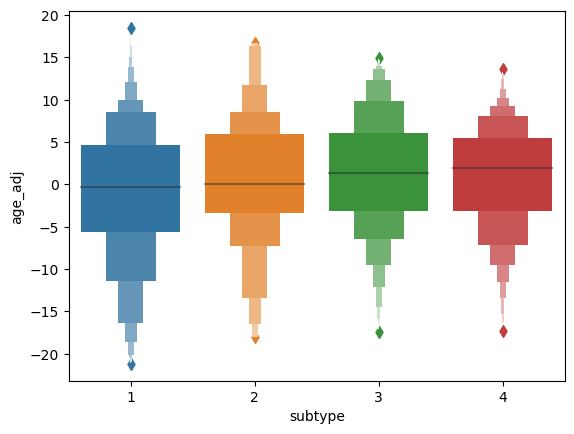

In [397]:
df_regress = df_beg_ad.dropna(subset=["age", "APOE4", "PTGENDER", "PTEDUCAT"])
model = sm.OLS(df_regress[["age"]], sm.add_constant(df_regress[["APOE4", "PTGENDER", "PTEDUCAT"]]))
result = model.fit()
df_regress["age_adj"] = result.resid
sns.boxenplot(data=df_regress, x="subtype", y="age_adj")
kruskal(*[group["age_adj"].values for name, group in df_regress.groupby("subtype")])

In [296]:
df_beg

cogbeg   adbeg        PTID  PTDOBYY  subtype  stage  APOE4  PTGENDER  \
0       NaN  1993.0  002_S_0619   1928.0        4    2.0    2.0         1   
1    2005.0  2009.0  002_S_0729   1941.0        1    3.0    1.0         0   
2       NaN  2005.0  002_S_0816   1935.0        1    2.0    2.0         1   
3       NaN  1998.0  002_S_0938   1924.0        1    3.0    0.0         0   
4       NaN  2001.0  002_S_0955   1928.0        1    4.0    1.0         0   
..      ...     ...         ...      ...      ...    ...    ...       ...   
959  1997.0     NaN  941_S_4036   1937.0        2    2.0    0.0         1   
960  2006.0     NaN  941_S_4187   1949.0        1    1.0    0.0         1   
961  2008.0     NaN  941_S_4377   1942.0        2    3.0    1.0         0   
962  2010.0     NaN  941_S_4420   1930.0        1    2.0    0.0         1   
963  2000.0     NaN  941_S_4764   1929.0        3    4.0    0.0         0   

     PTEDUCAT  AGEADBEG  AGECOGBEG  
0          12      65.0        NaN  
1          16      68.0       64.0  
2          20      70.0        NaN  
3          16      74.0        NaN  
4          16      73.0        NaN  
..        ...       ...        ...  
959        20       NaN       60.0  
960        16       NaN       57.0  
961        12       NaN       66.0  
962        18       NaN       80.0  
963        20       NaN       71.0  

[964 rows x 11 columns]

p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.009e-01 U_stat=2.655e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.672e-02 (ns) U_stat=8.986e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.619e-01 U_stat=1.029e+04
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.111e-01 U_stat=2.182e+04
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.190e-02 U_stat=9.316e+03
1 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.818e-01 U_stat=2.251e+04


KruskalResult(statistic=6.2713403044743, pvalue=0.09912986418679227)

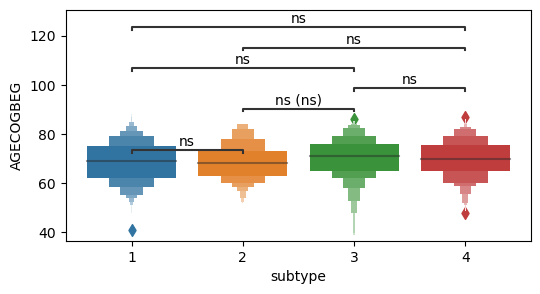

In [297]:
_="AGECOGBEG"
pairs = [(1,2),(2,3),(3,4),(1,3),(1,4),(2,4)]
fig, ax = plt.subplots(1,1, figsize=(6,3), sharey=True)
df_mh_cog = df_beg.dropna(subset=[_])
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax)
annotator = Annotator(ax, pairs, data=df_mh_cog, x="subtype", y=_)
annotator._pvalue_format.pvalue_thresholds =  [[1e-4, '*'], [1e-6, '**'], [1e-8, '***'], [1e-10, '****'], [1, 'ns']]
annotator.configure(test='Mann-Whitney', text_format='star', 
                    loc='inside',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

KruskalResult(statistic=6.477449209945754, pvalue=0.09055610651925)

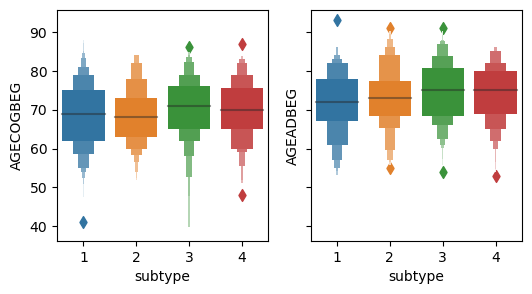

In [298]:
_="AGECOGBEG"
fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)
df_mh_cog = df_beg.dropna(subset=[_])
# df_mh_cog.drop_duplicates("PTID",keep="first",inplace=True)
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax[0])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

_="AGEADBEG"
df_mh_ad = df_beg.dropna(subset=[_])
# df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax[1])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

In [299]:
df_mh_ad.groupby("subtype")["AGEADBEG"].median() - df_mh_cog.groupby("subtype")["AGECOGBEG"].median()


subtype
1    3.0
2    5.0
3    4.0
4    5.0
dtype: float64

In [300]:
df_mh["AGEADBEG"] = df_mh["PTADDX"] - df_mh["PTDOBYY"]
df_mh["AGECOGBEG"] = df_mh["PTCOGBEG"] - df_mh["PTDOBYY"]

KruskalResult(statistic=6.477449209945754, pvalue=0.09055610651925)

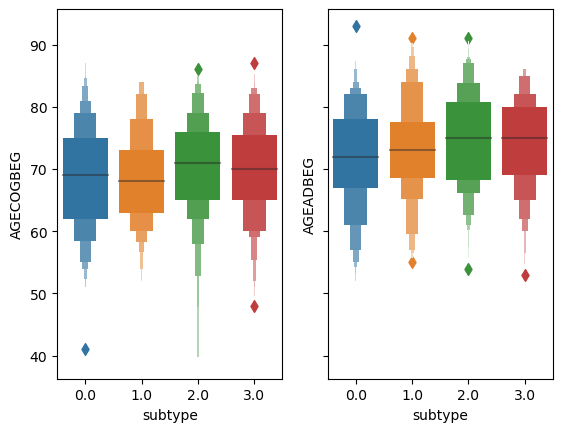

In [301]:
_="AGECOGBEG"
fig, ax = plt.subplots(1,2, sharey=True)
df_mh_cog = df_mh.dropna(subset=[_])
df_mh_cog.drop_duplicates("PTID",keep="first",inplace=True)
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax[0])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

_="AGEADBEG"
df_mh_ad = df_mh.dropna(subset=[_])
df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax[1])
# df_mh_fld_ad["onset"] = "AD"
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

KruskalResult(statistic=6.477449209945754, pvalue=0.09055610651925)

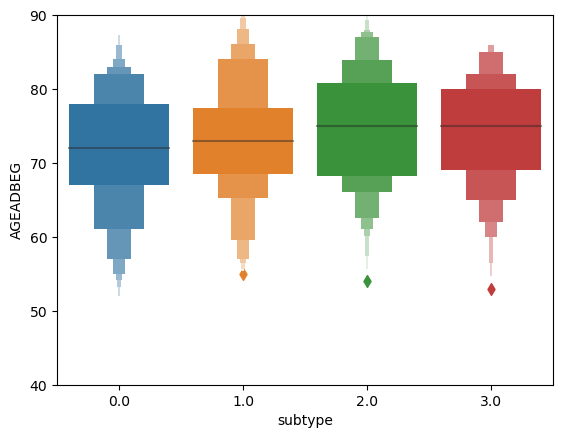

In [302]:
_="AGEADBEG"
fig, ax = plt.subplots()
df_mh_ad = df_mh.dropna(subset=[_])
df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax)
# df_mh_fld_ad["onset"] = "AD"
ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

<AxesSubplot: xlabel='subtype', ylabel='AGEADBEG'>

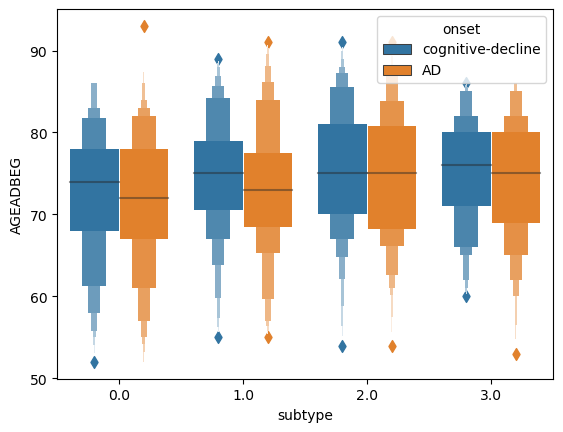

In [303]:
df_onset = pd.concat([df_mh_cog, df_mh_ad], axis=0)
sns.boxenplot(data=df_onset, x="subtype", y=_, hue="onset")

In [304]:
df_onset

subtype  stage        DX        PTID   EXAMDATE VISCODE   RID   PHASE  \
27        0.0    2.0        AD  002_S_5018 2012-11-15      bl  5018   ADNI2   
28        0.0    2.0  Controls  002_S_5178 2013-05-28      bl  5178   ADNI2   
30        2.0    2.0  Controls  002_S_5256 2013-07-30      bl  5256   ADNI2   
45        3.0    3.0        AD  003_S_4136 2011-08-23      bl  4136   ADNI2   
46        0.0    4.0        AD  003_S_4152 2011-09-27      bl  4152   ADNI2   
...       ...    ...       ...         ...        ...     ...   ...     ...   
2368      3.0    4.0       MCI  137_S_0973 2007-05-22     m06   973  ADNIGO   
2383      0.0    1.0       MCI  137_S_4815 2012-09-04      bl  4815   ADNI2   
2390      2.0    3.0       MCI  141_S_0697 2006-09-14      bl   697   ADNI2   
2393      0.0    3.0       MCI  141_S_0915 2006-10-31      bl   915   ADNI2   
2405      0.0    3.0       MCI  141_S_1255 2007-03-09      bl  1255  ADNIGO   

          PTID_y VISCODE_y  ... SITEID    USERDATE   USERDATE2  \
27    002_S_5018       v01  ...      1  2012-10-29         NaN   
28    002_S_5178       v01  ...      1  2013-05-08         NaN   
30    002_S_5256       v01  ...      1  2013-07-02         NaN   
45    003_S_4136       v01  ...      2  2011-07-27         NaN   
46    003_S_4152       v01  ...      2  2011-07-27  2011-08-02   
...          ...       ...  ...    ...         ...         ...   
2368  137_S_0973        sc  ...     55  2010-12-06  2011-03-09   
2383  137_S_4815       v01  ...     55  2012-06-20  2012-08-30   
2390  141_S_0697       v06  ...     56  2011-10-20  2013-10-09   
2393  141_S_0915       v06  ...     56  2012-01-11         NaN   
2405  141_S_1255        sc  ...     56  2011-03-16  2012-07-05   

      DD_CRF_VERSION_LABEL LANGUAGE_CODE  HAS_QC_ERROR           update_stamp  \
27                     NaN           NaN           NaN  2013-05-30 10:05:05.0   
28                     NaN           NaN           NaN  2013-05-30 10:05:05.0   
30                     NaN           NaN           NaN  2013-07-03 19:18:57.0   
45                     NaN           NaN           NaN  2013-05-30 10:05:05.0   
46                     NaN           NaN           NaN  2013-05-30 10:05:05.0   
...                    ...           ...           ...                    ...   
2368                   NaN           NaN           NaN  2012-11-16 09:42:47.0   
2383                   NaN           NaN           NaN  2013-05-30 10:05:05.0   
2390                   NaN           NaN           NaN  2013-10-09 19:19:30.0   
2393                   NaN           NaN           NaN  2013-05-30 10:05:05.0   
2405                   NaN           NaN           NaN  2012-11-16 09:42:47.0   

      AGEADBEG  AGECOGBEG              onset  
27        73.0       69.0  cognitive-decline  
28         NaN       66.0  cognitive-decline  
30         NaN       68.0  cognitive-decline  
45        66.0       66.0  cognitive-decline  
46        57.0       56.0  cognitive-decline  
...        ...        ...                ...  
2368      80.0       75.0                 AD  
2383      69.0       69.0                 AD  
2390      91.0       76.0                 AD  
2393      84.0       79.0                 AD  
2405      80.0       76.0                 AD  

[1169 rows x 89 columns]

In [305]:
# fig, ax = plt.subplots(1,2,figsize=(6,3))
df_mh_cog_beg = df_mh.dropna(subset=["AGECOGBEG"])
# sns.boxenplot(data=df_mh_fld, x="subtype", y=_, ax = ax[0])
# kruskal(*[group[_].values for name, group in df_mh_fld.groupby("subtype")])
df_mh_ad_beg = df_mh.dropna(subset=["AGEADBEG"])



In [306]:
df_assess

PHASE         PTID    RID VISCODE VISCODE2    VISDATE  PTSOURCE  \
1      ADNI1   022_S_0001      1       f        f 2005-08-18       1.0   
0      ADNI1   011_S_0002      2      sc       bl 2005-08-17       1.0   
1571  ADNIGO   011_S_0002      2      sc       bl 2010-09-22       1.0   
2404   ADNI2   011_S_0002      2     v06      m72 2011-09-19       1.0   
2      ADNI1   011_S_0003      3      sc       bl 2005-08-18       1.0   
...      ...          ...    ...     ...      ...        ...       ...   
5057   ADNI4  941_S_10111  10111    4_sc      NaN 2024-04-25       1.0   
5062   ADNI4  036_S_10112  10112    4_sc      NaN 2024-04-29       1.0   
5063   ADNI4  073_S_10113  10113    4_sc      NaN 2024-04-30       1.0   
5069   ADNI4  021_S_10114  10114    4_sc      NaN 2024-05-02       1.0   
5073   ADNI4  033_S_10118  10118    4_sc      NaN 2024-05-08       1.0   

      PTGENDER    PTDOB  PTDOBYY  ...  PTBIRPR  PTBIRGR     ID  SITEID  \
1          2.0  12/1944   1944.0  ...      NaN      NaN     20      10   
0          1.0  04/1931   1931.0  ...      NaN      NaN     18     107   
1571       1.0  04/1931   1931.0  ...      NaN      NaN    304       8   
2404       1.0  04/1931   1931.0  ...      NaN      NaN    636       8   
2          1.0  05/1924   1924.0  ...      NaN      NaN     22     107   
...        ...      ...      ...  ...      ...      ...    ...     ...   
5057       2.0  12/1953   1953.0  ...      0.0      0.0  14253     941   
5062       1.0  08/1953   1953.0  ...      0.0      0.0  14565      36   
5063       2.0  07/1965   1965.0  ...      0.0      0.0  14802      73   
5069       2.0  12/1950   1950.0  ...      1.0      1.0  15514      21   
5073       1.0  03/1946   1946.0  ...      1.0      1.0  15620      33   

        USERDATE   USERDATE2  DD_CRF_VERSION_LABEL  LANGUAGE_CODE  \
1     2005-08-18         NaN                   NaN            NaN   
0     2005-08-17         NaN                   NaN            NaN   
1571  2010-09-22         NaN                   NaN            NaN   
2404  2011-09-20         NaN                   NaN            NaN   
2     2005-08-18         NaN                   NaN            NaN   
...          ...         ...                   ...            ...   
5057  2024-04-26  2024-04-26                    v1              e   
5062  2024-04-29  2024-04-29                    v1              e   
5063  2024-04-30  2024-04-30                    v1              e   
5069  2024-05-07  2024-05-07                    v1              e   
5073  2024-05-09  2024-05-09                    v1              e   

      HAS_QC_ERROR           update_stamp  
1              NaN  2005-08-18 00:00:00.0  
0              NaN  2005-08-17 00:00:00.0  
1571           NaN  2013-03-22 15:23:58.0  
2404           NaN  2013-05-30 10:05:05.0  
2              NaN  2005-08-18 00:00:00.0  
...            ...                    ...  
5057           0.0  2024-04-27 01:40:12.0  
5062           0.0  2024-04-30 01:40:49.0  
5063           0.0  2024-05-01 01:38:35.0  
5069           0.0  2024-05-08 01:41:10.0  
5073           0.0  2024-05-10 01:40:18.0  

[5074 rows x 80 columns]

In [307]:
df_mh_ad_beg

subtype  stage   DX        PTID   EXAMDATE VISCODE   RID   PHASE  \
6         3.0    2.0   AD  002_S_0619 2006-12-13     m06   619   ADNI1   
11        0.0    2.0   AD  002_S_0816 2007-03-28     m06   816   ADNI1   
12        0.0    3.0   AD  002_S_0938 2008-10-23     m24   938   ADNI1   
13        0.0    4.0   AD  002_S_0955 2006-10-25      bl   955   ADNI1   
14        2.0    2.0   AD  002_S_1018 2006-12-14      bl  1018   ADNI1   
...       ...    ...  ...         ...        ...     ...   ...     ...   
2383      0.0    1.0  MCI  137_S_4815 2012-09-04      bl  4815   ADNI2   
2390      2.0    3.0  MCI  141_S_0697 2006-09-14      bl   697   ADNI2   
2393      0.0    3.0  MCI  141_S_0915 2006-10-31      bl   915   ADNI2   
2405      0.0    3.0  MCI  141_S_1255 2007-03-09      bl  1255  ADNIGO   
2406      0.0    3.0  MCI  141_S_1255 2007-03-09      bl  1255   ADNI2   

          PTID_y VISCODE_y  ...      ID SITEID    USERDATE   USERDATE2  \
6     002_S_0619        sc  ...  1164.0    101  2006-05-25         NaN   
11    002_S_0816        sc  ...  1584.0    101  2006-08-16         NaN   
12    002_S_0938        sc  ...  1794.0    101  2006-09-20         NaN   
13    002_S_0955        sc  ...  1850.0    101  2006-10-02         NaN   
14    002_S_1018        sc  ...  2194.0    101  2006-11-21         NaN   
...          ...       ...  ...     ...    ...         ...         ...   
2383  137_S_4815       v01  ...  2170.0     55  2012-06-20  2012-08-30   
2390  141_S_0697       v06  ...   826.0     56  2011-10-20  2013-10-09   
2393  141_S_0915       v06  ...  1230.0     56  2012-01-11         NaN   
2405  141_S_1255        sc  ...  1060.0     56  2011-03-16  2012-07-05   
2406  141_S_1255       v06  ...  1642.0     56  2012-03-09  2013-10-17   

     DD_CRF_VERSION_LABEL  LANGUAGE_CODE  HAS_QC_ERROR           update_stamp  \
6                     NaN            NaN           NaN  2006-05-25 00:00:00.0   
11                    NaN            NaN           NaN  2006-08-16 00:00:00.0   
12                    NaN            NaN           NaN  2006-09-20 00:00:00.0   
13                    NaN            NaN           NaN  2006-10-02 00:00:00.0   
14                    NaN            NaN           NaN  2006-11-21 00:00:00.0   
...                   ...            ...           ...                    ...   
2383                  NaN            NaN           NaN  2013-05-30 10:05:05.0   
2390                  NaN            NaN           NaN  2013-10-09 19:19:30.0   
2393                  NaN            NaN           NaN  2013-05-30 10:05:05.0   
2405                  NaN            NaN           NaN  2012-11-16 09:42:47.0   
2406                  NaN            NaN           NaN  2013-10-17 19:19:18.0   

      AGEADBEG  AGECOGBEG  
6         65.0        NaN  
11        70.0        NaN  
12        74.0        NaN  
13        73.0        NaN  
14        69.0        NaN  
...        ...        ...  
2383      69.0       69.0  
2390      91.0       76.0  
2393      84.0       79.0  
2405      80.0       76.0  
2406      81.0       77.0  

[428 rows x 88 columns]

In [308]:
chi2_table.div(chi2_table.sum(axis=1), axis=0)

PTMARRY       1.0       2.0       3.0       4.0       5.0        no
subtype                                                            
0.0      0.588235  0.096154  0.074661  0.032805  0.002262  0.205882
1.0      0.521127  0.098592  0.107042  0.022535  0.011268  0.239437
2.0      0.703971  0.079422  0.021661  0.046931  0.000000  0.148014
3.0      0.649485  0.085911  0.058419  0.024055  0.006873  0.175258

In [309]:
chi2_table.sum(axis=1)

subtype
0.0    884.0
1.0    355.0
2.0    277.0
3.0    291.0
dtype: float64

# Rurality - doesn't help

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "RURALITY_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999], np.nan, inplace=True)

In [ ]:
_ = "RUCC"
df_mh_fld = df_mh.dropna(subset=[_])
chi2_table = df_mh_fld.groupby(["subtype", _]).size().unstack(level=1).fillna(0)
p_val = chi2_contingency(chi2_table.values)[1]
chi2_table, p_val

# NeuroExam

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "NEUROEXM_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-1,-4], np.nan, inplace=True)


In [ ]:
fields_test = ["NXVISUAL", "NXAUDITO", "NXTREMOR", "NXCONSCI", "NXNERVE", "NXMOTOR",
               "NXFINGER", "NXHEEL", "NXSENSOR", "NXTENDON", "NXPLANTA", "NXGAIT", "NXOTHER", "NXABNORM"]

mh_dict = {}
for ft in fields_test:
    
    chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
    st_max = (chi2_table[1]/chi2_table[2]).argmax()
    st_min = (chi2_table[1]/chi2_table[2]).argmin()
    mh_dict[ft] = (p_val, st_max, st_min)

In [ ]:
df_mh.groupby(["subtype", "NXOTHER"]).size().unstack(level=1)

In [ ]:
multipletests(pd.DataFrame.from_dict(mh_dict, orient="index")[0], 0.05, "fdr_bh")

# VITALS

In [ ]:
def process_df_subtypes(df, fld, ptid="PTID", examdate="EXAMDATE"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values([ptid, examdate], inplace=True)
    df_fld.drop_duplicates(ptid, keep="first", inplace=True)
    return df_fld

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "VITALS_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, left_on=["PTID", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
fld = "VSTEMP"
df_vitals_xx = process_df_subtypes(df_mh, fld)
sns.boxenplot(data=df_vitals_xx, x="subtype", y=fld)

# Modified Hachinski

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MODHACH_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1], np.nan, inplace=True)


In [ ]:
fields_test = ["HMONSET", "HMSTEPWS", "HMSOMATC", "HMEMOTIO",
          "HMHYPERT", "HMSTROKE", "HMNEURSG", "HMNEURSM", "HMSCORE"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[1]/chi2_table[0]).argmax()
#     st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val,)

fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [ ]:
multipletests(mh_df["p-vals"], 0.1, "fdr_bh")

In [ ]:
ft = "HMSCORE"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
# fig, ax = plt.subplots()
# ax.plot(chi2_table[1]/chi2_table[0])
# ax.set_ylabel("Odds of hypertension history")
# ax.set_xlabel("Stage")
print(chi2_table, "\n\n")
chi2_contingency(chi2_table)

# NEUROEXM

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "NEUROEXM_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [ ]:
chi2_table = df_mh.groupby(["subtype", "NXABNORM"]).size().unstack(level=0).T

In [ ]:
chi2_table

In [ ]:
chi2_contingency(chi2_table.values)

# PHYSICAL

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "PHYSICAL_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1], np.nan, inplace=True)

In [ ]:
fields_test = ["PXHEADEY", "PXCHEST", "PXHEART", "PXABDOM",
               "PXEDEMA", "PXPERIPH", "PXSKIN", "PXMUSCUL", "PXBACK"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[1]/chi2_table[0]).argmax()
#     st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val,)

fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [ ]:
df_mh_fld = df_mh.dropna(subset="PXEDEMA")
chi2_table = df_mh_fld[df_mh_fld["PTID"].isin(mci_ptid)].groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
chi2_table[2]/chi2_table[1]

In [ ]:
chi2_contingency(chi2_table)

In [ ]:
mci_ptid

In [ ]:
multipletests(mh_df["p-vals"], 0.05, "fdr_bh")

In [ ]:
chi2_table = df_mh.groupby(["subtype", "PXSKIN"]).size().unstack(level=1).fillna(0)
chi2_table

In [ ]:
chi2_table[2.0]/chi2_table[1.0]

In [ ]:
chi2_contingency(chi2_table.values)

# RECMHIST

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "RECMHIST_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [ ]:
chi2_table = df_mh.groupby(["subtype", "MHNUM"]).size().unstack(level=1).fillna(0)

In [ ]:
chi2_table

In [ ]:
chi2_contingency(chi2_table)

# Scrap Work

In [ ]:
def append_counts_bar(df, st_min=0, st_max=5):
    if df["stage"].min() > st_min:
        new_row = {"stage":0.0, "DX":"Controls", "value":0.0}
#         new_row = {"stage":0.0, "DX":"MCI", "value":0.0}
#         new_row = {"stage":0.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    if df["stage"].max() < st_max:
        new_row = {"stage":5.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    return df

In [ ]:
subtype_select = 2
final_df_grouped = final_df[final_df["subtype"] == subtype_select].groupby(["stage", "DX"]).size().reset_index()
final_df_pivot = final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)
final_df_pivot /= final_df_pivot.sum(axis=0)
counts_bar = final_df_pivot.melt(ignore_index=False, value_vars=["Controls","AD","MCI"]).reset_index()

In [ ]:
counts_bar = append_counts_bar(counts_bar)
counts_bar["stage"] = counts_bar["stage"].astype(int)

In [ ]:
fig, ax = plt.subplots(figsize=(4,2))
hue_order=["Controls", "MCI", "AD"]
palette = ["g", "orange","r"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("stage", fontsize=15)
ax.set_ylabel("")
    
ax.get_legend().remove()

ax.tick_params(axis='both', which='major', labelsize=15)


# ax.set_ylim([0])
ax.set_title("Subtype {}".format(int(subtype_select+1)), fontsize=12)
sns.despine()
plt.tight_layout()
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_3/"
fname = "stage_hist_subtype_{}.png".format(int(subtype_select+1))
fig.savefig(os.path.join(fig_path, fname), dpi=300, transparent=True)


In [ ]:
k=118
df_total = pd.concat([df_mci, df_cnad], axis=0)
SuStaIn_df = pd.merge(df_total, final_df, on=["PTID", "EXAMDATE"])
SuStaIn_df = SuStaIn_df[SuStaIn_df["DX_y"]=="MCI"]
MRI_cols = SuStaIn_df.columns.tolist()[:k]
SuStaIn_cols = MRI_cols + ["subtype", "stage"]
SuStaIn_df_rel = SuStaIn_df[SuStaIn_cols]
SuStaIn_df_rel["subtype"] += 1
# df_total

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# palette="autumn_r",
SuStaIn_embedded = TSNE(n_components=2, learning_rate='auto',
                       init='pca', perplexity=30, random_state=0).fit_transform(SuStaIn_df_rel[MRI_cols].values)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                palette = "viridis", s = 100, ax = ax[0],edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["subtype"].astype(int))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                s = 100, ax = ax[1], palette="YlOrBr", edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["stage"].astype(int))
ax[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="subtype",
             title_fontproperties={'weight':'bold', 'size':18})
ax[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="stage",
             title_fontproperties={'weight':'bold', 'size':18})

for ha in ax[0].legend_.legendHandles:
    ha.set_edgecolor("k")

for ha in ax[1].legend_.legendHandles:
    ha.set_edgecolor("k")
    
# ax[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0., frameon=False)
ax[0].axis("off")
ax[1].axis("off")
fig.tight_layout()
fig.savefig(os.path.join(fig_path, "t-SNE_MCI_full.png"), dpi=400)


# Progression curves

In [ ]:
# def prepare_longitudinal_data(first_visit_df):
#     # Read the MRI data across all subjects
#     path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm.csv"
#     df = pd.read_csv(path)
#     sid = df["Measure:volume"].apply(lambda x: x.split("-",1))
#     df_sid = pd.DataFrame(sid.tolist(), columns=["sid", "time"])
#     sid_time = df_sid["time"].apply(lambda x: x.split("_",1))
#     df_sid_time = pd.DataFrame(sid_time.tolist(), columns=["date", "time"])
#     df_concat = pd.concat([df_sid, df_sid_time], axis=1)[["sid", "date"]]
#     df_concat["date"] = pd.to_datetime(df_concat["date"])

#     # Read the ADNIMERGE file     
#     adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
#     df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]
#     df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])
#     merged_df = df_adnimerge.merge(df_concat, left_on=["PTID", "EXAMDATE"], right_on=["sid", "date"])
    
#     # longitudinal_records
#     longitudinal_records = df_adnimerge.sort_values(["PTID", "EXAMDATE"]).set_index("PTID").dropna(subset=["DX"])
#     d = {}
#     for i, row in first_visit_df.iterrows():
#         ptid = row["PTID"]
#         d[ptid] = longitudinal_records.loc[ptid, :]
#     return d, merged_df
    

In [310]:
def prepare_longitudinal_data_newL(first_visit_df):
    path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle_adj.csv"
    df = pd.read_csv(path)
    df.dropna(subset=["DX"], inplace=True)
    df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"])
    
    # longitudinal_records
    meta_cols = ["DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4", "PTID"]
    longitudinal_records = df.sort_values(["PTID", "EXAMDATE"]).dropna(subset=["DX"])[meta_cols]
    
    d = {}
    for i, row in first_visit_df.iterrows():
        ptid = row["PTID"]
        d[ptid] = longitudinal_records[longitudinal_records["PTID"].isin([ptid])].reset_index(drop=True)
    return d, longitudinal_records

In [311]:
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

In [312]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
mci_demographics = merged_df[merged_df["PTID"].isin(mci_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [321]:
Su = 3.0
mci_subtype = mci_solved[mci_solved["subtype"]==Su]
fraction_mci = mci_subtype.shape[0]/mci_solved.shape[0]
cox_mci = mci_demographics[mci_demographics["PTID"].isin(mci_subtype["PTID"])]
dict_stage = dict(zip(mci_subtype["PTID"],mci_subtype["stage"]))

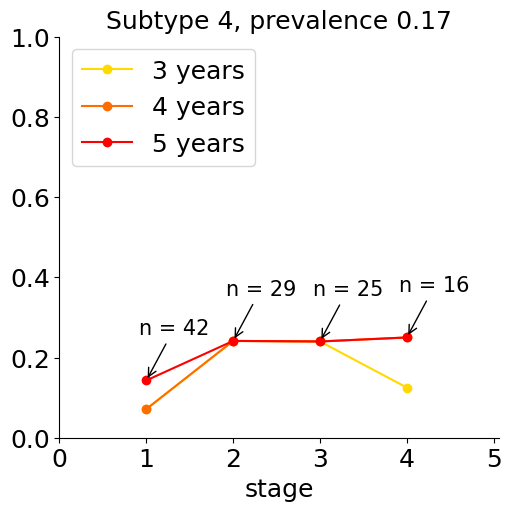

In [322]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in mci_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "MCI"
            bool_srs = srs == "Dementia"
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    mci_subtype["convert"] = mci_subtype["PTID"].map(d_convert)
    mci_subtype = mci_subtype[~mci_subtype["convert"].isna()]
    df_convert = mci_subtype[mci_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(mci_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(20, 30),
              textcoords='offset points', ha='center', va='bottom', fontsize=15,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_mci["convert"] = cox_mci["PTID"].map(d_convert)
    cox_mci["time"] = cox_mci["PTID"].map(d_timedelta)
    cox_mci["subtype"] = Su
    cox_mci["stages_inferred"] = cox_mci["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_mci.csv".format(Su,d_yr)
    cox_mci.to_csv(os.path.join(dir_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_mci, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,1])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "mci_subtype_{}.png".format(Su)
fig.savefig(os.path.join(dir_path, fig_name), dpi=450)


In [313]:
fig_path

NameError: name 'fig_path' is not defined

In [ ]:
Counter(df_convert["stage"])

In [ ]:
Counter(mci_subtype["stage"])

## Controls progression

In [323]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [330]:
Su = 3.0
cn_solved = cnad_solved[cnad_solved["DX"]==0.0]
cn_subtype = cn_solved[cn_solved["subtype"]==Su]
fraction_cn = cn_subtype.shape[0]/cn_solved.shape[0]
cox_cn = cn_demographics[cn_demographics["PTID"].isin(cn_subtype["PTID"])]
dict_stage = dict(zip(cn_subtype["PTID"],cn_subtype["stage"]))

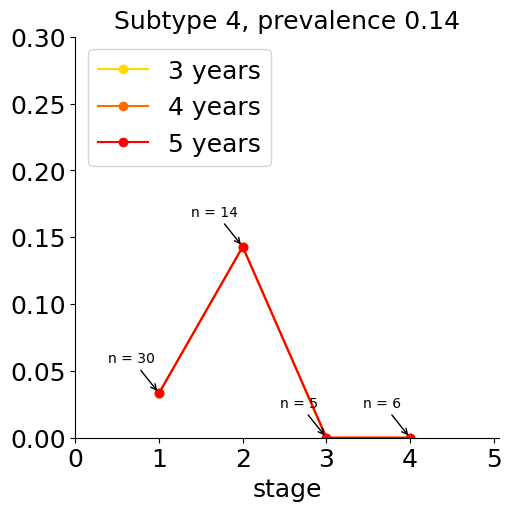

In [331]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in cn_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "CN"
            bool_srs = srs != first_dx
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    cn_subtype["convert"] = cn_subtype["PTID"].map(d_convert)
    cn_subtype = cn_subtype[~cn_subtype["convert"].isna()]
    df_convert = cn_subtype[cn_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(cn_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(-20, 20),
              textcoords='offset points', ha='center', va='bottom',
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_cn["convert"] = cox_cn["PTID"].map(d_convert)
    cox_cn["time"] = cox_cn["PTID"].map(d_timedelta)
    cox_cn["subtype"] = Su
    cox_cn["stages_inferred"] = cox_cn["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_cn.csv".format(Su,d_yr)
    cox_cn.to_csv(os.path.join(dir_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_cn, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,0.3])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "cn_subtype_{}.png".format(Su)
fig.savefig(os.path.join(dir_path, fig_name), dpi=450)


In [ ]:
den_list

In [ ]:
Counter(df_convert["stage"])

In [ ]:
Counter(cn_subtype["stage"])

## Longitudinal data analysis

In [332]:
# Functions for reading longitudinal data and subtyping/staging
def read_long(df_cnad, df_mci, k):
    long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle_adj.csv"
    df_long = pd.read_csv(long_path)
    df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])
    assert all(df_long.columns[:k] == df_cnad.columns[:k])
    cnad_ptid = df_cnad["PTID"].tolist()
    mci_ptid = df_mci["PTID"].tolist()
    df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
    df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]
    return df_long, df_long_cnad, df_long_mci

def subtype_stage(L_yes, L_no, pkl, n_stages, last_N=1000000, N_samples=1000):
    last_N = 1000000
    N_samples = 1000
    sustainData_mci_long = sEBMSustainData(L_yes, L_no, n_stages)
    samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
    samples_f = pkl["samples_f"][:,-last_N:]
    shape_seq = pkl["shape_seq"]
    temp_mean_f = np.mean(samples_f, axis=1)
    ix = np.argsort(temp_mean_f)[::-1]

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)
    return ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage

# Read the long df (MCI and CNAD)
k = 118
df_long, df_long_cnad, df_long_mci = read_long(df_cnad, df_mci, k)

# Get the prob_mat for MCI
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

# Subtype and Stage the MCI subjects and subset them for the relevant columns
ml_subtype_mci, prob_ml_subtype_mci, ml_stage_mci, \
prob_ml_stage_mci, prob_subtype_mci, prob_stage_mci, prob_subtype_stage_mci = subtype_stage(L_yes_mci_long, L_no_mci_long, pkl, n_stages)
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci_subset = df_long_mci[mci_subset]

In [333]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)

In [ ]:
df_long_cnad.shape

In [334]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle_adj.csv"
df_long = pd.read_csv(long_path)
df_long.dropna(subset=["DX"], inplace=True)
df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])

In [335]:
k=118
all(df_long.columns[:k] == df_cnad.columns[:k])

True

In [336]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [337]:
d, merged_df = prepare_longitudinal_data_newL(final_df)

In [338]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [339]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [340]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)

In [341]:
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci

In [342]:
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci[mci_subset]

subtype  stage VISCODE   EXAMDATE        DX         sid
8         0.0    3.0     m06 2007-02-22       MCI  002_S_0729
9         0.0    3.0     m12 2007-09-05  Dementia  002_S_0729
10        0.0    3.0     m24 2008-08-28  Dementia  002_S_0729
11        1.0    4.0     m36 2009-08-13  Dementia  002_S_0729
12        2.0    2.0     m06 2007-03-28       MCI  002_S_0782
...       ...    ...     ...        ...       ...         ...
5541      2.0    1.0     m06 2012-10-04       MCI  941_S_4420
5542      0.0    1.0     m12 2013-03-25       MCI  941_S_4420
5543      2.0    4.0      bl 2012-06-11       MCI  941_S_4764
5545      0.0    5.0     m12 2013-06-10       MCI  941_S_4764
5546      0.0    4.0     m24 2014-06-16       MCI  941_S_4764

[2588 rows x 6 columns]

In [343]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle_adj.csv"
df_long = pd.read_csv(long_path)
df_long.dropna(subset=["DX"], inplace=True)
df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])

In [344]:
df_long.shape

(4851, 131)

In [345]:
len(set(df_long["sid"]))

1698

In [346]:
# set(df_long["sid"])-set(final_df["PTID"])

In [347]:
len(set(final_df["PTID"]))

1658

In [348]:
k=118
all(df_long.columns[:k] == df_cnad.columns[:k])

True

In [349]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [350]:
d, merged_df = prepare_longitudinal_data_newL(final_df)

In [351]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [352]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [353]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)


In [354]:
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci

In [355]:
df_long_mci

3rd-Ventricle  4th-Ventricle   Brain-Stem  CC_Anterior  CC_Central  \
8       -146.992487     409.143071 -1016.751683    18.827748   10.861542   
9       -147.992487     614.143071 -1601.751683   -32.172252   -1.138458   
10        43.007513     222.143071 -2014.751683   -89.172252  -22.138458   
11       -45.992487     661.143071 -1763.751683   -27.172252  -34.138458   
12      -390.614885    -399.569744  1647.255428    91.004244  -12.180819   
...             ...            ...          ...          ...         ...   
5541   -1067.360527    -618.402318 -1766.604585    38.091558   67.096238   
5542   -1088.360527    -661.402318 -2066.604585    32.091558   72.096238   
5543    1411.551114    1120.362421  1210.820612  -190.495419  -53.354346   
5545    1505.551114    1407.362421   952.820612  -207.495419  -79.354346   
5546    1676.551114    1319.362421   640.820612  -253.495419  -84.354346   

      CC_Mid_Anterior  CC_Mid_Posterior  CC_Posterior         CSF  \
8           99.318560         36.900449     56.719711 -121.332053   
9           80.318560         43.900449     72.719711 -170.332053   
10          53.318560         40.900449     25.719711   27.667947   
11          73.318560         28.900449     38.719711   28.667947   
12          -5.451481         26.160569    -39.754979  -87.123428   
...               ...               ...           ...         ...   
5541       108.705255         51.815517    121.311707  -44.661074   
5542        95.705255         57.815517    109.311707   68.338926   
5543      -126.085538        -96.367136    -81.400551  494.603358   
5545      -118.085538        -94.367136    -95.400551  692.603358   
5546      -135.085538       -120.367136    -97.400551  594.603358   

         CortexVol  ...  PTEDUCAT  PTGENDER        PTID  VISCODE  \
8    -25125.039248  ...        16    Female  002_S_0729      m06   
9    -31497.082648  ...        16    Female  002_S_0729      m12   
10   -44177.159548  ...        16    Female  002_S_0729      m24   
11   -39967.645648  ...        16    Female  002_S_0729      m36   
12    -2941.356514  ...        16      Male  002_S_0782      m06   
...            ...  ...       ...       ...         ...      ...   
5541  21474.005752  ...        18      Male  941_S_4420      m06   
5542  16963.039752  ...        18      Male  941_S_4420      m12   
5543   9965.113579  ...        20    Female  941_S_4764       bl   
5545   3015.774479  ...        20    Female  941_S_4764      m12   
5546 -23016.564221  ...        20    Female  941_S_4764      m24   

      align_err_days      date         sid  Gender  subtype  stage  
8                  0   2/22/07  002_S_0729       0      0.0    3.0  
9                  0    9/5/07  002_S_0729       0      0.0    3.0  
10                32   9/29/08  002_S_0729       0      0.0    3.0  
11                 0   8/13/09  002_S_0729       0      1.0    4.0  
12                14   4/11/07  002_S_0782       1      2.0    2.0  
...              ...       ...         ...     ...      ...    ...  
5541              78  12/21/12  941_S_4420       1      2.0    1.0  
5542               0   3/25/13  941_S_4420       1      0.0    1.0  
5543              10    6/1/12  941_S_4764       0      2.0    4.0  
5545               0   6/10/13  941_S_4764       0      0.0    5.0  
5546               0   6/16/14  941_S_4764       0      0.0    4.0  

[2588 rows x 133 columns]

In [356]:
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci[mci_subset]

subtype  stage VISCODE   EXAMDATE        DX         sid
8         0.0    3.0     m06 2007-02-22       MCI  002_S_0729
9         0.0    3.0     m12 2007-09-05  Dementia  002_S_0729
10        0.0    3.0     m24 2008-08-28  Dementia  002_S_0729
11        1.0    4.0     m36 2009-08-13  Dementia  002_S_0729
12        2.0    2.0     m06 2007-03-28       MCI  002_S_0782
...       ...    ...     ...        ...       ...         ...
5541      2.0    1.0     m06 2012-10-04       MCI  941_S_4420
5542      0.0    1.0     m12 2013-03-25       MCI  941_S_4420
5543      2.0    4.0      bl 2012-06-11       MCI  941_S_4764
5545      0.0    5.0     m12 2013-06-10       MCI  941_S_4764
5546      0.0    4.0     m24 2014-06-16       MCI  941_S_4764

[2588 rows x 6 columns]

In [357]:
df_mh = pd.merge(df_long_mci[mci_subset], df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner")
df_mh.replace(-1,np.nan, inplace=True)

In [358]:
fld = "AVDEL30MIN"
df_mh.dropna(subset=[fld], inplace=True)

KeyError: ['AVDEL30MIN']

In [359]:
df_mh.sort_values(["PTID", "EXAMDATE_x"], inplace=True)
df_mh.drop_duplicates("PTID", keep="first", inplace=True)

KeyError: 'EXAMDATE_x'

In [360]:

chi2_table = df_mh.groupby(["stage", fld]).size().unstack(level=1).fillna(0)

KeyError: 'AVDEL30MIN'

In [361]:
chi2_contingency(chi2_table)

(45.3267779987915,
 6.798962062489752e-05,
 15,
 array([[532.74820144,  81.69784173,  62.1294964 ,  27.88489209,
           3.91366906, 175.62589928],
        [213.94299945,  32.80852241,  24.95019369,  11.19811843,
           1.57166574,  70.52850028],
        [166.9358052 ,  25.59988932,  19.4681793 ,   8.73768677,
           1.226342  ,  55.0320974 ],
        [175.37299391,  26.89374654,  20.4521306 ,   9.17930271,
           1.28832319,  57.81350304]]))

In [362]:
df_mh.shape, chi2_table

((850, 86),
 PTMARRY    1.0   2.0   3.0   4.0  5.0     no
 subtype                                     
 0.0      520.0  85.0  66.0  29.0  2.0  182.0
 1.0      185.0  35.0  38.0   8.0  4.0   85.0
 2.0      195.0  22.0   6.0  13.0  0.0   41.0
 3.0      189.0  25.0  17.0   7.0  2.0   51.0)

In [363]:
st = 3
kendalltau(df_mh[df_mh["subtype"]==st]["stage"], df_mh[df_mh["subtype"]==st][fld])

KeyError: 'AVDEL30MIN'

In [364]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_long_subtype_stage = pd.DataFrame(mci_long_subtype_stage, columns=["subtype", "stage"])
mci_long_subtype_stage[["sid", "date"]] = df_long_mci.reset_index(drop=True)[["sid", "date"]]
mci_long_subtype_stage["date"] = pd.to_datetime(mci_long_subtype_stage["date"])
df_followup = mci_long_subtype_stage
df_followup = df_followup.sort_values(["sid", "date"])

In [365]:
def get_pairs(vec):
    trns = []
    l = vec.shape[0]
    for i in range(1,l):
        trns.append((vec[:i][-1], vec[i:][0]))
    return trns

sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["subtype"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

In [366]:
count = np.zeros((4,4))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

NameError: name 'fig_path' is not defined

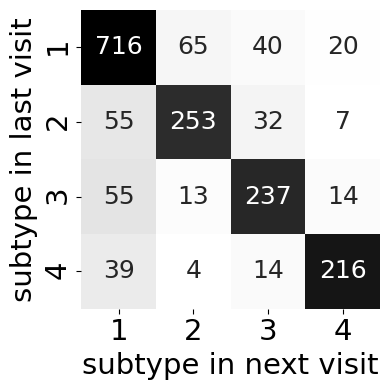

In [367]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("subtype in last visit", fontsize=21)
ax.set_xlabel("subtype in next visit", fontsize=21)
ax.set_xticklabels([1,2,3,4], fontsize=21)
ax.set_yticklabels([1,2,3,4], fontsize=21)
fig_name = "longitudinal_subtype_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [368]:
count.trace() , count.sum()

(1422, 1780)

In [369]:
count.trace()/count.sum()

0.798876404494382

## Stage transition matrix

In [370]:
sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["stage"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

In [371]:
count = np.zeros((6,6))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

NameError: name 'fig_path' is not defined

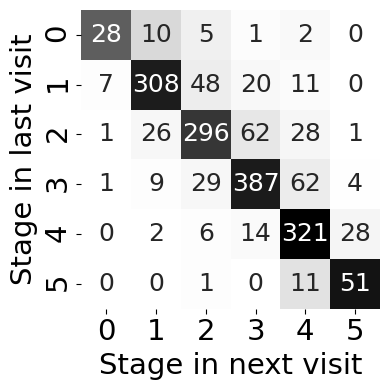

In [372]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("Stage in last visit", fontsize=21)
ax.set_xlabel("Stage in next visit", fontsize=21)
ax.set_xticklabels([0,1,2,3,4,5], fontsize=21)
ax.set_yticklabels([0,1,2,3,4,5], fontsize=21)
fig_name = "longitudinal_stage_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [ ]:
x_ = np.array([0.35,0.27,0.15,0.23])
np.dot(x_,x_)

In [ ]:
mci_long_subtype_stage[["sid", "date"]]

In [ ]:
df_long_mci

In [ ]:
mci_demographics, mci_solved

In [ ]:
mci_solved["EXAMDATE"]

In [ ]:
mci_demo_full = pd.merge(mci_demographics, mci_solved, on=["PTID", "EXAMDATE"])

In [ ]:
mci_solved

In [ ]:
final_df

In [ ]:
mci_demo_full.head()

In [ ]:
mci_demo_full

In [ ]:
mci_demo_full.groupby(["subtype", "APOE4"]).size()

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='stage', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_demographics = merged_df[merged_df["DX"].isin(["CN", "MCI", "Dementia"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
len(set(all_demographics["PTID"]))

In [ ]:
all_demographics

In [ ]:
all_data = pd.merge(all_demographics, final_df, on=["PTID", "EXAMDATE"])

In [ ]:
all_data.pivot_table(index='subtype', columns='DX_x', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data[all_data["DX_x"].isin(["CN", "Dementia"])].pivot_table(index='subtype', columns='PTGENDER', 
                        aggfunc=len, fill_value=0)["PTID"]

# Scrap Analysis

In [ ]:
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/df12_longitudinal_ebm.csv"
df_long = pd.read_csv(long_path)

In [ ]:
len(set(df_adnimerge["PTID"].tolist()))

In [ ]:
len(set(df_long["sid"].tolist()))

In [ ]:
327 + 551

In [ ]:
cols = df_mci.columns[:k].tolist()

In [ ]:
pandas